# ================================================
# AOA++-Optimized Balanced Random Forest (BRF)
# for Leak-Safe Heart Disease Prediction
# Final reproducible notebook for Heliyon submission
# ================================================


# ==============================================================================
# PART 1: SETUP, DATA LOADING, PREPROCESSING & VISUALIZATION
# ==============================================================================

In [1]:
# ===== Block 1 — Imports & Global Settings (all libraries used in the notebook) =====

import numpy as np
import pandas as pd

import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import sparse
import warnings

from IPython.display import display

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    f1_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    confusion_matrix,
)

from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTEENN

from xgboost import XGBClassifier

# ===== Global style / randomness =====
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
np.random.seed(42)


In [2]:
# ===== Block 2: Load Data & Define Columns =====
# Dataset source:
# Official reference: UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/45/heart+disease)
# For reproducibility, a clean copy is loaded from GitHub:
url = "https://raw.githubusercontent.com/Harikishan63/Data-Learnings-/main/heart_disease_uci.csv"
df = pd.read_csv(url)

target_candidates = [c for c in df.columns if c.lower() in ["target","output","disease","num"]]
if not target_candidates:
    raise ValueError("Target column not found")
target_col = target_candidates[0]

y = df[target_col].copy()
if y.nunique() > 2:
    y = (y > 0).astype(int)

drop_cols = [c for c in ["id"] if c in df.columns]
X = df.drop(columns=[target_col] + drop_cols).copy()

likely_categorical = set(['sex','cp','fbs','restecg','exang','slope','ca','thal','dataset'])
cat_cols = [c for c in X.columns if (c.lower() in likely_categorical) or (X[c].dtype == 'object')]
num_cols = [c for c in X.columns if c not in cat_cols]

print("✅ Data shape:", X.shape)
print("✅ Target distribution:", y.value_counts(normalize=True).round(3).to_dict())
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)


✅ Data shape: (920, 14)
✅ Target distribution: {1: 0.553, 0: 0.447}
Numeric cols: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical cols: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


✅ Data loaded.
X shape: (920, 15)
y distribution: {1: 509, 0: 411}
Numeric cols: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical cols: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


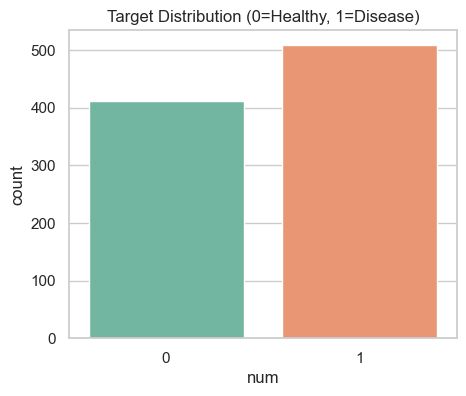

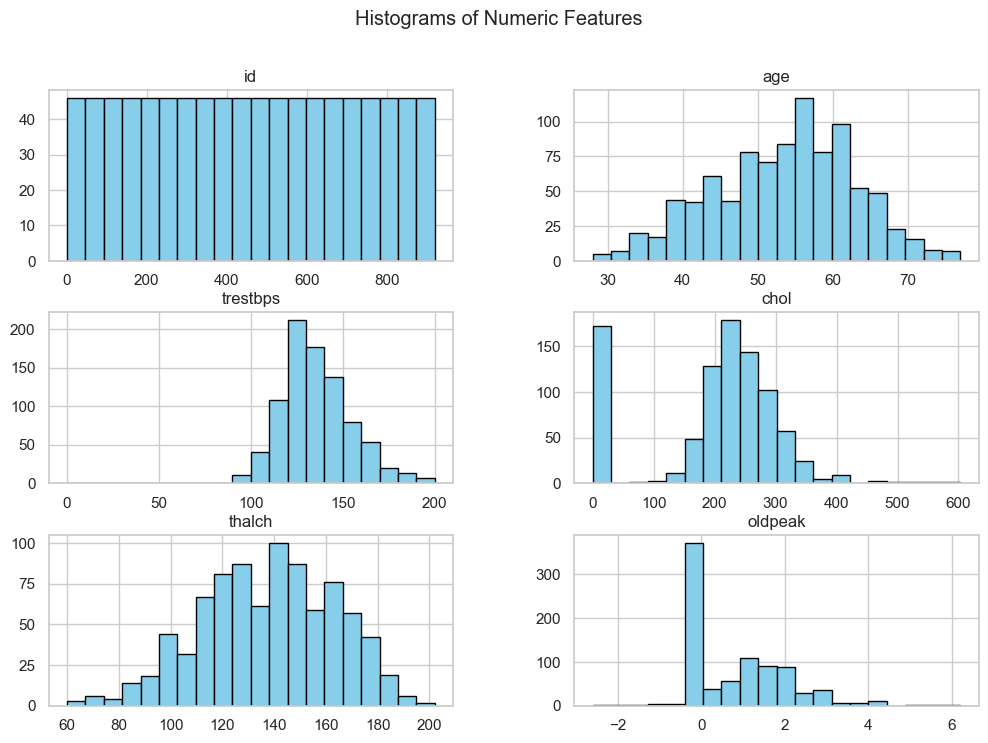

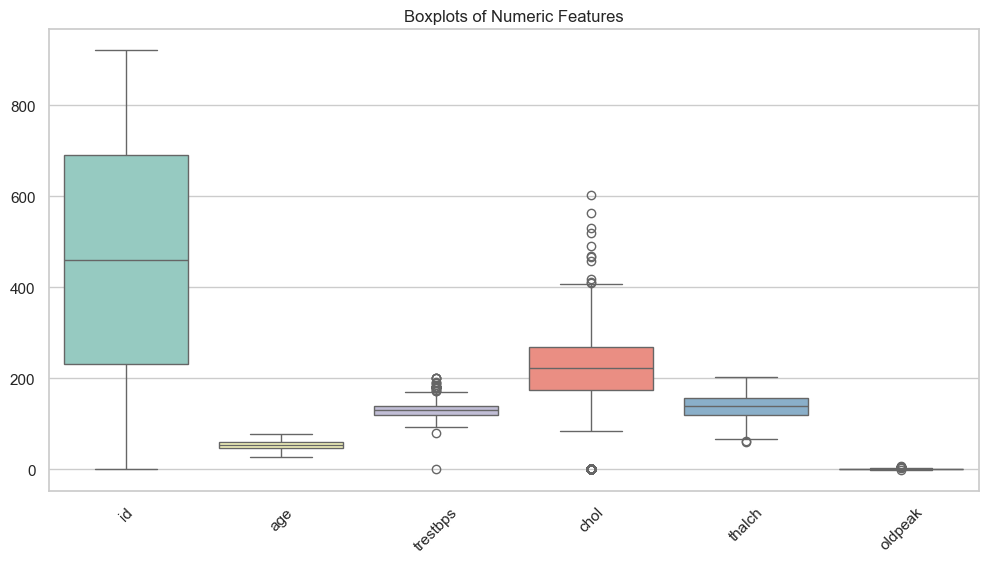

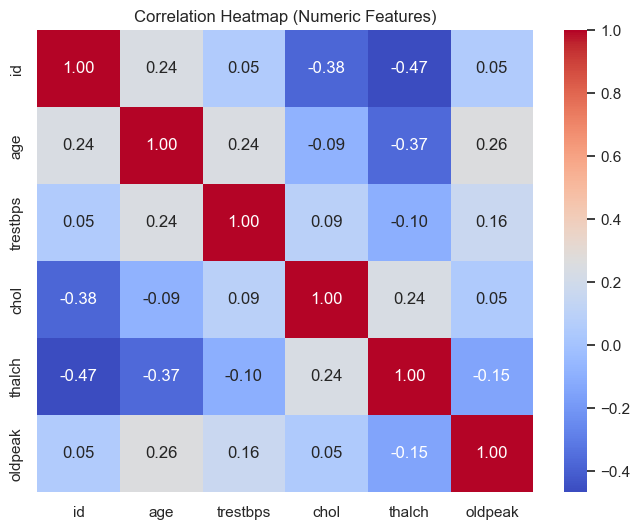

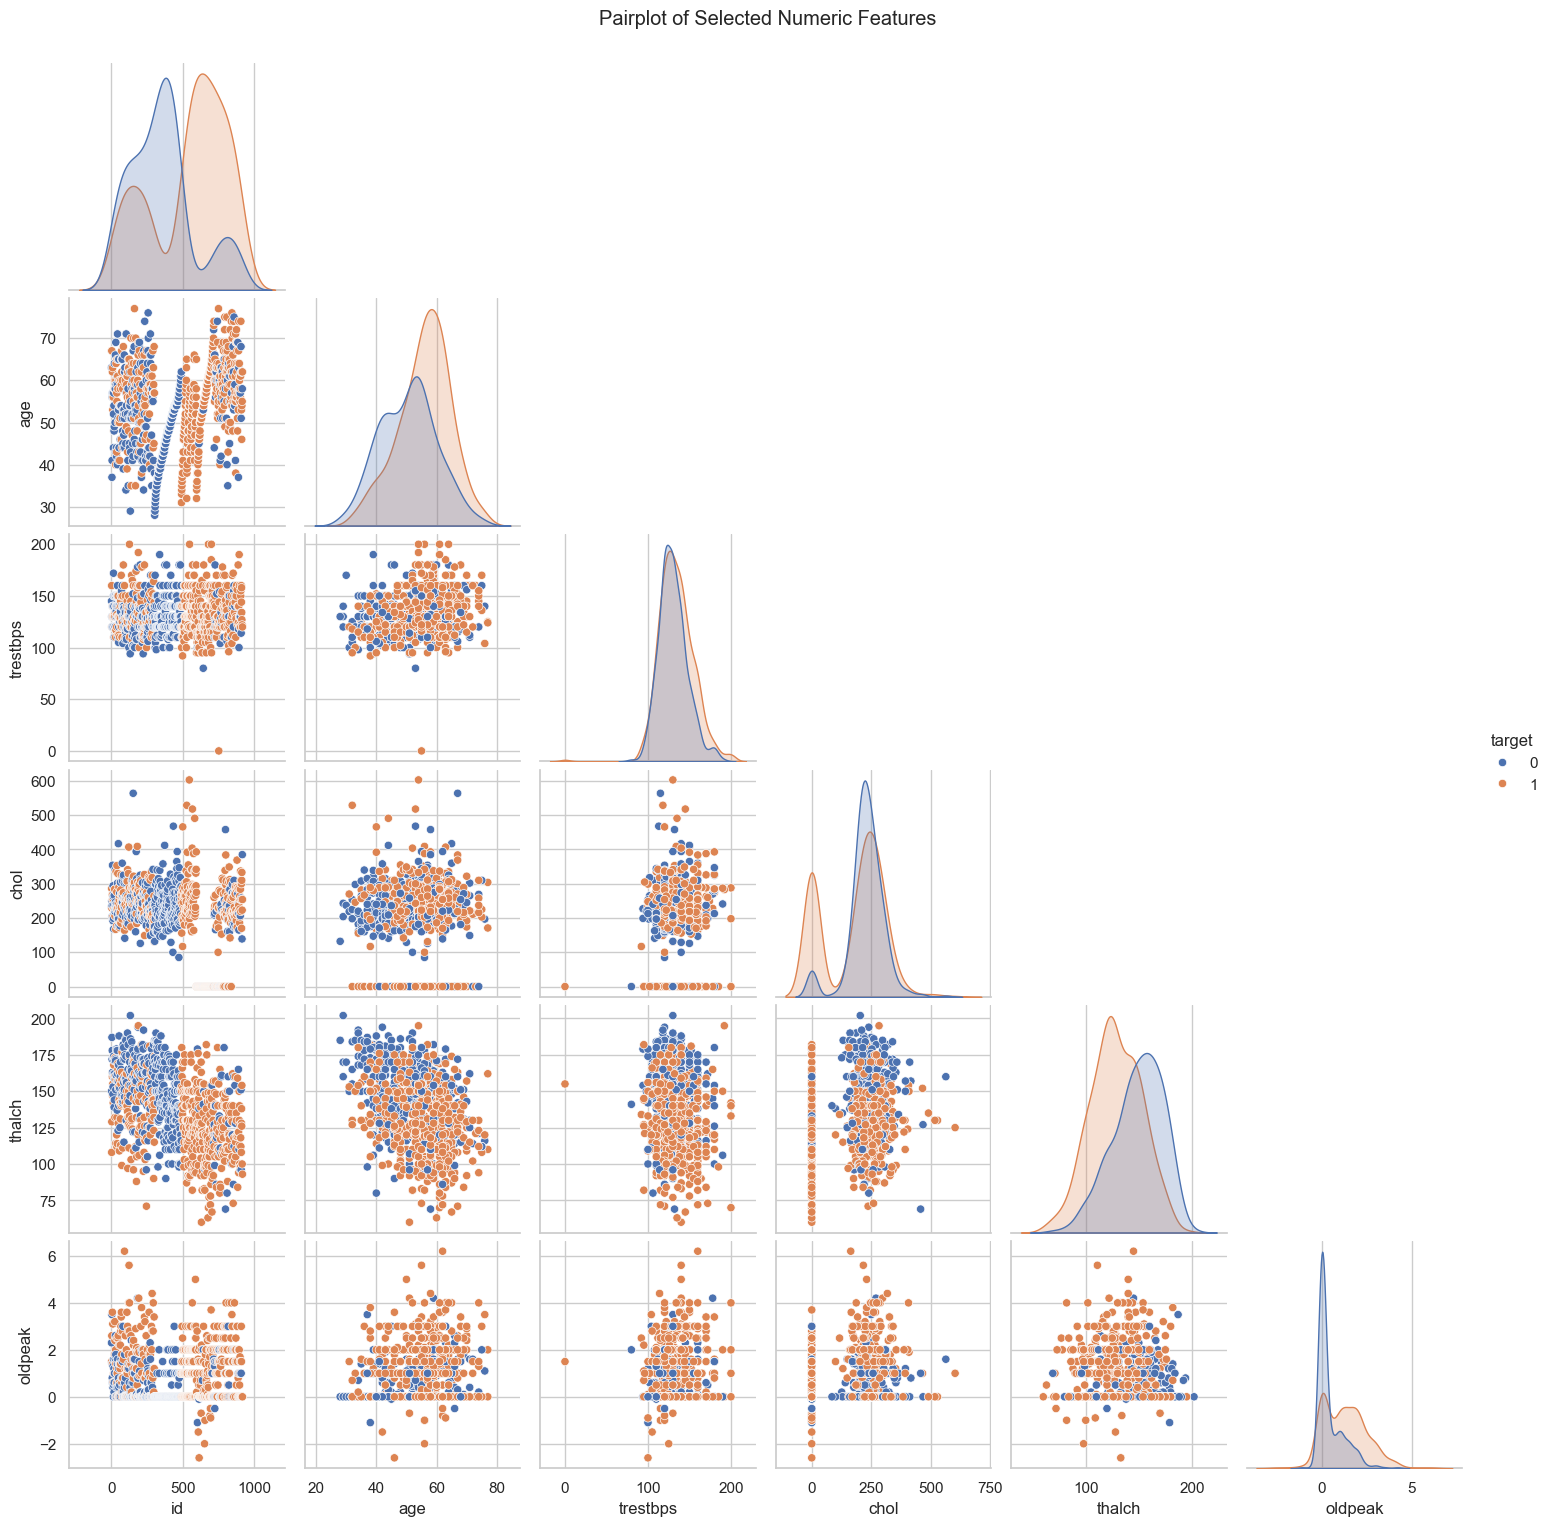

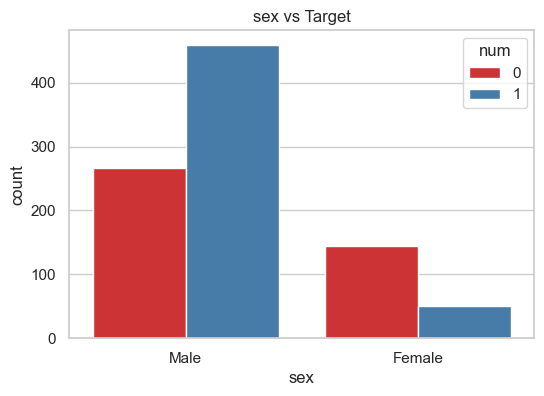

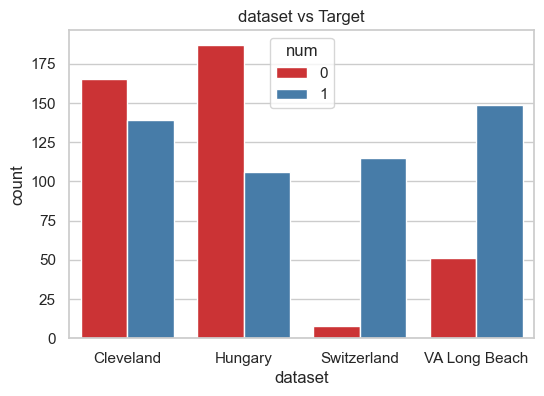

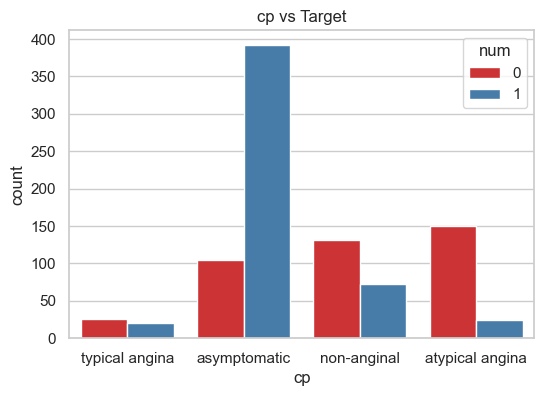

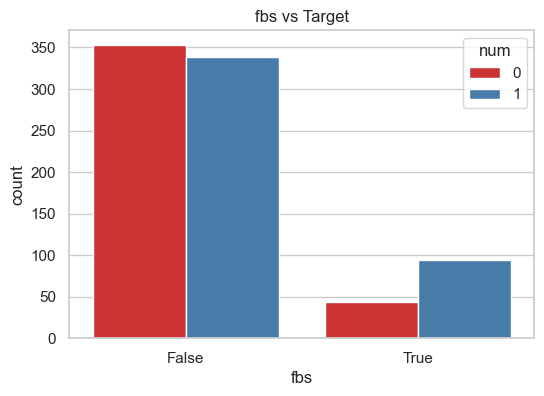

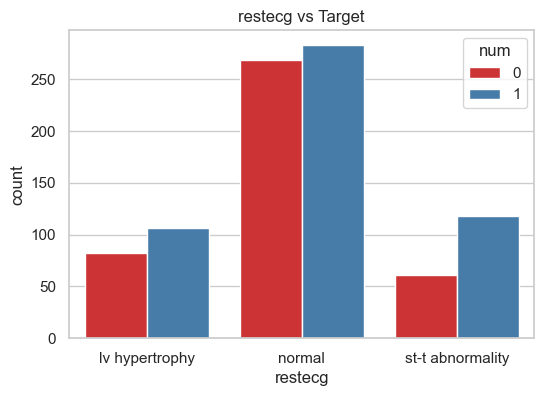

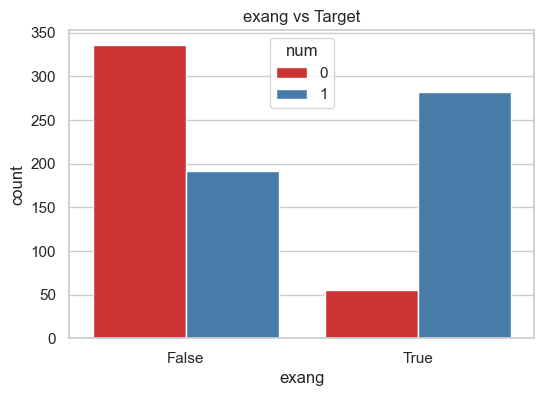

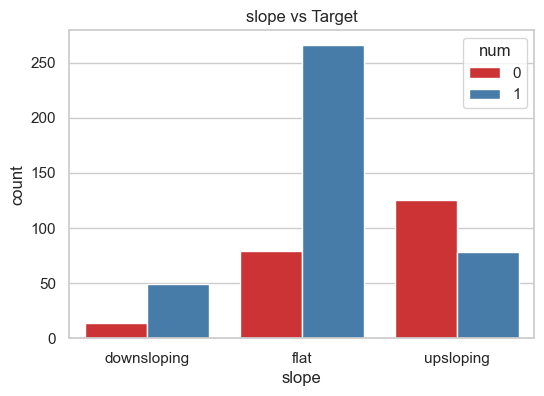

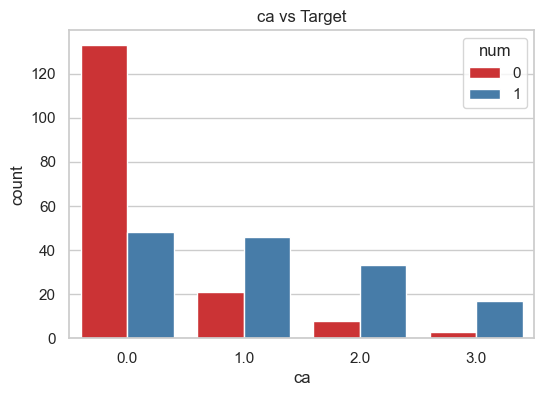

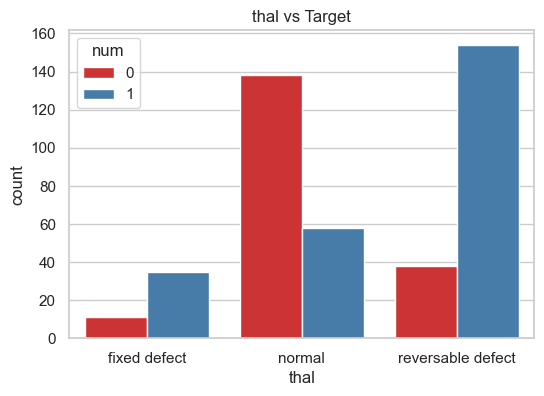

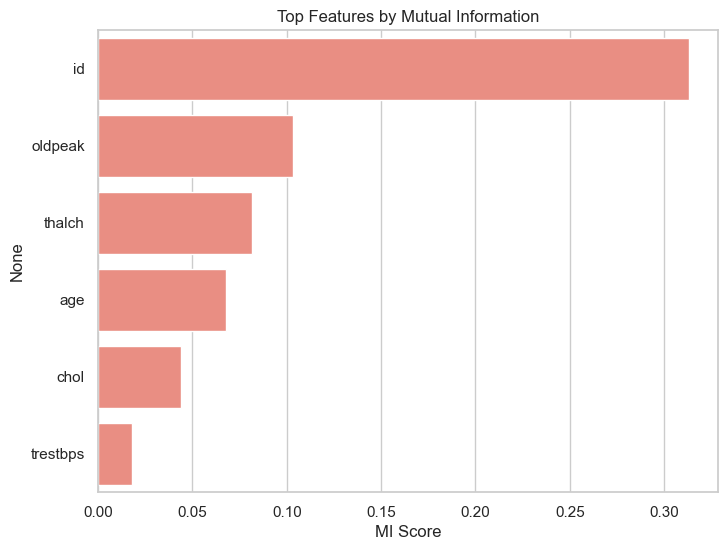

Baseline Logistic Regression AUC: 0.8284982241788919
Shapiro test for id: p=0.0000 -> Not Normal
Shapiro test for age: p=0.0000 -> Not Normal
Shapiro test for trestbps: p=0.0000 -> Not Normal
Shapiro test for chol: p=0.0000 -> Not Normal
Shapiro test for thalch: p=0.0000 -> Not Normal
Shapiro test for oldpeak: p=0.0000 -> Not Normal


In [4]:
# ====== block 3: EDU: Exploratory Data Analysis (EDA/EDU) ======
from sklearn.feature_selection import mutual_info_classif
from scipy import stats


target_col = [c for c in df.columns if c.lower() in ["target","output","disease","num"]][0]
y = df[target_col].copy()
if y.nunique() > 2:  
    y = (y > 0).astype(int)
X = df.drop(columns=[target_col]).copy()


likely_categorical = set(['sex','cp','fbs','restecg','exang','slope','ca','thal'])
cat_cols = [c for c in X.columns if (c.lower() in likely_categorical) or (X[c].dtype == 'object')]
num_cols = [c for c in X.columns if c not in cat_cols]

print("✅ Data loaded.")
print("X shape:", X.shape)
print("y distribution:", y.value_counts().to_dict())
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)


plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="Set2")
plt.title("Target Distribution (0=Healthy, 1=Disease)")
plt.show()


X[num_cols].hist(bins=20, figsize=(12,8), color="skyblue", edgecolor="black")
plt.suptitle("Histograms of Numeric Features")
plt.show()


plt.figure(figsize=(12,6))
sns.boxplot(data=X[num_cols], palette="Set3")
plt.title("Boxplots of Numeric Features")
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(8,6))
sns.heatmap(X[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


sns.pairplot(pd.concat([X[num_cols], y.rename("target")], axis=1),
             hue="target", diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Selected Numeric Features", y=1.02)
plt.show()


for c in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=X[c], hue=y, palette="Set1")
    plt.title(f"{c} vs Target")
    plt.show()


imputer = SimpleImputer(strategy="median")
X_num_imp = imputer.fit_transform(X[num_cols])

mi = mutual_info_classif(X_num_imp, y, random_state=42)
mi_series = pd.Series(mi, index=num_cols).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=mi_series.values, y=mi_series.index, color="salmon")
plt.title("Top Features by Mutual Information")
plt.xlabel("MI Score")
plt.show()


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=200, class_weight="balanced")


oof = cross_val_predict(lr, X_num_imp, y, cv=cv, method="predict_proba")[:,1]
print("Baseline Logistic Regression AUC:", roc_auc_score(y, oof))


for c in num_cols:
    stat, p = stats.shapiro(X[c].dropna())
    print(f"Shapiro test for {c}: p={p:.4f} -> {'Not Normal' if p<0.05 else 'Normal'}")


In [3]:
# ===== Block 4: Pipeline & Utils =====
def build_pipeline(model, num_cols, cat_cols, sampler=None):
    num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", RobustScaler())])
    cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])
    pre = ColumnTransformer([("num", num_pipe, num_cols), ("cat", cat_pipe, cat_cols)])
    steps = [("pre", pre)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", model))
    return ImbPipeline(steps)

def evaluate_pipeline(pipe, X, y, cv):
    proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
    preds_05 = (proba >= 0.5).astype(int)
    metrics = {
        "accuracy": accuracy_score(y, preds_05),
        "roc_auc": roc_auc_score(y, proba),
        "f1": f1_score(y, preds_05),
        "precision": precision_score(y, preds_05),
        "recall": recall_score(y, preds_05)
    }
    RocCurveDisplay.from_predictions(y, proba); plt.title("ROC (OOF)"); plt.show()
    PrecisionRecallDisplay.from_predictions(y, proba); plt.title("PR (OOF)"); plt.show()
    return proba, metrics

def find_best_threshold(y_true, proba, metric="f1"):
    thresholds = np.linspace(0.05, 0.95, 37)
    best_t, best_val = 0.5, -np.inf
    for t in thresholds:
        preds = (proba >= t).astype(int)
        if metric == "f1":
            val = f1_score(y_true, preds)
        elif metric == "balanced_acc":
            from sklearn.metrics import balanced_accuracy_score
            val = balanced_accuracy_score(y_true, preds)
        else:
            val = f1_score(y_true, preds)
        if val > best_val:
            best_val, best_t = val, t
    return best_t, best_val


# ==============================================================================
# PART 2: HYPERPARAMETER OPTIMIZATION (AOA & AOA++)
# ==============================================================================

Iter 1/5 (RF+SMOTEENN) | Score=0.8815 | AUC=0.9179 | F1=0.8489 | ACC=0.8293 | Recall=0.8664
Iter 2/5 (RF+SMOTEENN) | Score=0.8815 | AUC=0.9179 | F1=0.8489 | ACC=0.8293 | Recall=0.8664
Iter 3/5 (RF+SMOTEENN) | Score=0.8820 | AUC=0.9181 | F1=0.8535 | ACC=0.8359 | Recall=0.8644
Iter 4/5 (RF+SMOTEENN) | Score=0.8820 | AUC=0.9181 | F1=0.8535 | ACC=0.8359 | Recall=0.8644
Iter 5/5 (RF+SMOTEENN) | Score=0.8820 | AUC=0.9181 | F1=0.8535 | ACC=0.8359 | Recall=0.8644
Iter 1/5 (BRF) | Score=0.9216 | AUC=0.9404 | F1=0.8989 | ACC=0.8859 | Recall=0.9175
Iter 2/5 (BRF) | Score=0.9216 | AUC=0.9404 | F1=0.8989 | ACC=0.8859 | Recall=0.9175
Iter 3/5 (BRF) | Score=0.9219 | AUC=0.9429 | F1=0.8955 | ACC=0.8815 | Recall=0.9175
Iter 4/5 (BRF) | Score=0.9219 | AUC=0.9429 | F1=0.8955 | ACC=0.8815 | Recall=0.9175
Iter 5/5 (BRF) | Score=0.9233 | AUC=0.9410 | F1=0.8985 | ACC=0.8848 | Recall=0.9214
Iter 1/5 (BRF+SMOTEENN) | Score=0.8853 | AUC=0.9177 | F1=0.8525 | ACC=0.8326 | Recall=0.8743
Iter 2/5 (BRF+SMOTEENN) | S

  File "D:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "D:\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\subprocess.py", line 1554, in _execute_child
    hp, ht, pi


Final RF+SMOTEENN (Train/Oof):
Accuracy: 0.836
Roc_auc: 0.908
Recall: 0.865
Precision: 0.842
F1: 0.853

Final RF+SMOTEENN (Test):
Accuracy: 0.864
Roc_auc: 0.951
Recall: 0.912
Precision: 0.853
F1: 0.882

Final BRF (Train/Oof):
Accuracy: 0.876
Roc_auc: 0.932
Recall: 0.914
Precision: 0.869
F1: 0.891

Final BRF (Test):
Accuracy: 0.886
Roc_auc: 0.962
Recall: 0.941
Precision: 0.865
F1: 0.901

Final BRF+SMOTEENN (Train/Oof):
Accuracy: 0.842
Roc_auc: 0.910
Recall: 0.882
Precision: 0.841
F1: 0.861

Final BRF+SMOTEENN (Test):
Accuracy: 0.859
Roc_auc: 0.949
Recall: 0.912
Precision: 0.845
F1: 0.877


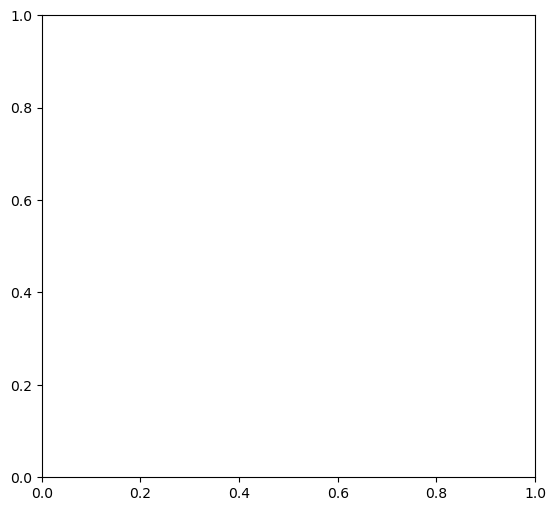

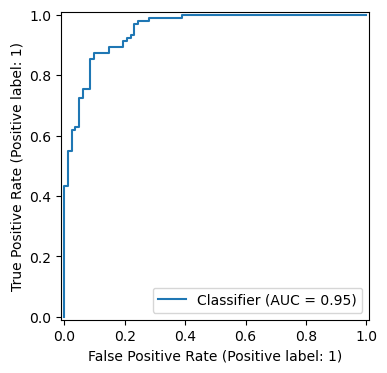

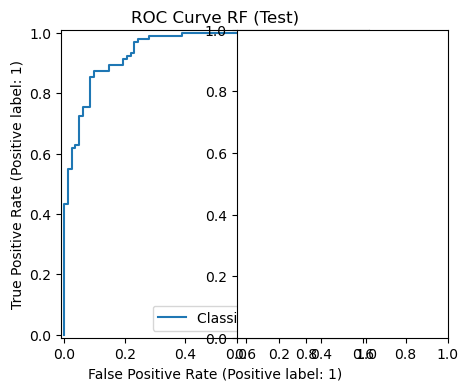

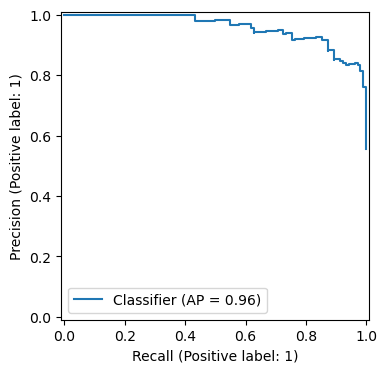

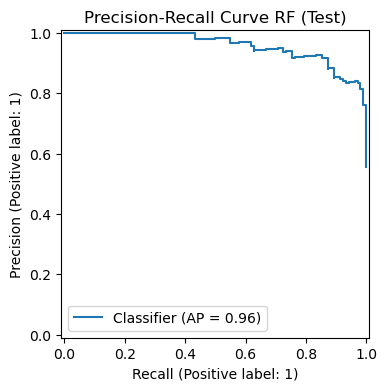

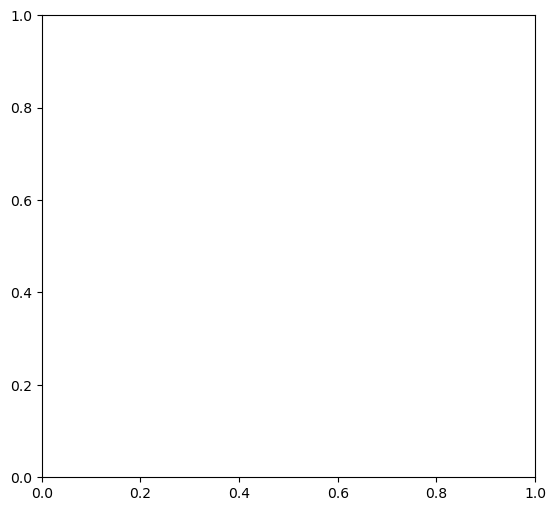

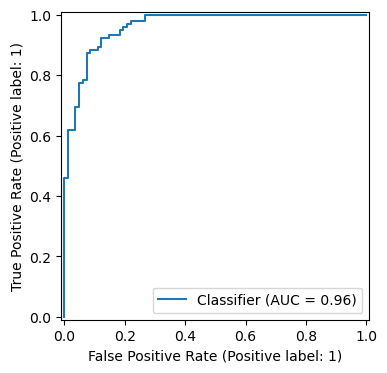

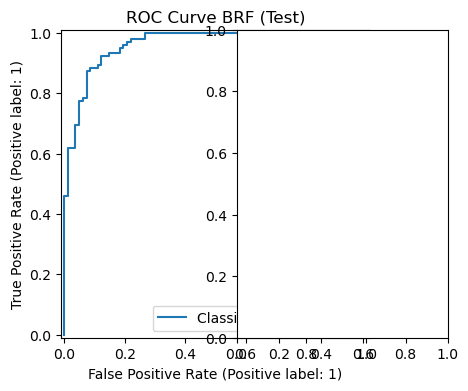

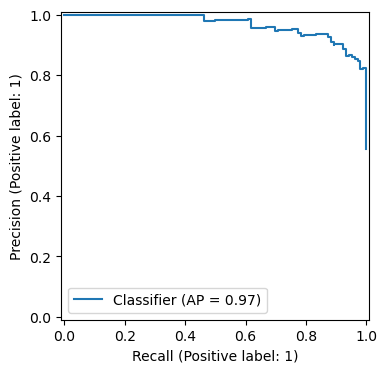

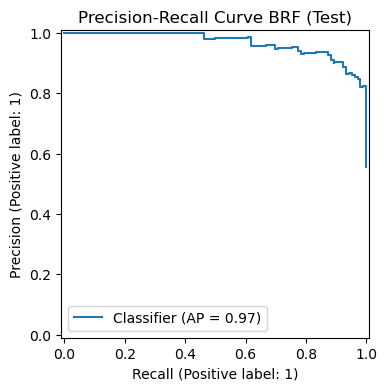

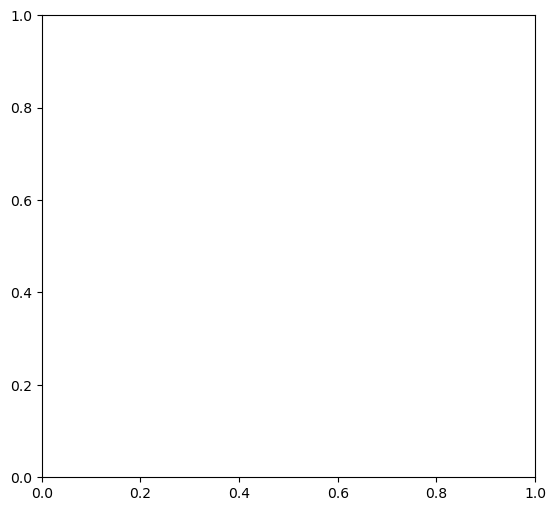

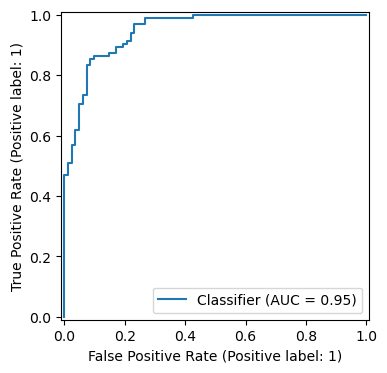

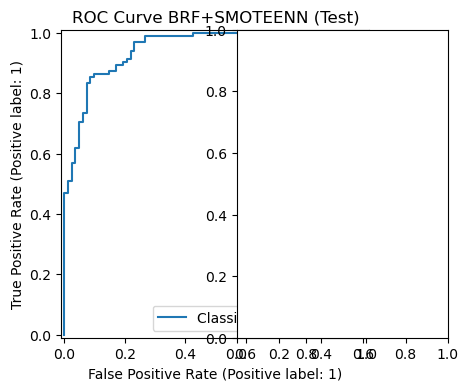

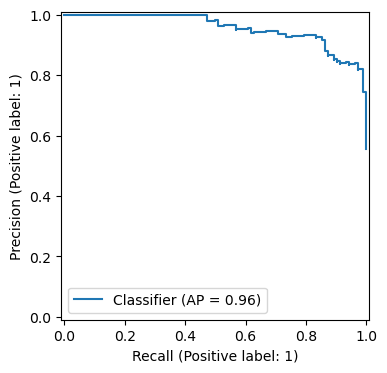

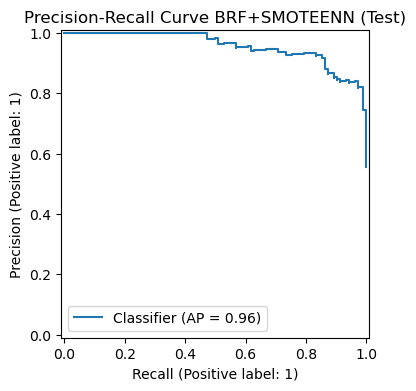

In [11]:
# ===== Block 5: AOA Optimization + Final Modeling + Evaluation (max_iter=5 , pop_size=8) =====

def aoa_optimize_rf_simple(X, y, num_cols, cat_cols, max_iter=5, pop_size=8, seed=42):
    rng = np.random.RandomState(seed)
    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7))
        }
    def build_rf(p):
        return RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            n_jobs=-1,
            random_state=seed
        )
    def build_brf(p):
        return BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            random_state=seed,
            n_jobs=-1
        )
    def fitness(p, use_brf=False, use_sampler=False):
        if use_brf:
            estimator = build_brf(p)
            sampler = SMOTEENN(random_state=seed) if use_sampler else None
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=sampler)
        else:
            estimator = build_rf(p)
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=SMOTEENN(random_state=seed))
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        f1 = f1_score(y, oof_pred)
        recall = recall_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        precision = precision_score(y, oof_pred)
        score = 0.4 * auc + 0.4 * recall + 0.1 * f1 + 0.1 * acc
        return score, {"auc": auc, "acc": acc, "f1": f1, "recall": recall, "precision": precision}
    
    # Optimize for RF with SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_rf, best_score_rf, best_metrics_rf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=False)
            if sc > best_score_rf:
                best_rf, best_score_rf, best_metrics_rf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (RF+SMOTEENN) | Score={best_score_rf:.4f} | AUC={best_metrics_rf['auc']:.4f} | F1={best_metrics_rf['f1']:.4f} | ACC={best_metrics_rf['acc']:.4f} | Recall={best_metrics_rf['recall']:.4f}")

    # Optimize for BRF without SMOTEENN (separate loop)
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf, best_score_brf, best_metrics_brf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=False)
            if sc > best_score_brf:
                best_brf, best_score_brf, best_metrics_brf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF) | Score={best_score_brf:.4f} | AUC={best_metrics_brf['auc']:.4f} | F1={best_metrics_brf['f1']:.4f} | ACC={best_metrics_brf['acc']:.4f} | Recall={best_metrics_brf['recall']:.4f}")
    
    # Optimize for BRF with SMOTEENN (separate loop)
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=True)
            if sc > best_score_brf_smoteen:
                best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF+SMOTEENN) | Score={best_score_brf_smoteen:.4f} | AUC={best_metrics_brf_smoteen['auc']:.4f} | F1={best_metrics_brf_smoteen['f1']:.4f} | ACC={best_metrics_brf_smoteen['acc']:.4f} | Recall={best_metrics_brf_smoteen['recall']:.4f}")

    return (best_rf, best_metrics_rf), (best_brf, best_metrics_brf), (best_brf_smoteen, best_metrics_brf_smoteen)

# اجرای بهینه‌سازی پارامترها
(best_params_rf, best_mets_rf), (best_params_brf, best_mets_brf), (best_params_brf_smoteen, best_mets_brf_smoteen) = aoa_optimize_rf_simple(X, y, num_cols, cat_cols, max_iter=5, pop_size=8)

print("\nBest RF params (AOA Simple with SMOTEENN):", best_params_rf)
print("Best (AOA Simple with SMOTEENN) metrics (CV 10x1):", best_mets_rf)

print("\nBest BRF params (AOA Simple without SMOTEENN):", best_params_brf)
print("Best (AOA Simple without SMOTEENN) metrics (CV 10x1):", best_mets_brf)

print("\nBest BRF params (AOA Simple with SMOTEENN):", best_params_brf_smoteen)
print("Best (AOA Simple with SMOTEENN) metrics (CV 10x1):", best_mets_brf_smoteen)

# ساخت مدل‌ها با پارامتر بهتر و pipeline
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
pipe_final = build_pipeline(rf_final, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

brf_final = BalancedRandomForestClassifier(**best_params_brf, random_state=42, n_jobs=-1)
pipe_brf = build_pipeline(brf_final, num_cols, cat_cols, sampler=None)

brf_final_smoteen = BalancedRandomForestClassifier(**best_params_brf_smoteen, random_state=42, n_jobs=-1)
pipe_brf_smoteen = build_pipeline(brf_final_smoteen, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

# تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# آموزش مدل‌ها
pipe_final.fit(X_train, y_train)
pipe_brf.fit(X_train, y_train)
pipe_brf_smoteen.fit(X_train, y_train)

# تابع محاسبه متریک روی train (OOF)
def calc_metrics(pipe, X, y):
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                             method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }

# محاسبه متریک روی داده آموزش (train)
metrics_train_rf = calc_metrics(pipe_final, X_train, y_train)
metrics_train_brf = calc_metrics(pipe_brf, X_train, y_train)
metrics_train_brf_smoteen = calc_metrics(pipe_brf_smoteen, X_train, y_train)

# تابع محاسبه متریک و خروجی احتمال روی test
def calc_metrics_test(pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

# محاسبه متریک و احتمال روی داده تست (test)
metrics_test_rf, proba_test_rf = calc_metrics_test(pipe_final, X_test, y_test)
metrics_test_brf, proba_test_brf = calc_metrics_test(pipe_brf, X_test, y_test)
metrics_test_brf_smoteen, proba_test_brf_smoteen = calc_metrics_test(pipe_brf_smoteen, X_test, y_test)

# چاپ متریک‌ها (دسته‌بندی)
print("\nFinal RF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal RF+SMOTEENN (Test):")
for k, v in metrics_test_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Train/Oof):")
for k, v in metrics_train_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Test):")
for k, v in metrics_test_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Test):")
for k, v in metrics_test_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

# رسم نمودار ROC و Precision-Recall فقط روی داده تست
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("ROC Curve RF (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("Precision-Recall Curve RF (Test)")

plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("ROC Curve BRF (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("Precision-Recall Curve BRF (Test)")

plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("ROC Curve BRF+SMOTEENN (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("Precision-Recall Curve BRF+SMOTEENN (Test)")

plt.show()


Iter 1/5 (RF+SMOTEENN) | Score=0.8981 | AUC=0.9230 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 2/5 (RF+SMOTEENN) | Score=0.8981 | AUC=0.9230 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 3/5 (RF+SMOTEENN) | Score=0.8981 | AUC=0.9230 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 4/5 (RF+SMOTEENN) | Score=0.8981 | AUC=0.9230 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 5/5 (RF+SMOTEENN) | Score=0.8981 | AUC=0.9230 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 1/5 (BRF) | Score=0.9228 | AUC=0.9443 | F1=0.8940 | ACC=0.8793 | Recall=0.9194
Iter 2/5 (BRF) | Score=0.9229 | AUC=0.9438 | F1=0.8916 | ACC=0.8761 | Recall=0.9214
Iter 3/5 (BRF) | Score=0.9237 | AUC=0.9410 | F1=0.9002 | ACC=0.8870 | Recall=0.9214
Iter 4/5 (BRF) | Score=0.9237 | AUC=0.9410 | F1=0.9002 | ACC=0.8870 | Recall=0.9214
Iter 5/5 (BRF) | Score=0.9237 | AUC=0.9410 | F1=0.9002 | ACC=0.8870 | Recall=0.9214
Iter 1/5 (BRF+SMOTEENN) | Score=0.9023 | AUC=0.9218 | F1=0.8766 | ACC=0.8598 | Recall=0.8998
Iter 2/5 (BRF+SMOTEENN) | S

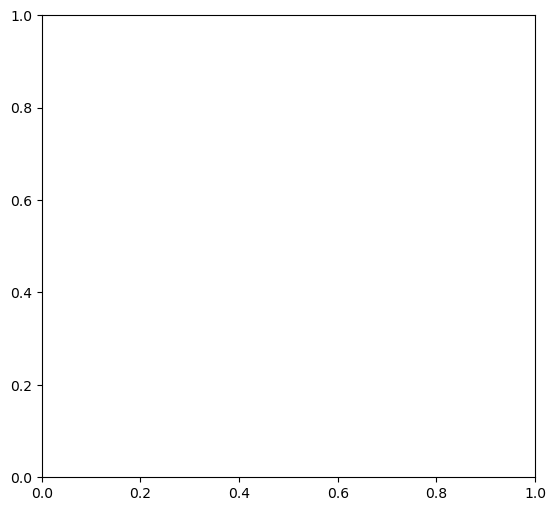

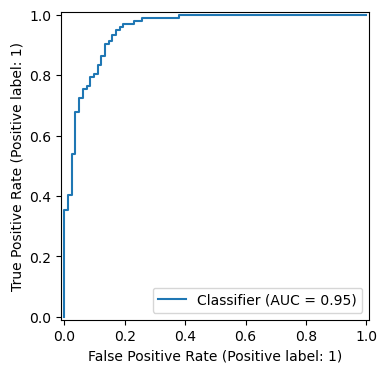

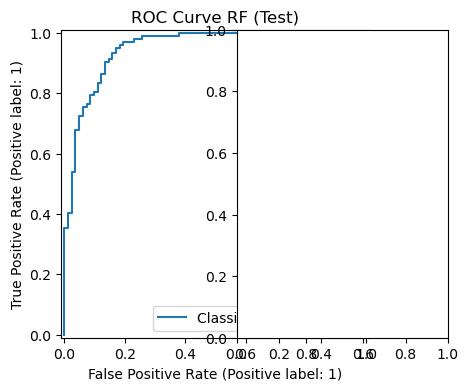

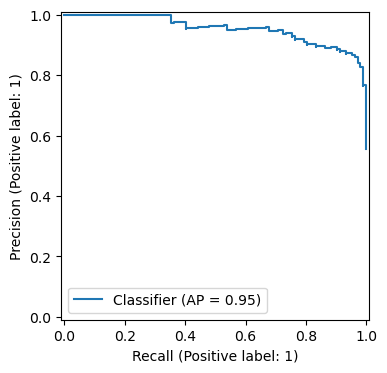

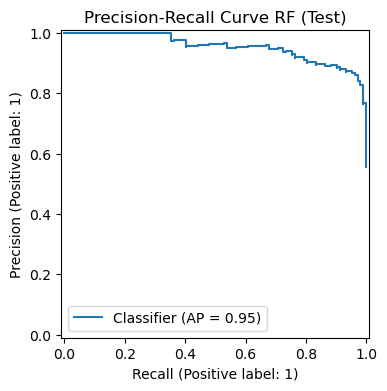

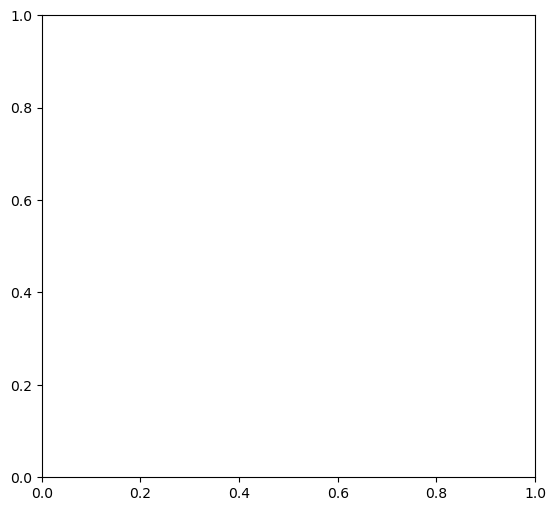

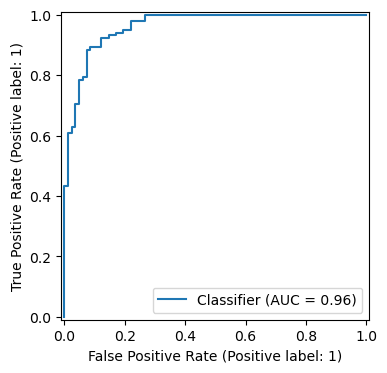

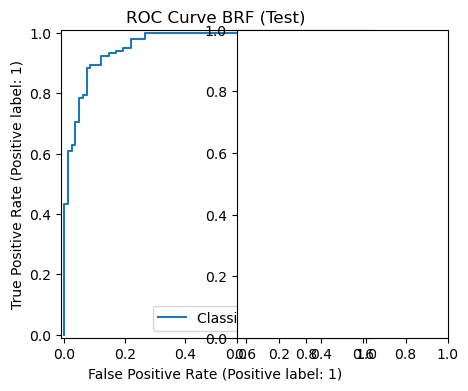

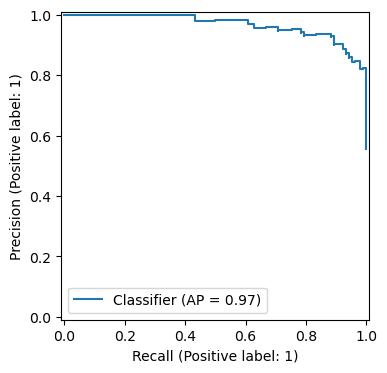

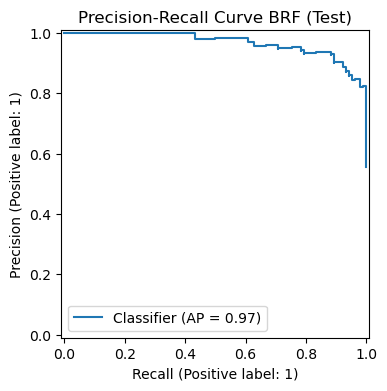

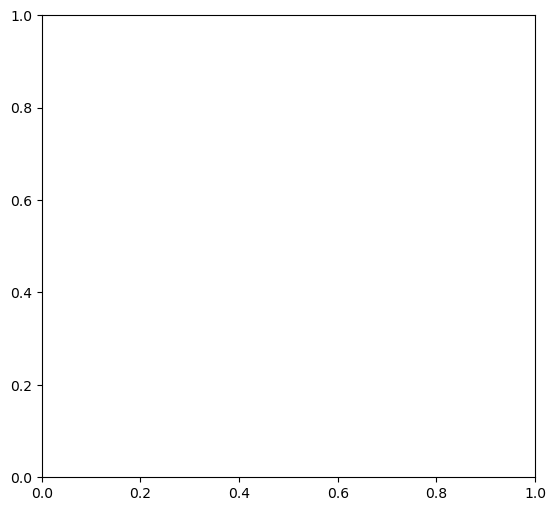

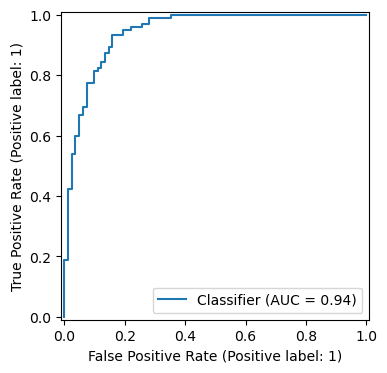

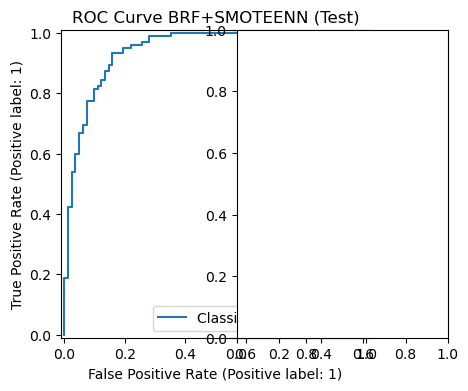

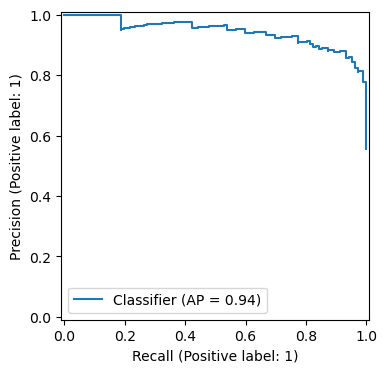

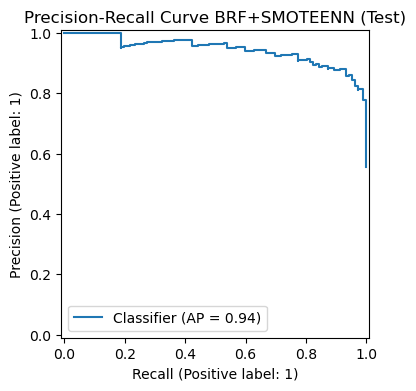

In [6]:
# ===== Block 6: AOA++ Optimization + Final Modeling + Evaluation (max_iter=5, pop_size=8) =====


def aoa_optimize_rf_plusplus(X, y, num_cols, cat_cols, max_iter=5, pop_size=8, seed=42):
    rng = np.random.RandomState(seed)
    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7)),
            "max_features": rng.choice(['sqrt', 'log2', None]),
            "bootstrap": bool(rng.randint(0,2)),
            "class_weight": rng.choice([None, 'balanced'])
        }
    def build_rf(p):
        return RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            bootstrap=p["bootstrap"],
            class_weight=p["class_weight"],
            n_jobs=-1,
            random_state=seed
        )
    def build_brf(p):
        # class_weight و bootstrap در BRF پشتیبانی نمی‌شود
        return BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            random_state=seed,
            n_jobs=-1
        )
    def fitness(p, use_brf=False, use_sampler=False):
        if use_brf:
            estimator = build_brf(p)
            sampler = SMOTEENN(random_state=seed) if use_sampler else None
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=sampler)
        else:
            estimator = build_rf(p)
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=SMOTEENN(random_state=seed))
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        f1 = f1_score(y, oof_pred)
        recall = recall_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        precision = precision_score(y, oof_pred)
        score = 0.4 * auc + 0.4 * recall + 0.1 * f1 + 0.1 * acc
        return score, {"auc": auc, "acc": acc, "f1": f1, "recall": recall, "precision": precision}

    # RF+SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_rf, best_score_rf, best_metrics_rf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            if rng.rand() < 0.3:
                c["bootstrap"] = not c["bootstrap"]
            if rng.rand() < 0.3:
                c["class_weight"] = rng.choice([None, "balanced"])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=False)
            if sc > best_score_rf:
                best_rf, best_score_rf, best_metrics_rf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (RF+SMOTEENN) | Score={best_score_rf:.4f} | AUC={best_metrics_rf['auc']:.4f} | F1={best_metrics_rf['f1']:.4f} | ACC={best_metrics_rf['acc']:.4f} | Recall={best_metrics_rf['recall']:.4f}")

    # BRF بدون SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf, best_score_brf, best_metrics_brf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=False)
            if sc > best_score_brf:
                best_brf, best_score_brf, best_metrics_brf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF) | Score={best_score_brf:.4f} | AUC={best_metrics_brf['auc']:.4f} | F1={best_metrics_brf['f1']:.4f} | ACC={best_metrics_brf['acc']:.4f} | Recall={best_metrics_brf['recall']:.4f}")

    # BRF+SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=True)
            if sc > best_score_brf_smoteen:
                best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF+SMOTEENN) | Score={best_score_brf_smoteen:.4f} | AUC={best_metrics_brf_smoteen['auc']:.4f} | F1={best_metrics_brf_smoteen['f1']:.4f} | ACC={best_metrics_brf_smoteen['acc']:.4f} | Recall={best_metrics_brf_smoteen['recall']:.4f}")

    return (best_rf, best_metrics_rf), (best_brf, best_metrics_brf), (best_brf_smoteen, best_metrics_brf_smoteen)

# اجرای بهینه‌سازی پارامترها به روش پیشرفته‌تر (AOA++)
(best_params_rf, best_mets_rf), (best_params_brf, best_mets_brf), (best_params_brf_smoteen, best_mets_brf_smoteen) = aoa_optimize_rf_plusplus(X, y, num_cols, cat_cols, max_iter=5, pop_size=8)

print("\nBest RF params (AOA++):", best_params_rf)
print("Best (AOA++) metrics (CV 10x1):", best_mets_rf)

print("\nBest BRF params (AOA++):", best_params_brf)
print("Best (AOA++) metrics (CV 10x1):", best_mets_brf)

print("\nBest BRF+SMOTEENN params (AOA++):", best_params_brf_smoteen)
print("Best (AOA++ with SMOTEENN) metrics (CV 10x1):", best_mets_brf_smoteen)

# ساخت مدل‌ها با پارامتر بهتر و pipeline
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
pipe_final = build_pipeline(rf_final, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

brf_final = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf = build_pipeline(brf_final, num_cols, cat_cols, sampler=None)

brf_final_smoteen = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf_smoteen.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf_smoteen = build_pipeline(brf_final_smoteen, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe_final.fit(X_train, y_train)
pipe_brf.fit(X_train, y_train)
pipe_brf_smoteen.fit(X_train, y_train)

# تابع و چاپ متریک‌ها مشابه نسخه ساده (کپی از کد قبلی)
def calc_metrics(pipe, X, y):
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                             method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }

metrics_train_rf = calc_metrics(pipe_final, X_train, y_train)
metrics_train_brf = calc_metrics(pipe_brf, X_train, y_train)
metrics_train_brf_smoteen = calc_metrics(pipe_brf_smoteen, X_train, y_train)

def calc_metrics_test(pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

metrics_test_rf, proba_test_rf = calc_metrics_test(pipe_final, X_test, y_test)
metrics_test_brf, proba_test_brf = calc_metrics_test(pipe_brf, X_test, y_test)
metrics_test_brf_smoteen, proba_test_brf_smoteen = calc_metrics_test(pipe_brf_smoteen, X_test, y_test)

# چاپ بلوکی و دسته‌بندی حرفه‌ای
print("\nFinal RF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal RF+SMOTEENN (Test):")
for k, v in metrics_test_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Train/Oof):")
for k, v in metrics_train_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Test):")
for k, v in metrics_test_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Test):")
for k, v in metrics_test_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

# رسم نمودارهای ROC و PR برای test
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("ROC Curve RF (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("Precision-Recall Curve RF (Test)")
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("ROC Curve BRF (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("Precision-Recall Curve BRF (Test)")
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("ROC Curve BRF+SMOTEENN (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("Precision-Recall Curve BRF+SMOTEENN (Test)")
plt.show()


Iter 1/10 (RF+SMOTEENN) | Score=0.8843 | AUC=0.9198 | F1=0.8541 | ACC=0.8359 | Recall=0.8684
Iter 2/10 (RF+SMOTEENN) | Score=0.8843 | AUC=0.9198 | F1=0.8541 | ACC=0.8359 | Recall=0.8684
Iter 3/10 (RF+SMOTEENN) | Score=0.8843 | AUC=0.9198 | F1=0.8541 | ACC=0.8359 | Recall=0.8684
Iter 4/10 (RF+SMOTEENN) | Score=0.8843 | AUC=0.9198 | F1=0.8541 | ACC=0.8359 | Recall=0.8684
Iter 5/10 (RF+SMOTEENN) | Score=0.8877 | AUC=0.9198 | F1=0.8591 | ACC=0.8413 | Recall=0.8743
Iter 6/10 (RF+SMOTEENN) | Score=0.8877 | AUC=0.9198 | F1=0.8591 | ACC=0.8413 | Recall=0.8743
Iter 7/10 (RF+SMOTEENN) | Score=0.8877 | AUC=0.9198 | F1=0.8591 | ACC=0.8413 | Recall=0.8743
Iter 8/10 (RF+SMOTEENN) | Score=0.8877 | AUC=0.9198 | F1=0.8591 | ACC=0.8413 | Recall=0.8743
Iter 9/10 (RF+SMOTEENN) | Score=0.8877 | AUC=0.9198 | F1=0.8591 | ACC=0.8413 | Recall=0.8743
Iter 10/10 (RF+SMOTEENN) | Score=0.8877 | AUC=0.9198 | F1=0.8591 | ACC=0.8413 | Recall=0.8743
Iter 1/10 (BRF) | Score=0.9215 | AUC=0.9410 | F1=0.8972 | ACC=0.8837 

  File "D:\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "D:\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\anaconda3\Lib\subprocess.py", line 1554, in _execute_child
    hp, ht, pi


Final RF+SMOTEENN (Train/Oof):
Accuracy: 0.840
Roc_auc: 0.912
Recall: 0.867
Precision: 0.847
F1: 0.857

Final RF+SMOTEENN (Test):
Accuracy: 0.875
Roc_auc: 0.955
Recall: 0.941
Precision: 0.850
F1: 0.893

Final BRF (Train/Oof):
Accuracy: 0.878
Roc_auc: 0.932
Recall: 0.916
Precision: 0.869
F1: 0.892

Final BRF (Test):
Accuracy: 0.886
Roc_auc: 0.963
Recall: 0.951
Precision: 0.858
F1: 0.902

Final BRF+SMOTEENN (Train/Oof):
Accuracy: 0.837
Roc_auc: 0.908
Recall: 0.872
Precision: 0.839
F1: 0.855

Final BRF+SMOTEENN (Test):
Accuracy: 0.864
Roc_auc: 0.949
Recall: 0.922
Precision: 0.847
F1: 0.883


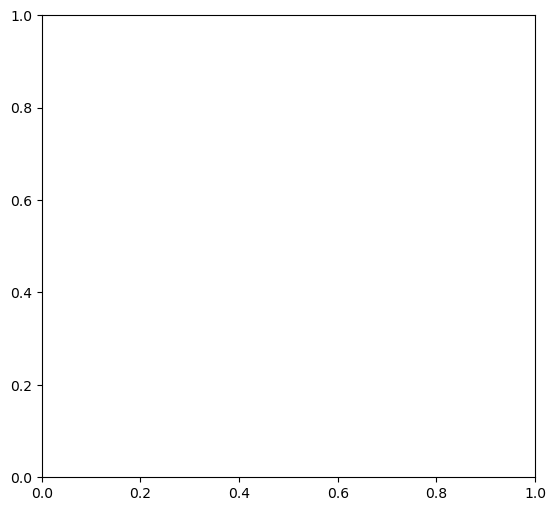

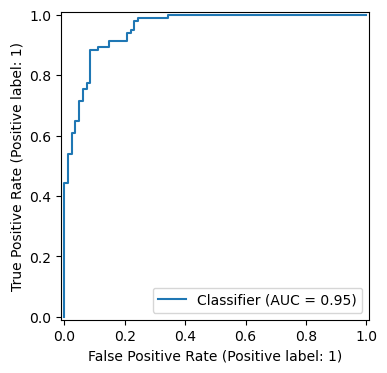

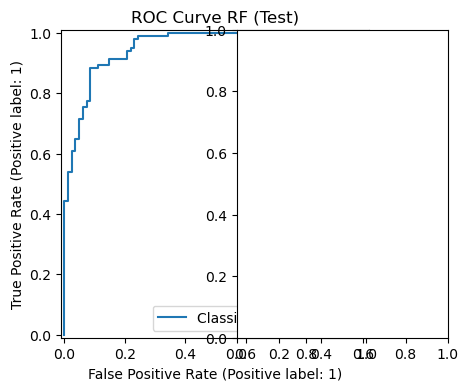

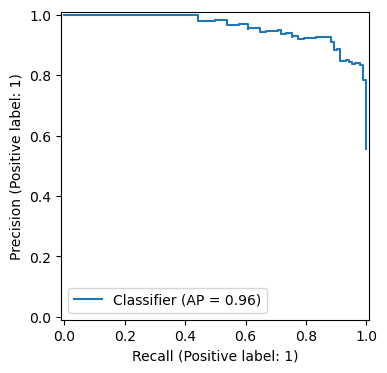

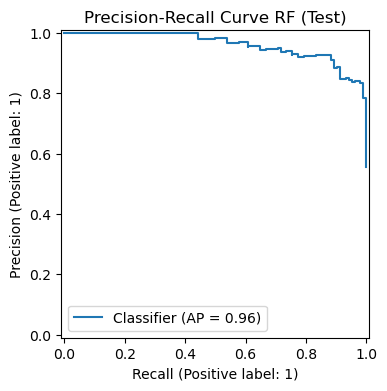

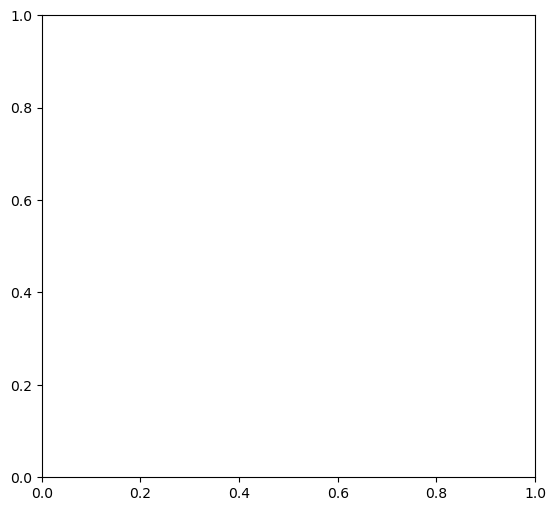

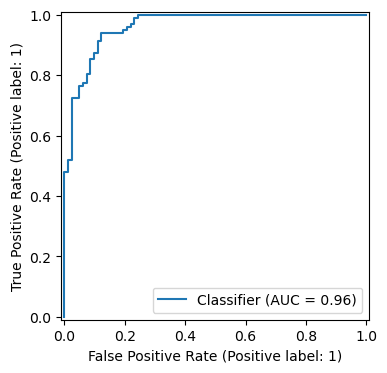

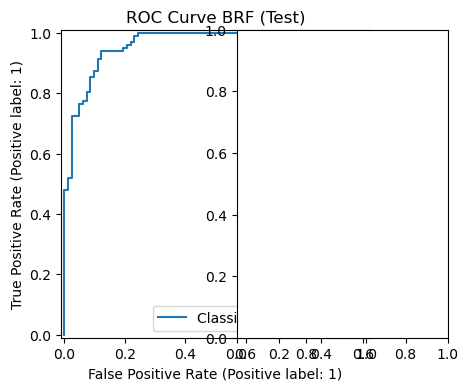

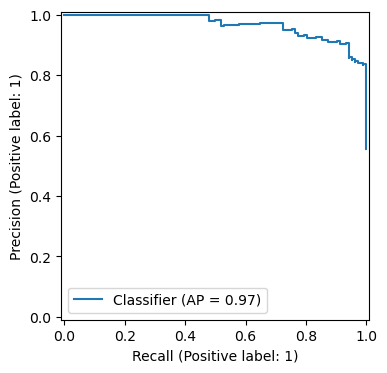

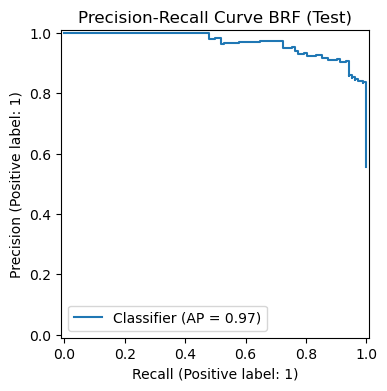

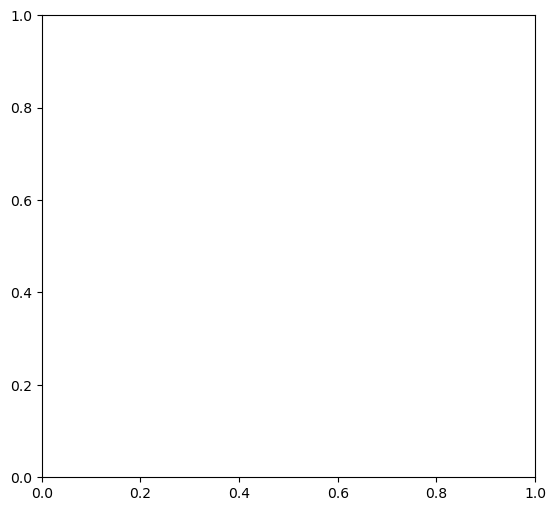

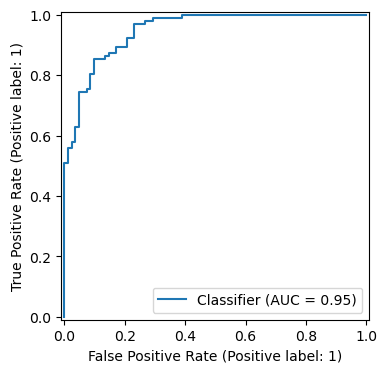

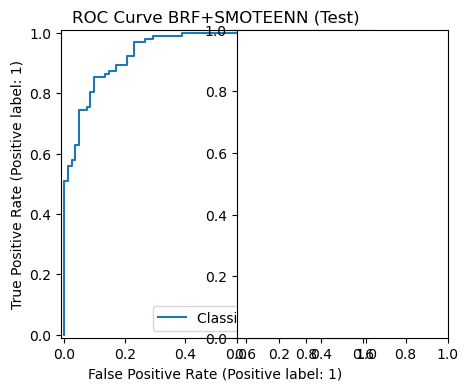

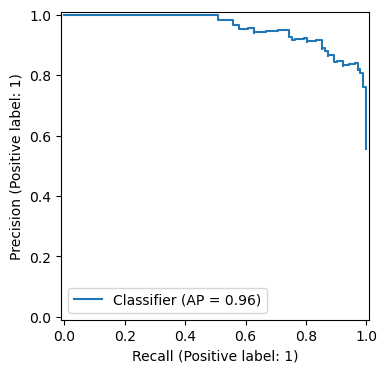

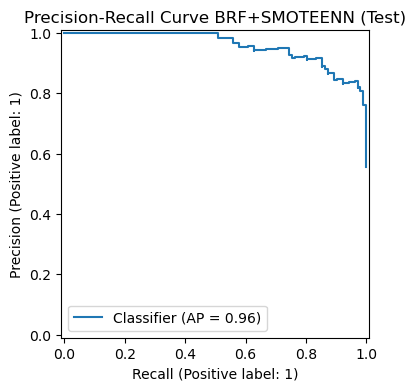

In [5]:
# ===== Block 7: AOA Optimization + Final Modeling + Evaluation (max_iter=10,popsize=16) =====

def aoa_optimize_rf_simple(X, y, num_cols, cat_cols, max_iter=10, pop_size=16, seed=42):
    rng = np.random.RandomState(seed)
    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7))
        }
    def build_rf(p):
        return RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            n_jobs=-1,
            random_state=seed
        )
    def build_brf(p):
        return BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            random_state=seed,
            n_jobs=-1
        )
    def fitness(p, use_brf=False, use_sampler=False):
        if use_brf:
            estimator = build_brf(p)
            sampler = SMOTEENN(random_state=seed) if use_sampler else None
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=sampler)
        else:
            estimator = build_rf(p)
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=SMOTEENN(random_state=seed))
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        f1 = f1_score(y, oof_pred)
        recall = recall_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        precision = precision_score(y, oof_pred)
        score = 0.4 * auc + 0.4 * recall + 0.1 * f1 + 0.1 * acc
        return score, {"auc": auc, "acc": acc, "f1": f1, "recall": recall, "precision": precision}
    
    # Optimize for RF with SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_rf, best_score_rf, best_metrics_rf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=False)
            if sc > best_score_rf:
                best_rf, best_score_rf, best_metrics_rf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (RF+SMOTEENN) | Score={best_score_rf:.4f} | AUC={best_metrics_rf['auc']:.4f} | F1={best_metrics_rf['f1']:.4f} | ACC={best_metrics_rf['acc']:.4f} | Recall={best_metrics_rf['recall']:.4f}")

    # Optimize for BRF without SMOTEENN (separate loop)
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf, best_score_brf, best_metrics_brf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=False)
            if sc > best_score_brf:
                best_brf, best_score_brf, best_metrics_brf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF) | Score={best_score_brf:.4f} | AUC={best_metrics_brf['auc']:.4f} | F1={best_metrics_brf['f1']:.4f} | ACC={best_metrics_brf['acc']:.4f} | Recall={best_metrics_brf['recall']:.4f}")
    
    # Optimize for BRF with SMOTEENN (separate loop)
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=True)
            if sc > best_score_brf_smoteen:
                best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF+SMOTEENN) | Score={best_score_brf_smoteen:.4f} | AUC={best_metrics_brf_smoteen['auc']:.4f} | F1={best_metrics_brf_smoteen['f1']:.4f} | ACC={best_metrics_brf_smoteen['acc']:.4f} | Recall={best_metrics_brf_smoteen['recall']:.4f}")

    return (best_rf, best_metrics_rf), (best_brf, best_metrics_brf), (best_brf_smoteen, best_metrics_brf_smoteen)

# اجرای بهینه‌سازی پارامترها
(best_params_rf, best_mets_rf), (best_params_brf, best_mets_brf), (best_params_brf_smoteen, best_mets_brf_smoteen) = aoa_optimize_rf_simple(X, y, num_cols, cat_cols, max_iter=10, pop_size=16)

print("\nBest RF params (AOA Simple with SMOTEENN):", best_params_rf)
print("Best (AOA Simple with SMOTEENN) metrics (CV 10x1):", best_mets_rf)

print("\nBest BRF params (AOA Simple without SMOTEENN):", best_params_brf)
print("Best (AOA Simple without SMOTEENN) metrics (CV 10x1):", best_mets_brf)

print("\nBest BRF params (AOA Simple with SMOTEENN):", best_params_brf_smoteen)
print("Best (AOA Simple with SMOTEENN) metrics (CV 10x1):", best_mets_brf_smoteen)

# ساخت مدل‌ها با پارامتر بهتر و pipeline
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
pipe_final = build_pipeline(rf_final, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

brf_final = BalancedRandomForestClassifier(**best_params_brf, random_state=42, n_jobs=-1)
pipe_brf = build_pipeline(brf_final, num_cols, cat_cols, sampler=None)

brf_final_smoteen = BalancedRandomForestClassifier(**best_params_brf_smoteen, random_state=42, n_jobs=-1)
pipe_brf_smoteen = build_pipeline(brf_final_smoteen, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

# تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# آموزش مدل‌ها
pipe_final.fit(X_train, y_train)
pipe_brf.fit(X_train, y_train)
pipe_brf_smoteen.fit(X_train, y_train)

# تابع محاسبه متریک روی train (OOF)
def calc_metrics(pipe, X, y):
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                             method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }

# محاسبه متریک روی داده آموزش (train)
metrics_train_rf = calc_metrics(pipe_final, X_train, y_train)
metrics_train_brf = calc_metrics(pipe_brf, X_train, y_train)
metrics_train_brf_smoteen = calc_metrics(pipe_brf_smoteen, X_train, y_train)

# تابع محاسبه متریک و خروجی احتمال روی test
def calc_metrics_test(pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

# محاسبه متریک و احتمال روی داده تست (test)
metrics_test_rf, proba_test_rf = calc_metrics_test(pipe_final, X_test, y_test)
metrics_test_brf, proba_test_brf = calc_metrics_test(pipe_brf, X_test, y_test)
metrics_test_brf_smoteen, proba_test_brf_smoteen = calc_metrics_test(pipe_brf_smoteen, X_test, y_test)

# چاپ متریک‌ها (دسته‌بندی)
print("\nFinal RF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal RF+SMOTEENN (Test):")
for k, v in metrics_test_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Train/Oof):")
for k, v in metrics_train_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Test):")
for k, v in metrics_test_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Test):")
for k, v in metrics_test_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

# رسم نمودار ROC و Precision-Recall فقط روی داده تست
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("ROC Curve RF (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("Precision-Recall Curve RF (Test)")

plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("ROC Curve BRF (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("Precision-Recall Curve BRF (Test)")

plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("ROC Curve BRF+SMOTEENN (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("Precision-Recall Curve BRF+SMOTEENN (Test)")

plt.show()


Iter 1/10 (RF+SMOTEENN) | Score=0.8977 | AUC=0.9205 | F1=0.8722 | ACC=0.8554 | Recall=0.8919
Iter 2/10 (RF+SMOTEENN) | Score=0.8977 | AUC=0.9205 | F1=0.8722 | ACC=0.8554 | Recall=0.8919
Iter 3/10 (RF+SMOTEENN) | Score=0.8977 | AUC=0.9205 | F1=0.8722 | ACC=0.8554 | Recall=0.8919
Iter 4/10 (RF+SMOTEENN) | Score=0.8977 | AUC=0.9205 | F1=0.8722 | ACC=0.8554 | Recall=0.8919
Iter 5/10 (RF+SMOTEENN) | Score=0.8977 | AUC=0.9205 | F1=0.8722 | ACC=0.8554 | Recall=0.8919
Iter 6/10 (RF+SMOTEENN) | Score=0.8990 | AUC=0.9227 | F1=0.8739 | ACC=0.8576 | Recall=0.8919
Iter 7/10 (RF+SMOTEENN) | Score=0.8990 | AUC=0.9227 | F1=0.8739 | ACC=0.8576 | Recall=0.8919
Iter 8/10 (RF+SMOTEENN) | Score=0.8990 | AUC=0.9227 | F1=0.8739 | ACC=0.8576 | Recall=0.8919
Iter 9/10 (RF+SMOTEENN) | Score=0.8991 | AUC=0.9224 | F1=0.8748 | ACC=0.8587 | Recall=0.8919
Iter 10/10 (RF+SMOTEENN) | Score=0.9012 | AUC=0.9237 | F1=0.8752 | ACC=0.8587 | Recall=0.8959
Iter 1/10 (BRF) | Score=0.9237 | AUC=0.9440 | F1=0.8950 | ACC=0.8804 

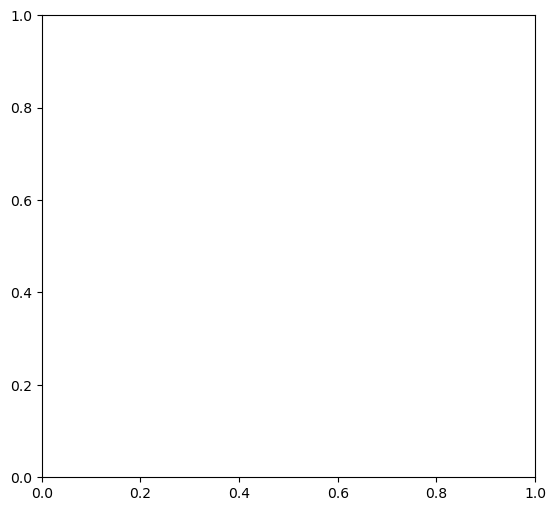

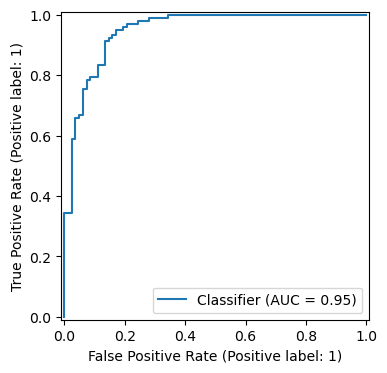

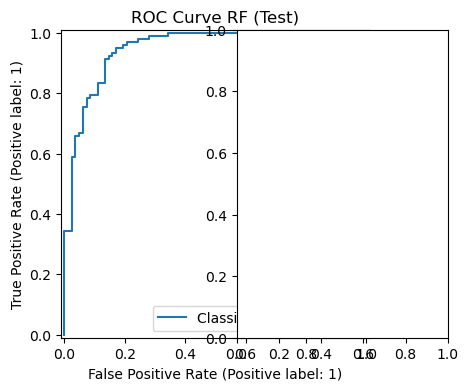

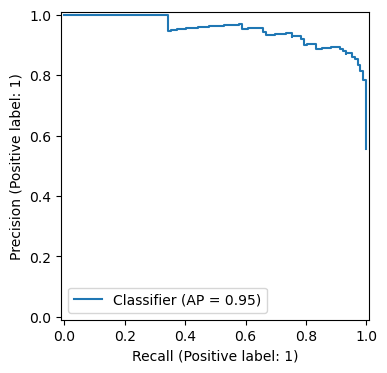

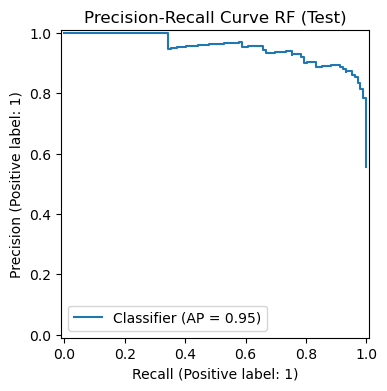

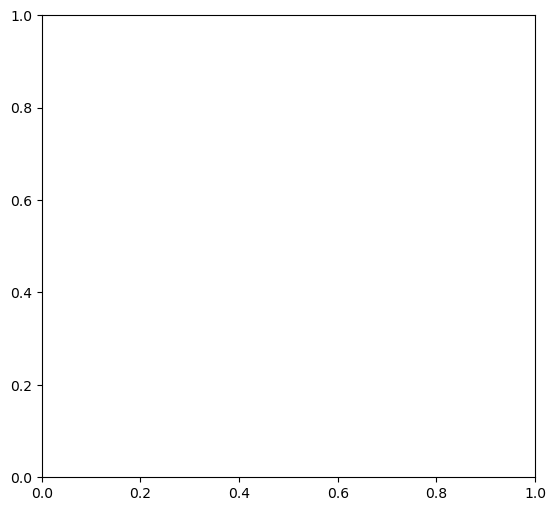

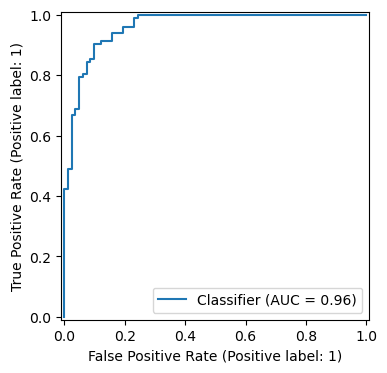

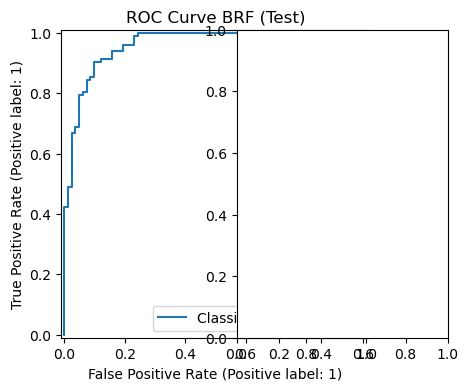

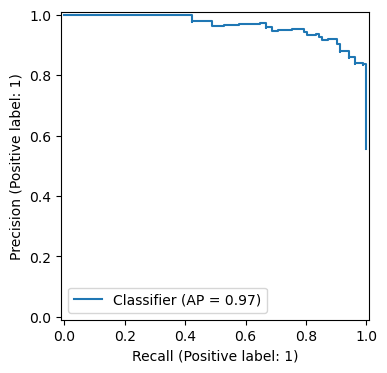

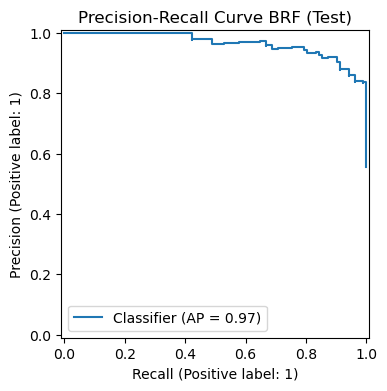

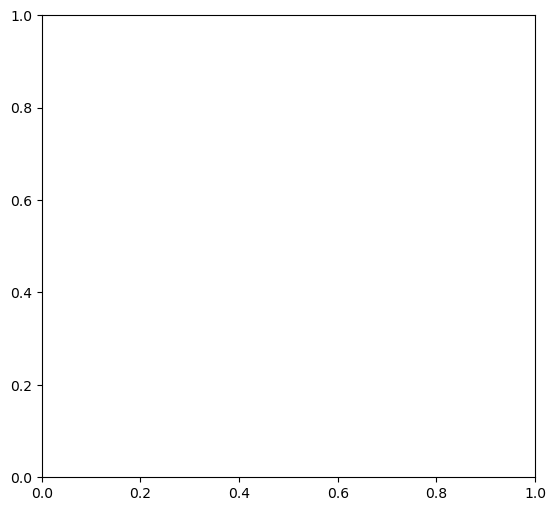

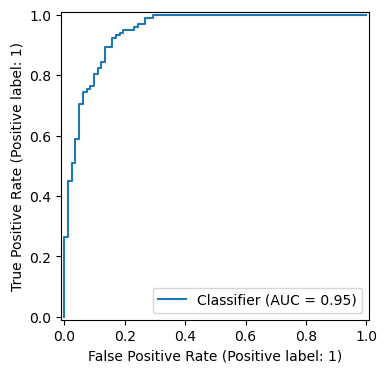

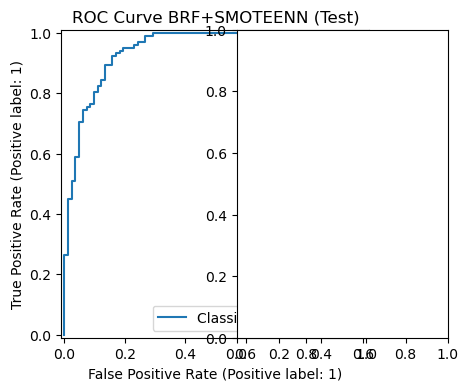

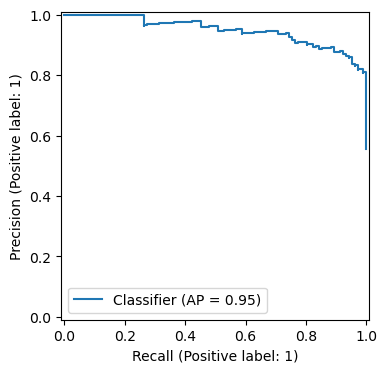

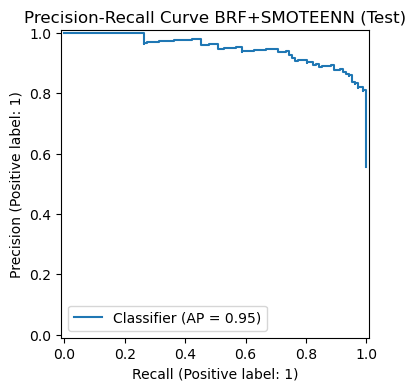

In [6]:
# ===== Block 8: AOA++ Optimization + Final Modeling + Evaluation (max_iter=10, pop_size=16) =====


def aoa_optimize_rf_plusplus(X, y, num_cols, cat_cols, max_iter=10, pop_size=16, seed=42):
    rng = np.random.RandomState(seed)
    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7)),
            "max_features": rng.choice(['sqrt', 'log2', None]),
            "bootstrap": bool(rng.randint(0,2)),
            "class_weight": rng.choice([None, 'balanced'])
        }
    def build_rf(p):
        return RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            bootstrap=p["bootstrap"],
            class_weight=p["class_weight"],
            n_jobs=-1,
            random_state=seed
        )
    def build_brf(p):
        # class_weight و bootstrap در BRF پشتیبانی نمی‌شود
        return BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            random_state=seed,
            n_jobs=-1
        )
    def fitness(p, use_brf=False, use_sampler=False):
        if use_brf:
            estimator = build_brf(p)
            sampler = SMOTEENN(random_state=seed) if use_sampler else None
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=sampler)
        else:
            estimator = build_rf(p)
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=SMOTEENN(random_state=seed))
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        f1 = f1_score(y, oof_pred)
        recall = recall_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        precision = precision_score(y, oof_pred)
        score = 0.4 * auc + 0.4 * recall + 0.1 * f1 + 0.1 * acc
        return score, {"auc": auc, "acc": acc, "f1": f1, "recall": recall, "precision": precision}

    # RF+SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_rf, best_score_rf, best_metrics_rf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            if rng.rand() < 0.3:
                c["bootstrap"] = not c["bootstrap"]
            if rng.rand() < 0.3:
                c["class_weight"] = rng.choice([None, "balanced"])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=False)
            if sc > best_score_rf:
                best_rf, best_score_rf, best_metrics_rf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (RF+SMOTEENN) | Score={best_score_rf:.4f} | AUC={best_metrics_rf['auc']:.4f} | F1={best_metrics_rf['f1']:.4f} | ACC={best_metrics_rf['acc']:.4f} | Recall={best_metrics_rf['recall']:.4f}")

    # BRF بدون SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf, best_score_brf, best_metrics_brf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=False)
            if sc > best_score_brf:
                best_brf, best_score_brf, best_metrics_brf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF) | Score={best_score_brf:.4f} | AUC={best_metrics_brf['auc']:.4f} | F1={best_metrics_brf['f1']:.4f} | ACC={best_metrics_brf['acc']:.4f} | Recall={best_metrics_brf['recall']:.4f}")

    # BRF+SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=True)
            if sc > best_score_brf_smoteen:
                best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF+SMOTEENN) | Score={best_score_brf_smoteen:.4f} | AUC={best_metrics_brf_smoteen['auc']:.4f} | F1={best_metrics_brf_smoteen['f1']:.4f} | ACC={best_metrics_brf_smoteen['acc']:.4f} | Recall={best_metrics_brf_smoteen['recall']:.4f}")

    return (best_rf, best_metrics_rf), (best_brf, best_metrics_brf), (best_brf_smoteen, best_metrics_brf_smoteen)

# اجرای بهینه‌سازی پارامترها به روش پیشرفته‌تر (AOA++)
(best_params_rf, best_mets_rf), (best_params_brf, best_mets_brf), (best_params_brf_smoteen, best_mets_brf_smoteen) = aoa_optimize_rf_plusplus(X, y, num_cols, cat_cols, max_iter=10, pop_size=16)

print("\nBest RF params (AOA++):", best_params_rf)
print("Best (AOA++) metrics (CV 10x1):", best_mets_rf)

print("\nBest BRF params (AOA++):", best_params_brf)
print("Best (AOA++) metrics (CV 10x1):", best_mets_brf)

print("\nBest BRF+SMOTEENN params (AOA++):", best_params_brf_smoteen)
print("Best (AOA++ with SMOTEENN) metrics (CV 10x1):", best_mets_brf_smoteen)

# ساخت مدل‌ها با پارامتر بهتر و pipeline
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
pipe_final = build_pipeline(rf_final, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

brf_final = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf = build_pipeline(brf_final, num_cols, cat_cols, sampler=None)

brf_final_smoteen = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf_smoteen.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf_smoteen = build_pipeline(brf_final_smoteen, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe_final.fit(X_train, y_train)
pipe_brf.fit(X_train, y_train)
pipe_brf_smoteen.fit(X_train, y_train)

# تابع و چاپ متریک‌ها مشابه نسخه ساده (کپی از کد قبلی)
def calc_metrics(pipe, X, y):
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                             method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }

metrics_train_rf = calc_metrics(pipe_final, X_train, y_train)
metrics_train_brf = calc_metrics(pipe_brf, X_train, y_train)
metrics_train_brf_smoteen = calc_metrics(pipe_brf_smoteen, X_train, y_train)

def calc_metrics_test(pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

metrics_test_rf, proba_test_rf = calc_metrics_test(pipe_final, X_test, y_test)
metrics_test_brf, proba_test_brf = calc_metrics_test(pipe_brf, X_test, y_test)
metrics_test_brf_smoteen, proba_test_brf_smoteen = calc_metrics_test(pipe_brf_smoteen, X_test, y_test)

# چاپ بلوکی و دسته‌بندی حرفه‌ای
print("\nFinal RF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal RF+SMOTEENN (Test):")
for k, v in metrics_test_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Train/Oof):")
for k, v in metrics_train_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Test):")
for k, v in metrics_test_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Test):")
for k, v in metrics_test_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

# رسم نمودارهای ROC و PR برای test
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("ROC Curve RF (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("Precision-Recall Curve RF (Test)")
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("ROC Curve BRF (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("Precision-Recall Curve BRF (Test)")
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("ROC Curve BRF+SMOTEENN (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("Precision-Recall Curve BRF+SMOTEENN (Test)")
plt.show()


Iter 1/15 (RF+SMOTEENN) | Score=0.8838 | AUC=0.9181 | F1=0.8549 | ACC=0.8370 | Recall=0.8684
Iter 2/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 3/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 4/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 5/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 6/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 7/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 8/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 9/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 10/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | ACC=0.8380 | Recall=0.8664
Iter 11/15 (RF+SMOTEENN) | Score=0.8841 | AUC=0.9205 | F1=0.8555 | AC

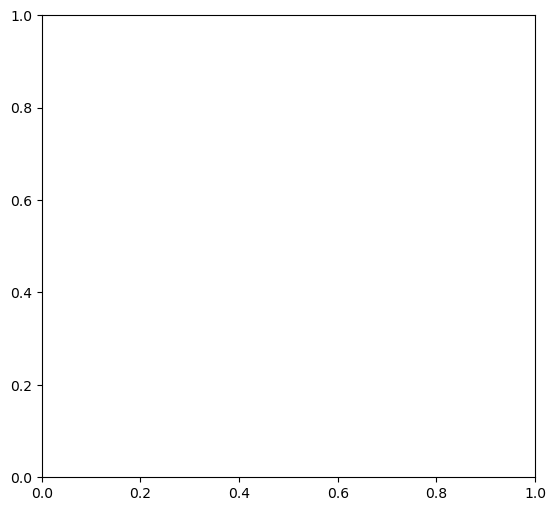

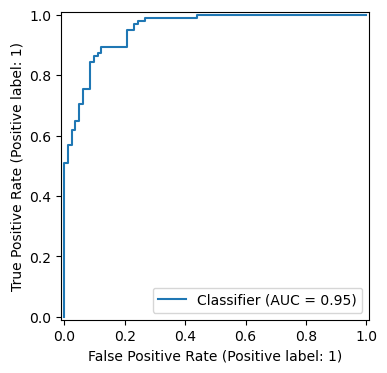

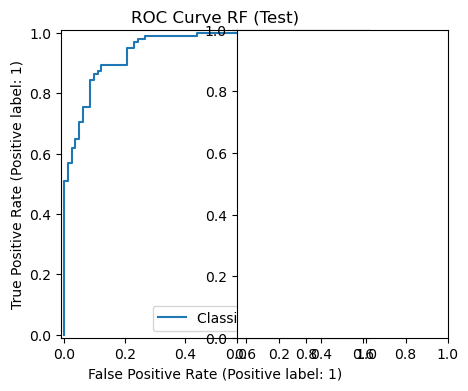

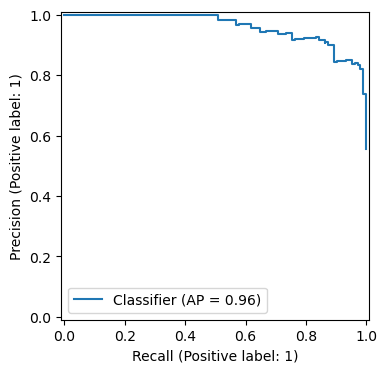

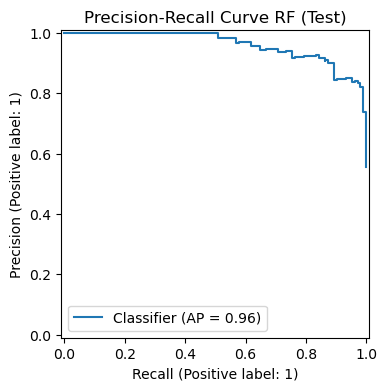

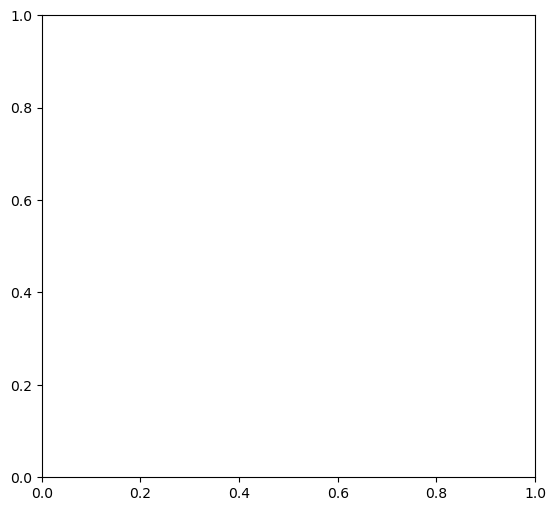

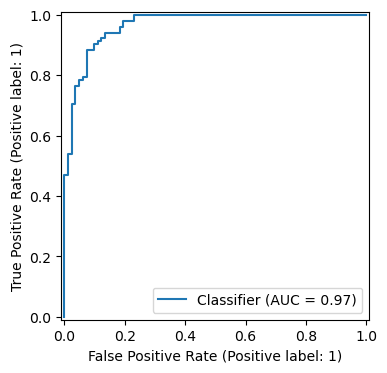

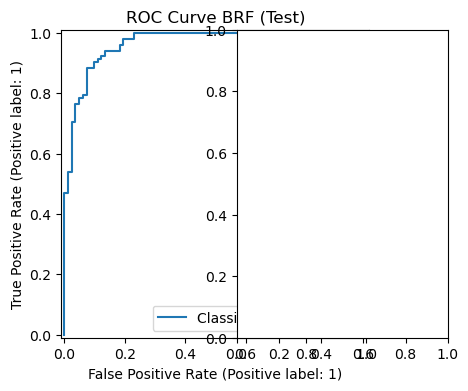

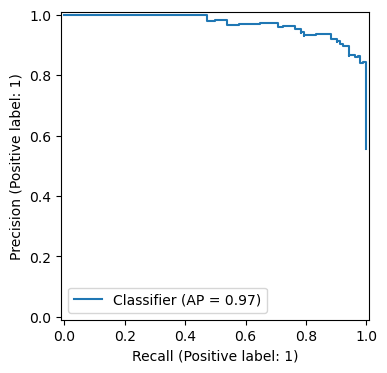

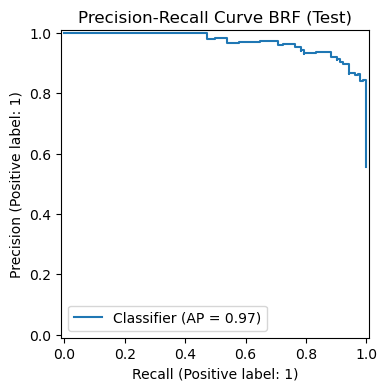

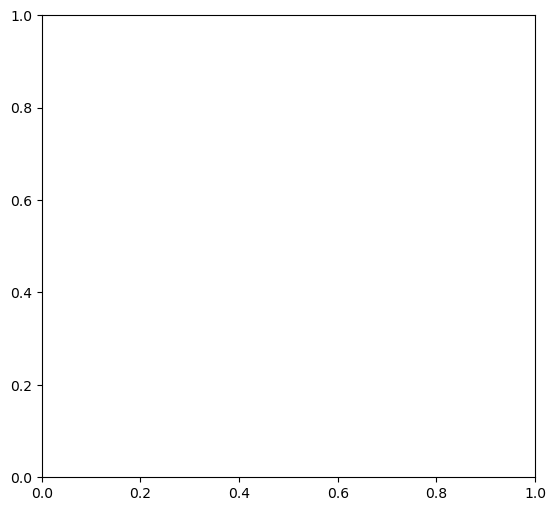

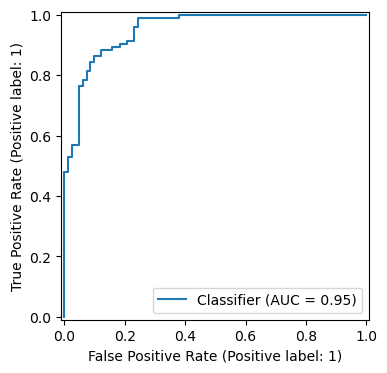

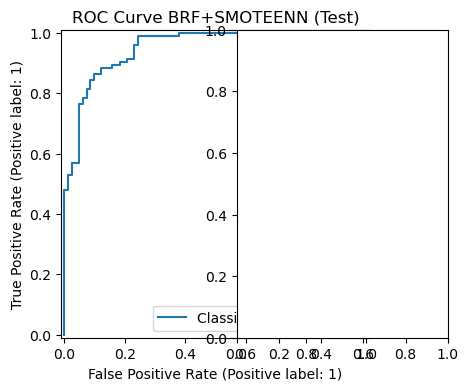

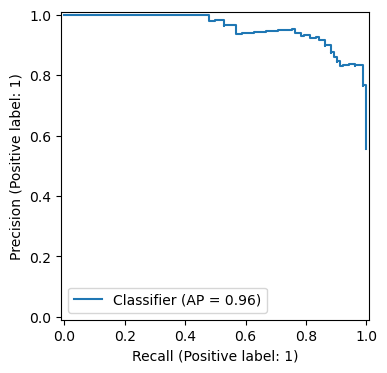

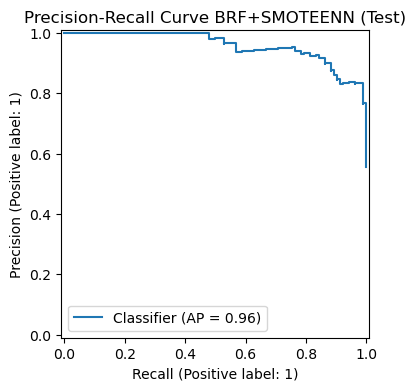

In [8]:
# ===== Block 9: AOA Optimization + Final Modeling + Evaluation (max_iter=15, pop_size=24) =====

def aoa_optimize_rf_simple(X, y, num_cols, cat_cols, max_iter=15, pop_size=24, seed=42):
    rng = np.random.RandomState(seed)
    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7))
        }
    def build_rf(p):
        return RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            n_jobs=-1,
            random_state=seed
        )
    def build_brf(p):
        return BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            random_state=seed,
            n_jobs=-1
        )
    def fitness(p, use_brf=False, use_sampler=False):
        if use_brf:
            estimator = build_brf(p)
            sampler = SMOTEENN(random_state=seed) if use_sampler else None
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=sampler)
        else:
            estimator = build_rf(p)
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=SMOTEENN(random_state=seed))
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        f1 = f1_score(y, oof_pred)
        recall = recall_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        precision = precision_score(y, oof_pred)
        score = 0.4 * auc + 0.4 * recall + 0.1 * f1 + 0.1 * acc
        return score, {"auc": auc, "acc": acc, "f1": f1, "recall": recall, "precision": precision}
    
    # Optimize for RF with SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_rf, best_score_rf, best_metrics_rf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=False)
            if sc > best_score_rf:
                best_rf, best_score_rf, best_metrics_rf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (RF+SMOTEENN) | Score={best_score_rf:.4f} | AUC={best_metrics_rf['auc']:.4f} | F1={best_metrics_rf['f1']:.4f} | ACC={best_metrics_rf['acc']:.4f} | Recall={best_metrics_rf['recall']:.4f}")

    # Optimize for BRF without SMOTEENN (separate loop)
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf, best_score_brf, best_metrics_brf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=False)
            if sc > best_score_brf:
                best_brf, best_score_brf, best_metrics_brf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF) | Score={best_score_brf:.4f} | AUC={best_metrics_brf['auc']:.4f} | F1={best_metrics_brf['f1']:.4f} | ACC={best_metrics_brf['acc']:.4f} | Recall={best_metrics_brf['recall']:.4f}")
    
    # Optimize for BRF with SMOTEENN (separate loop)
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=True)
            if sc > best_score_brf_smoteen:
                best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF+SMOTEENN) | Score={best_score_brf_smoteen:.4f} | AUC={best_metrics_brf_smoteen['auc']:.4f} | F1={best_metrics_brf_smoteen['f1']:.4f} | ACC={best_metrics_brf_smoteen['acc']:.4f} | Recall={best_metrics_brf_smoteen['recall']:.4f}")

    return (best_rf, best_metrics_rf), (best_brf, best_metrics_brf), (best_brf_smoteen, best_metrics_brf_smoteen)

# اجرای بهینه‌سازی پارامترها
(best_params_rf, best_mets_rf), (best_params_brf, best_mets_brf), (best_params_brf_smoteen, best_mets_brf_smoteen) = aoa_optimize_rf_simple(X, y, num_cols, cat_cols, max_iter=15, pop_size=24)

print("\nBest RF params (AOA Simple with SMOTEENN):", best_params_rf)
print("Best (AOA Simple with SMOTEENN) metrics (CV 10x1):", best_mets_rf)

print("\nBest BRF params (AOA Simple without SMOTEENN):", best_params_brf)
print("Best (AOA Simple without SMOTEENN) metrics (CV 10x1):", best_mets_brf)

print("\nBest BRF params (AOA Simple with SMOTEENN):", best_params_brf_smoteen)
print("Best (AOA Simple with SMOTEENN) metrics (CV 10x1):", best_mets_brf_smoteen)

# ساخت مدل‌ها با پارامتر بهتر و pipeline
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
pipe_final = build_pipeline(rf_final, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

brf_final = BalancedRandomForestClassifier(**best_params_brf, random_state=42, n_jobs=-1)
pipe_brf = build_pipeline(brf_final, num_cols, cat_cols, sampler=None)

brf_final_smoteen = BalancedRandomForestClassifier(**best_params_brf_smoteen, random_state=42, n_jobs=-1)
pipe_brf_smoteen = build_pipeline(brf_final_smoteen, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

# تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# آموزش مدل‌ها
pipe_final.fit(X_train, y_train)
pipe_brf.fit(X_train, y_train)
pipe_brf_smoteen.fit(X_train, y_train)

# تابع محاسبه متریک روی train (OOF)
def calc_metrics(pipe, X, y):
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                             method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }

# محاسبه متریک روی داده آموزش (train)
metrics_train_rf = calc_metrics(pipe_final, X_train, y_train)
metrics_train_brf = calc_metrics(pipe_brf, X_train, y_train)
metrics_train_brf_smoteen = calc_metrics(pipe_brf_smoteen, X_train, y_train)

# تابع محاسبه متریک و خروجی احتمال روی test
def calc_metrics_test(pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

# محاسبه متریک و احتمال روی داده تست (test)
metrics_test_rf, proba_test_rf = calc_metrics_test(pipe_final, X_test, y_test)
metrics_test_brf, proba_test_brf = calc_metrics_test(pipe_brf, X_test, y_test)
metrics_test_brf_smoteen, proba_test_brf_smoteen = calc_metrics_test(pipe_brf_smoteen, X_test, y_test)

# چاپ متریک‌ها (دسته‌بندی)
print("\nFinal RF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal RF+SMOTEENN (Test):")
for k, v in metrics_test_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Train/Oof):")
for k, v in metrics_train_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Test):")
for k, v in metrics_test_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Test):")
for k, v in metrics_test_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

# رسم نمودار ROC و Precision-Recall فقط روی داده تست
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("ROC Curve RF (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("Precision-Recall Curve RF (Test)")

plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("ROC Curve BRF (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("Precision-Recall Curve BRF (Test)")

plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("ROC Curve BRF+SMOTEENN (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("Precision-Recall Curve BRF+SMOTEENN (Test)")

plt.show()


Iter 1/15 (RF+SMOTEENN) | Score=0.8971 | AUC=0.9214 | F1=0.8712 | ACC=0.8543 | Recall=0.8900
Iter 2/15 (RF+SMOTEENN) | Score=0.8971 | AUC=0.9214 | F1=0.8712 | ACC=0.8543 | Recall=0.8900
Iter 3/15 (RF+SMOTEENN) | Score=0.8971 | AUC=0.9214 | F1=0.8712 | ACC=0.8543 | Recall=0.8900
Iter 4/15 (RF+SMOTEENN) | Score=0.8971 | AUC=0.9214 | F1=0.8712 | ACC=0.8543 | Recall=0.8900
Iter 5/15 (RF+SMOTEENN) | Score=0.8971 | AUC=0.9214 | F1=0.8712 | ACC=0.8543 | Recall=0.8900
Iter 6/15 (RF+SMOTEENN) | Score=0.8971 | AUC=0.9214 | F1=0.8712 | ACC=0.8543 | Recall=0.8900
Iter 7/15 (RF+SMOTEENN) | Score=0.9005 | AUC=0.9193 | F1=0.8763 | ACC=0.8598 | Recall=0.8978
Iter 8/15 (RF+SMOTEENN) | Score=0.9023 | AUC=0.9230 | F1=0.8780 | ACC=0.8620 | Recall=0.8978
Iter 9/15 (RF+SMOTEENN) | Score=0.9023 | AUC=0.9230 | F1=0.8780 | ACC=0.8620 | Recall=0.8978
Iter 10/15 (RF+SMOTEENN) | Score=0.9023 | AUC=0.9230 | F1=0.8780 | ACC=0.8620 | Recall=0.8978
Iter 11/15 (RF+SMOTEENN) | Score=0.9023 | AUC=0.9230 | F1=0.8780 | AC

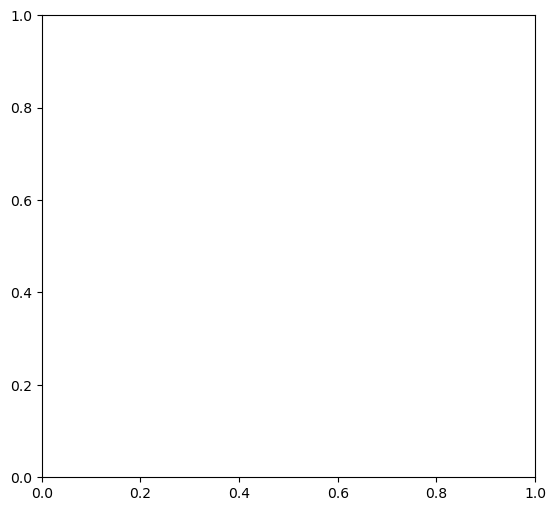

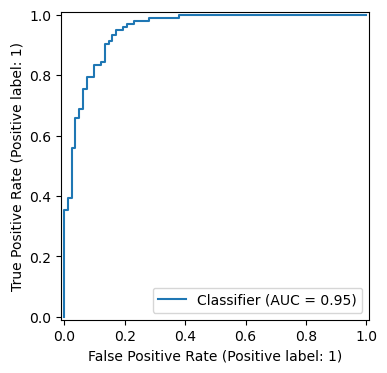

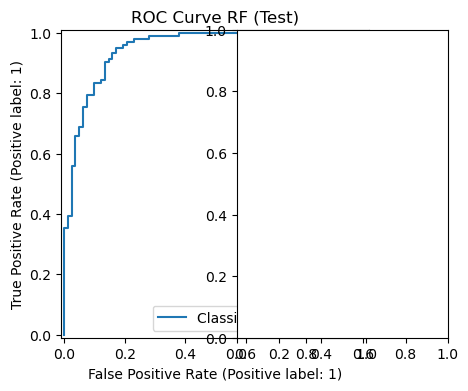

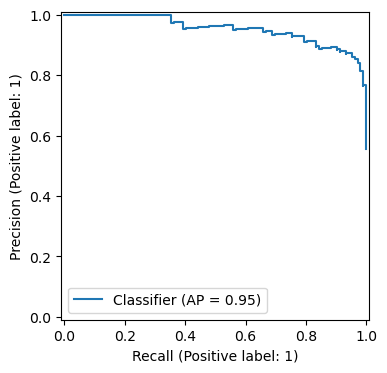

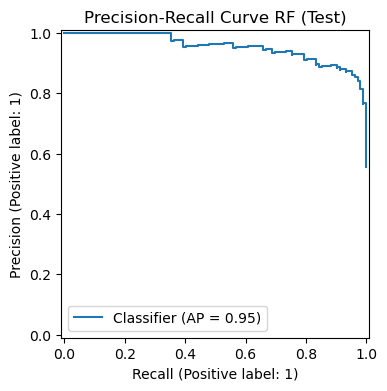

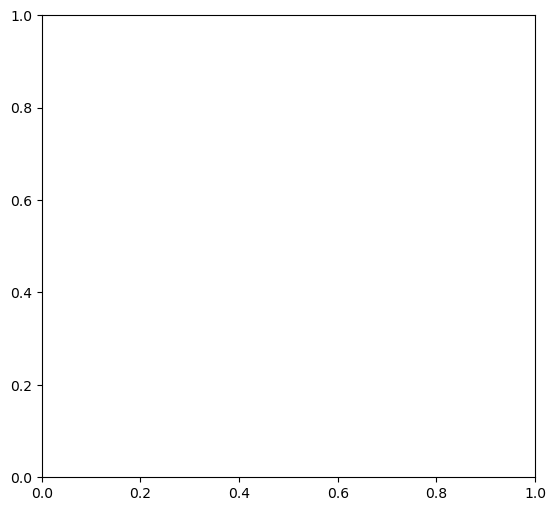

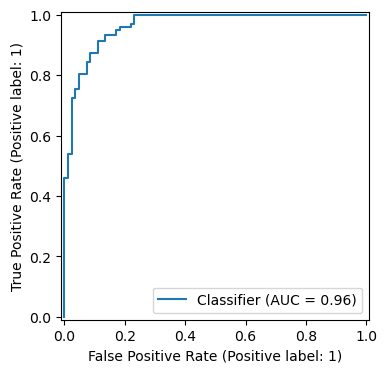

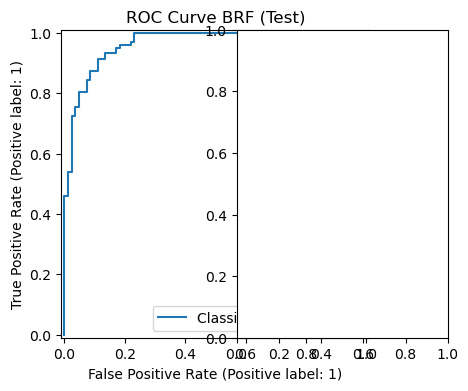

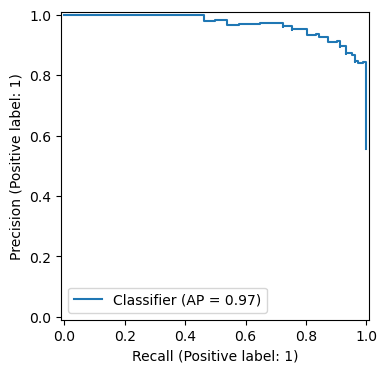

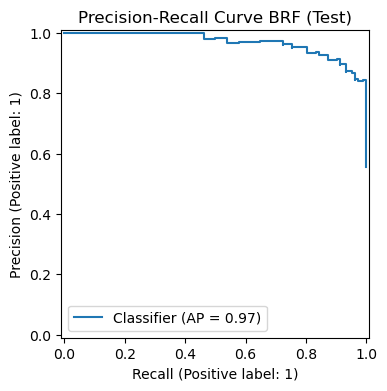

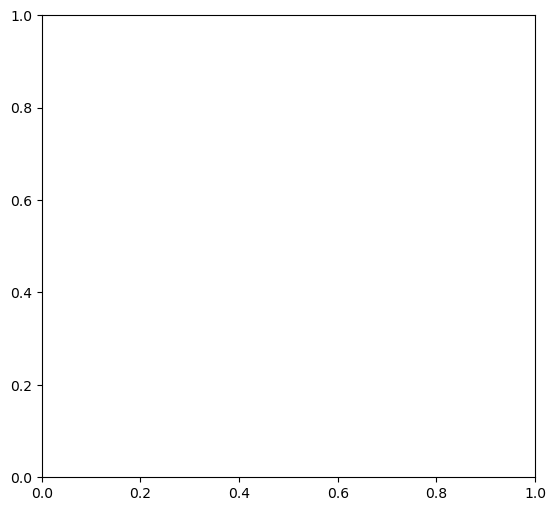

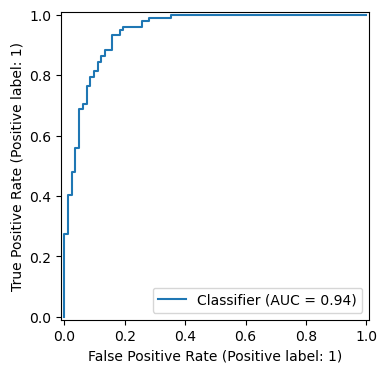

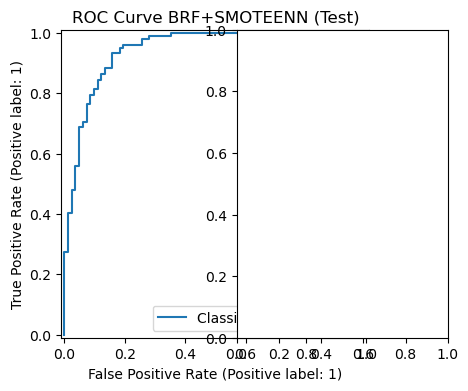

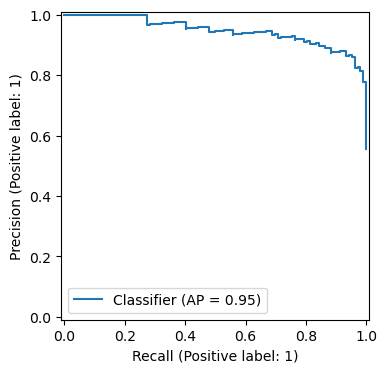

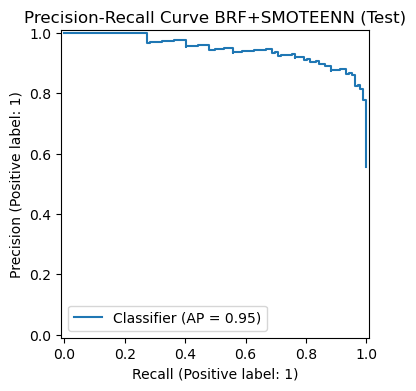

In [9]:
# ===== Block 10: AOA++ Optimization + Final Modeling + Evaluation (max_iter=15, pop_size=24) =====

def aoa_optimize_rf_plusplus(X, y, num_cols, cat_cols, max_iter=15, pop_size=24, seed=42):
    rng = np.random.RandomState(seed)
    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7)),
            "max_features": rng.choice(['sqrt', 'log2', None]),
            "bootstrap": bool(rng.randint(0,2)),
            "class_weight": rng.choice([None, 'balanced'])
        }
    def build_rf(p):
        return RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            bootstrap=p["bootstrap"],
            class_weight=p["class_weight"],
            n_jobs=-1,
            random_state=seed
        )
    def build_brf(p):
        return BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            random_state=seed,
            n_jobs=-1
        )
    def fitness(p, use_brf=False, use_sampler=False):
        if use_brf:
            estimator = build_brf(p)
            sampler = SMOTEENN(random_state=seed) if use_sampler else None
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=sampler)
        else:
            estimator = build_rf(p)
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=SMOTEENN(random_state=seed))
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        f1 = f1_score(y, oof_pred)
        recall = recall_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        precision = precision_score(y, oof_pred)
        score = 0.4 * auc + 0.4 * recall + 0.1 * f1 + 0.1 * acc
        return score, {"auc": auc, "acc": acc, "f1": f1, "recall": recall, "precision": precision}
    
    # Optimize for RF with SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_rf, best_score_rf, best_metrics_rf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            if rng.rand() < 0.3:
                c["bootstrap"] = not c["bootstrap"]
            if rng.rand() < 0.3:
                c["class_weight"] = rng.choice([None, "balanced"])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=False)
            if sc > best_score_rf:
                best_rf, best_score_rf, best_metrics_rf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (RF+SMOTEENN) | Score={best_score_rf:.4f} | AUC={best_metrics_rf['auc']:.4f} | F1={best_metrics_rf['f1']:.4f} | ACC={best_metrics_rf['acc']:.4f} | Recall={best_metrics_rf['recall']:.4f}")

    # Optimize for BRF without SMOTEENN (separate loop)
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf, best_score_brf, best_metrics_brf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=False)
            if sc > best_score_brf:
                best_brf, best_score_brf, best_metrics_brf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF) | Score={best_score_brf:.4f} | AUC={best_metrics_brf['auc']:.4f} | F1={best_metrics_brf['f1']:.4f} | ACC={best_metrics_brf['acc']:.4f} | Recall={best_metrics_brf['recall']:.4f}")
    
    # Optimize for BRF with SMOTEENN (separate loop)
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=True)
            if sc > best_score_brf_smoteen:
                best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF+SMOTEENN) | Score={best_score_brf_smoteen:.4f} | AUC={best_metrics_brf_smoteen['auc']:.4f} | F1={best_metrics_brf_smoteen['f1']:.4f} | ACC={best_metrics_brf_smoteen['acc']:.4f} | Recall={best_metrics_brf_smoteen['recall']:.4f}")

    return (best_rf, best_metrics_rf), (best_brf, best_metrics_brf), (best_brf_smoteen, best_metrics_brf_smoteen)

# اجرای بهینه‌سازی پارامترها
(best_params_rf, best_mets_rf), (best_params_brf, best_mets_brf), (best_params_brf_smoteen, best_mets_brf_smoteen) = aoa_optimize_rf_plusplus(X, y, num_cols, cat_cols, max_iter=15, pop_size=24)

print("\nBest RF params (AOA++ with SMOTEENN):", best_params_rf)
print("Best (AOA++ with SMOTEENN) metrics (CV 10x1):", best_mets_rf)

print("\nBest BRF params (AOA++ without SMOTEENN):", best_params_brf)
print("Best (AOA++ without SMOTEENN) metrics (CV 10x1):", best_mets_brf)

print("\nBest BRF params (AOA++ with SMOTEENN):", best_params_brf_smoteen)
print("Best (AOA++ with SMOTEENN) metrics (CV 10x1):", best_mets_brf_smoteen)

# ساخت مدل‌ها با پارامتر بهتر و pipeline
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
pipe_final = build_pipeline(rf_final, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

brf_final = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf = build_pipeline(brf_final, num_cols, cat_cols, sampler=None)

brf_final_smoteen = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf_smoteen.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf_smoteen = build_pipeline(brf_final_smoteen, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

# تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# آموزش مدل‌ها
pipe_final.fit(X_train, y_train)
pipe_brf.fit(X_train, y_train)
pipe_brf_smoteen.fit(X_train, y_train)

# تابع محاسبه متریک روی train (OOF)
def calc_metrics(pipe, X, y):
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                             method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }

# محاسبه متریک روی داده آموزش (train)
metrics_train_rf = calc_metrics(pipe_final, X_train, y_train)
metrics_train_brf = calc_metrics(pipe_brf, X_train, y_train)
metrics_train_brf_smoteen = calc_metrics(pipe_brf_smoteen, X_train, y_train)

# تابع محاسبه متریک و خروجی احتمال روی test
def calc_metrics_test(pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

# محاسبه متریک و احتمال روی داده تست (test)
metrics_test_rf, proba_test_rf = calc_metrics_test(pipe_final, X_test, y_test)
metrics_test_brf, proba_test_brf = calc_metrics_test(pipe_brf, X_test, y_test)
metrics_test_brf_smoteen, proba_test_brf_smoteen = calc_metrics_test(pipe_brf_smoteen, X_test, y_test)

# چاپ متریک‌ها (دسته‌بندی)
print("\nFinal RF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal RF+SMOTEENN (Test):")
for k, v in metrics_test_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Train/Oof):")
for k, v in metrics_train_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Test):")
for k, v in metrics_test_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Test):")
for k, v in metrics_test_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

# رسم نمودار ROC و Precision-Recall فقط روی داده تست
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("ROC Curve RF (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("Precision-Recall Curve RF (Test)")

plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("ROC Curve BRF (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("Precision-Recall Curve BRF (Test)")

plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("ROC Curve BRF+SMOTEENN (Test)")

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("Precision-Recall Curve BRF+SMOTEENN (Test)")

plt.show()


Iter 1/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 2/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 3/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 4/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 5/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 6/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 7/20 (RF+SMOTEENN) | Score=0.8991 | AUC=0.9223 | F1=0.8748 | ACC=0.8587 | Recall=0.8919
Iter 8/20 (RF+SMOTEENN) | Score=0.8991 | AUC=0.9223 | F1=0.8748 | ACC=0.8587 | Recall=0.8919
Iter 9/20 (RF+SMOTEENN) | Score=0.8991 | AUC=0.9223 | F1=0.8748 | ACC=0.8587 | Recall=0.8919
Iter 10/20 (RF+SMOTEENN) | Score=0.9010 | AUC=0.9198 | F1=0.8780 | ACC=0.8620 | Recall=0.8978
Iter 11/20 (RF+SMOTEENN) | Score=0.9010 | AUC=0.9198 | F1=0.8780 | AC

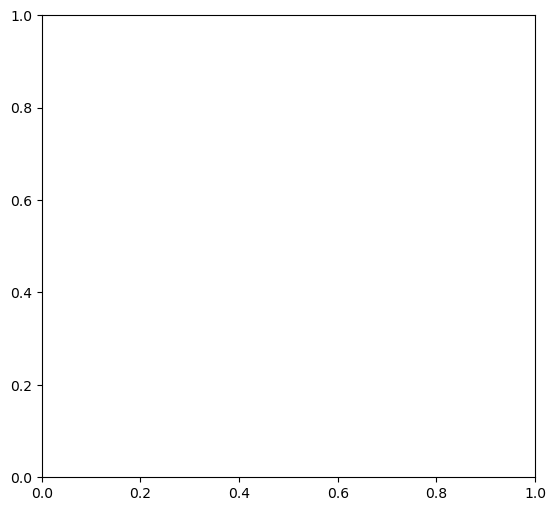

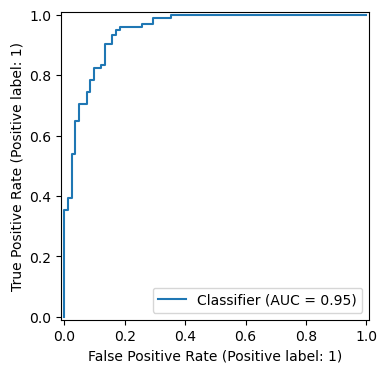

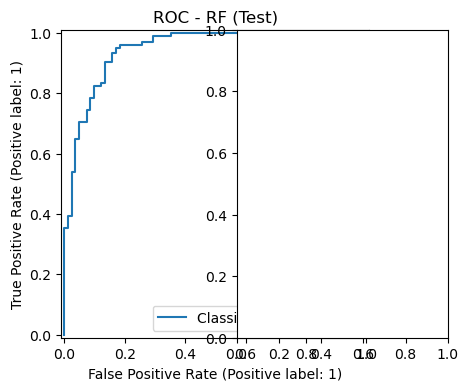

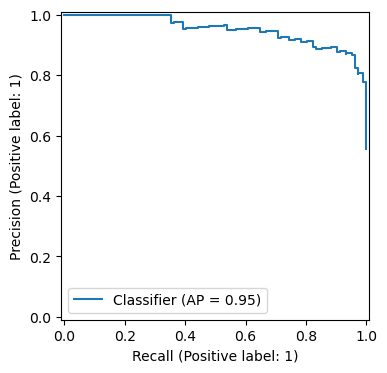

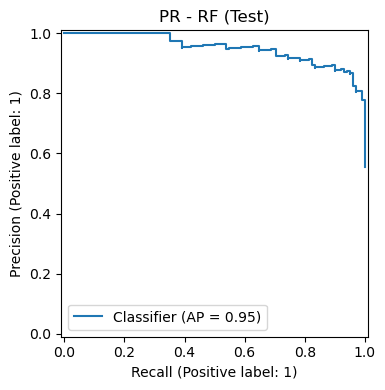

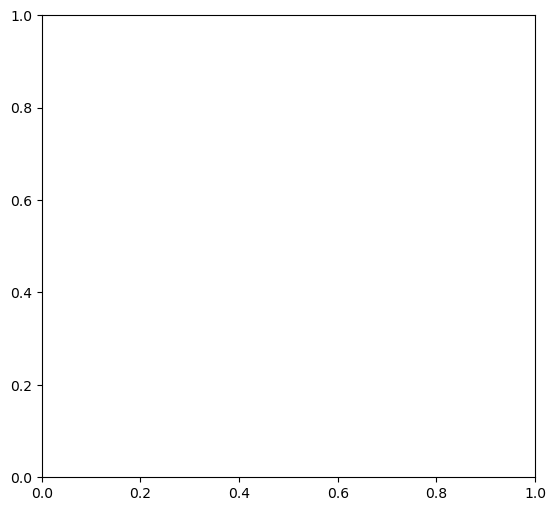

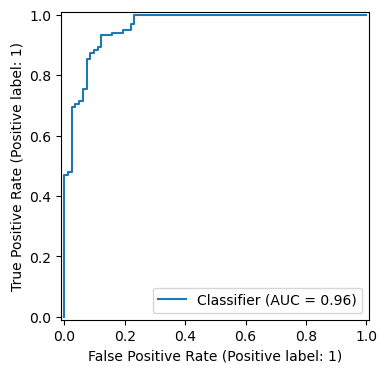

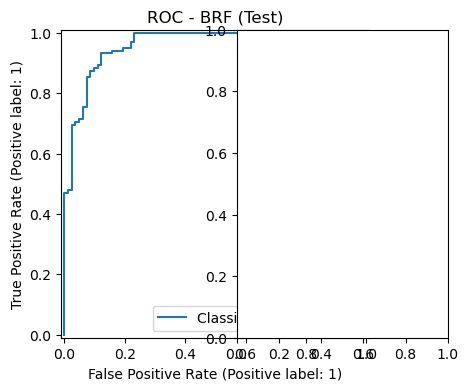

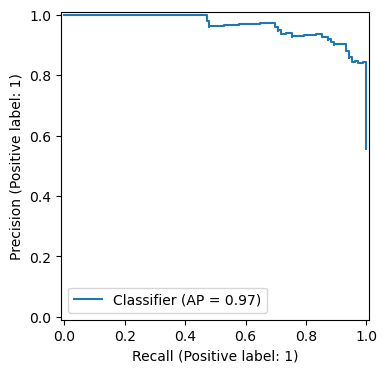

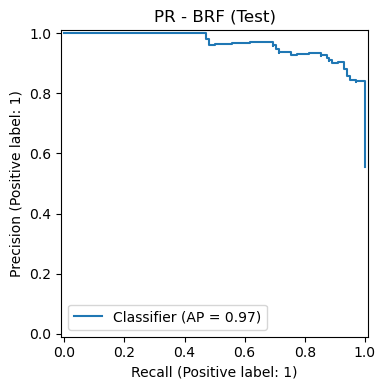

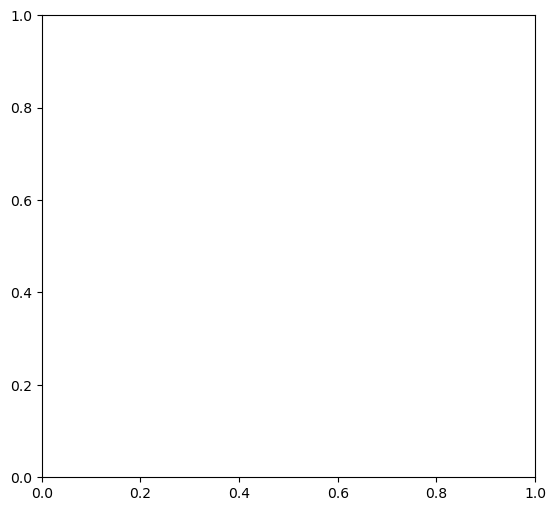

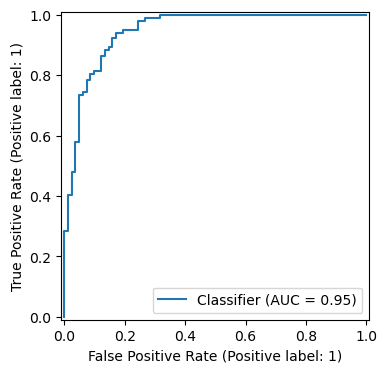

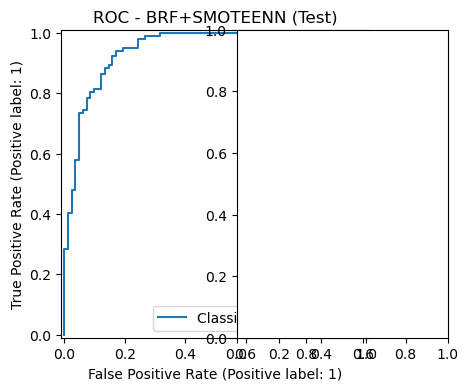

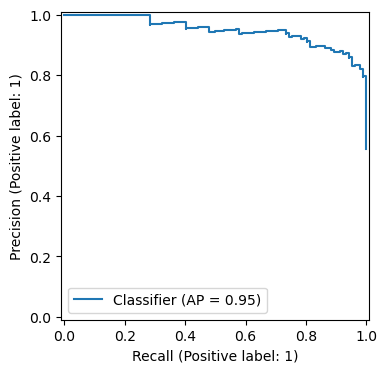

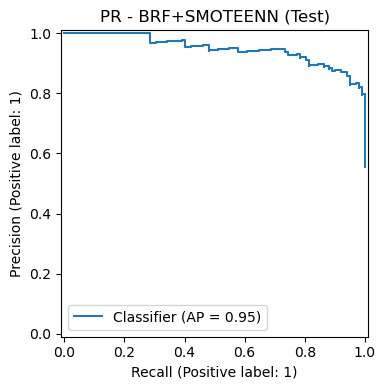

In [22]:
# ===== Block 11: AOA Optimization + Final Modeling + Evaluation (max_iter=20, pop_size=32) =====

def aoa_optimize_rf(X, y, num_cols, cat_cols, max_iter=20, pop_size=32, seed=42):
    rng = np.random.RandomState(seed)
    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7)),
            "max_features": rng.choice(['sqrt', 'log2', None]),
            "bootstrap": bool(rng.randint(0,2)),
            "class_weight": rng.choice([None, 'balanced'])
        }
    def build_rf(p):
        return RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            bootstrap=p["bootstrap"],
            class_weight=p["class_weight"],
            n_jobs=-1,
            random_state=seed
        )
    def build_brf(p):
        return BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            random_state=seed,
            n_jobs=-1
        )
    def fitness(p, use_brf=False, use_sampler=False):
        if use_brf:
            estimator = build_brf(p)
            sampler = SMOTEENN(random_state=seed) if use_sampler else None
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=sampler)
        else:
            estimator = build_rf(p)
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=SMOTEENN(random_state=seed))
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        f1 = f1_score(y, oof_pred)
        recall = recall_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        precision = precision_score(y, oof_pred)
        score = 0.4 * auc + 0.4 * recall + 0.1 * f1 + 0.1 * acc
        return score, {"auc": auc, "acc": acc, "f1": f1, "recall": recall, "precision": precision}

    # RF+SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_rf, best_score_rf, best_metrics_rf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            if rng.rand() < 0.3:
                c["bootstrap"] = not c["bootstrap"]
            if rng.rand() < 0.3:
                c["class_weight"] = rng.choice([None, "balanced"])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=False)
            if sc > best_score_rf:
                best_rf, best_score_rf, best_metrics_rf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (RF+SMOTEENN) | Score={best_score_rf:.4f} | AUC={best_metrics_rf['auc']:.4f} | F1={best_metrics_rf['f1']:.4f} | ACC={best_metrics_rf['acc']:.4f} | Recall={best_metrics_rf['recall']:.4f}")

    # BRF بدون SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf, best_score_brf, best_metrics_brf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=False)
            if sc > best_score_brf:
                best_brf, best_score_brf, best_metrics_brf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF) | Score={best_score_brf:.4f} | AUC={best_metrics_brf['auc']:.4f} | F1={best_metrics_brf['f1']:.4f} | ACC={best_metrics_brf['acc']:.4f} | Recall={best_metrics_brf['recall']:.4f}")

    # BRF+SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=True)
            if sc > best_score_brf_smoteen:
                best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF+SMOTEENN) | Score={best_score_brf_smoteen:.4f} | AUC={best_metrics_brf_smoteen['auc']:.4f} | F1={best_metrics_brf_smoteen['f1']:.4f} | ACC={best_metrics_brf_smoteen['acc']:.4f} | Recall={best_metrics_brf_smoteen['recall']:.4f}")

    return (best_rf, best_metrics_rf), (best_brf, best_metrics_brf), (best_brf_smoteen, best_metrics_brf_smoteen)

# اجرای بهینه‌سازی پارامترها با AOA
(best_params_rf, best_mets_rf), (best_params_brf, best_mets_brf), (best_params_brf_smoteen, best_mets_brf_smoteen) = \
    aoa_optimize_rf(X, y, num_cols, cat_cols, max_iter=20, pop_size=32)

print("\nBest RF params (AOA):", best_params_rf)
print("Best (AOA) metrics (CV 10x1):", best_mets_rf)

print("\nBest BRF params (AOA):", best_params_brf)
print("Best (AOA) metrics (CV 10x1):", best_mets_brf)

print("\nBest BRF+SMOTEENN params (AOA):", best_params_brf_smoteen)
print("Best (AOA with SMOTEENN) metrics (CV 10x1):", best_mets_brf_smoteen)

# ===== Build final pipelines =====
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
pipe_final = build_pipeline(rf_final, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

brf_final = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf = build_pipeline(brf_final, num_cols, cat_cols, sampler=None)

brf_final_smoteen = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf_smoteen.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf_smoteen = build_pipeline(brf_final_smoteen, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

# ===== Train/Test split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe_final.fit(X_train, y_train)
pipe_brf.fit(X_train, y_train)
pipe_brf_smoteen.fit(X_train, y_train)

# ===== OOF metrics on X_train =====
def calc_metrics(pipe, X, y):
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                             method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

metrics_train_rf, proba_train_rf = calc_metrics(pipe_final, X_train, y_train)
metrics_train_brf, proba_train_brf = calc_metrics(pipe_brf, X_train, y_train)
metrics_train_brf_smoteen, proba_train_brf_sm = calc_metrics(pipe_brf_smoteen, X_train, y_train)

# ===== Test metrics on X_test =====
def calc_metrics_test(pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

metrics_test_rf, proba_test_rf = calc_metrics_test(pipe_final, X_test, y_test)
metrics_test_brf, proba_test_brf = calc_metrics_test(pipe_brf, X_test, y_test)
metrics_test_brf_smoteen, proba_test_brf_sm = calc_metrics_test(pipe_brf_smoteen, X_test, y_test)

# ===== Print metrics (Train OOF) =====
print("\nFinal RF+SMOTEENN (Train/OOF):")
for k, v in metrics_train_rf.items(): print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Train/OOF):")
for k, v in metrics_train_brf.items(): print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Train/OOF):")
for k, v in metrics_train_brf_smoteen.items(): print(f"{k.capitalize()}: {v:.3f}")

# ===== Print metrics (Test) =====
print("\nFinal RF+SMOTEENN (Test):")
for k, v in metrics_test_rf.items(): print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Test):")
for k, v in metrics_test_brf.items(): print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Test):")
for k, v in metrics_test_brf_smoteen.items(): print(f"{k.capitalize()}: {v:.3f}")

# ===== Plots: ROC and PR for Test (three models) =====
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1); RocCurveDisplay.from_predictions(y_test, proba_test_rf).plot(); plt.title("ROC - RF (Test)")
plt.subplot(1, 2, 2); PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf).plot(); plt.title("PR - RF (Test)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1); RocCurveDisplay.from_predictions(y_test, proba_test_brf).plot(); plt.title("ROC - BRF (Test)")
plt.subplot(1, 2, 2); PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf).plot(); plt.title("PR - BRF (Test)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1); RocCurveDisplay.from_predictions(y_test, proba_test_brf_sm).plot(); plt.title("ROC - BRF+SMOTEENN (Test)")
plt.subplot(1, 2, 2); PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf_sm).plot(); plt.title("PR - BRF+SMOTEENN (Test)")
plt.tight_layout(); plt.show()

# ===== Optional: ROC/PR for Train (OOF) =====
# اگر می‌خواهی نمودارهای OOF (Train) هم رسم شود، این بلوک را فعال کن:
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1); RocCurveDisplay.from_predictions(y_train, proba_train_rf).plot(); plt.title("ROC - RF (Train OOF)")
# plt.subplot(1, 2, 2); PrecisionRecallDisplay.from_predictions(y_train, proba_train_rf).plot(); plt.title("PR - RF (Train OOF)")
# plt.tight_layout(); plt.show()
#
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1); RocCurveDisplay.from_predictions(y_train, proba_train_brf).plot(); plt.title("ROC - BRF (Train OOF)")
# plt.subplot(1, 2, 2); PrecisionRecallDisplay.from_predictions(y_train, proba_train_brf).plot(); plt.title("PR - BRF (Train OOF)")
# plt.tight_layout(); plt.show()
#
# plt.figure(figsize=(14, 6))
# plt.subplot(1, 2, 1); RocCurveDisplay.from_predictions(y_train, proba_train_brf_sm).plot(); plt.title("ROC - BRF+SMOTEENN (Train OOF)")
# plt.subplot(1, 2, 2); PrecisionRecallDisplay.from_predictions(y_train, proba_train_brf_sm).plot(); plt.title("PR - BRF+SMOTEENN (Train OOF)")
# plt.tight_layout(); plt.show()


Iter 1/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 2/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 3/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 4/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 5/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 6/20 (RF+SMOTEENN) | Score=0.8982 | AUC=0.9232 | F1=0.8728 | ACC=0.8565 | Recall=0.8900
Iter 7/20 (RF+SMOTEENN) | Score=0.8991 | AUC=0.9223 | F1=0.8748 | ACC=0.8587 | Recall=0.8919
Iter 8/20 (RF+SMOTEENN) | Score=0.8991 | AUC=0.9223 | F1=0.8748 | ACC=0.8587 | Recall=0.8919
Iter 9/20 (RF+SMOTEENN) | Score=0.8991 | AUC=0.9223 | F1=0.8748 | ACC=0.8587 | Recall=0.8919
Iter 10/20 (RF+SMOTEENN) | Score=0.9010 | AUC=0.9198 | F1=0.8780 | ACC=0.8620 | Recall=0.8978
Iter 11/20 (RF+SMOTEENN) | Score=0.9010 | AUC=0.9198 | F1=0.8780 | AC

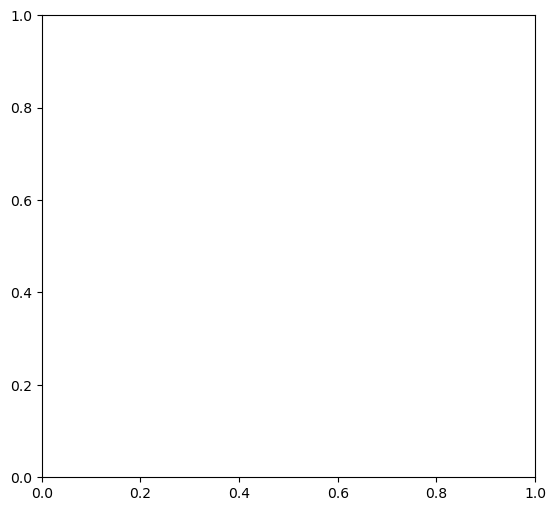

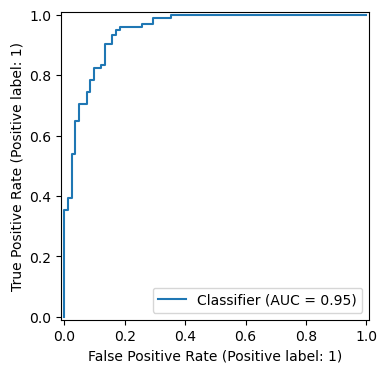

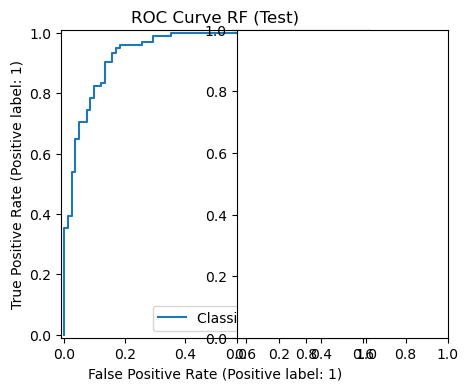

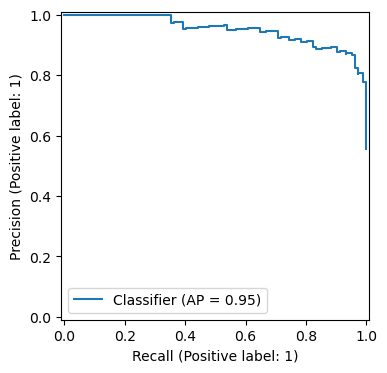

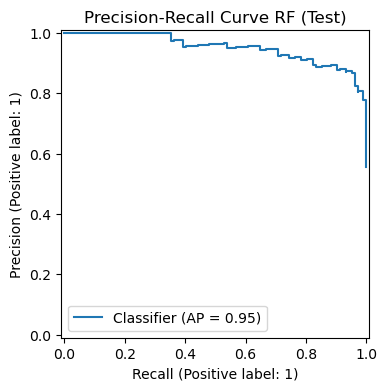

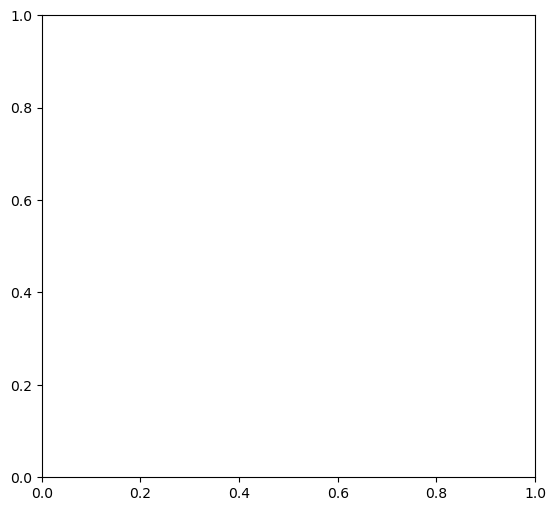

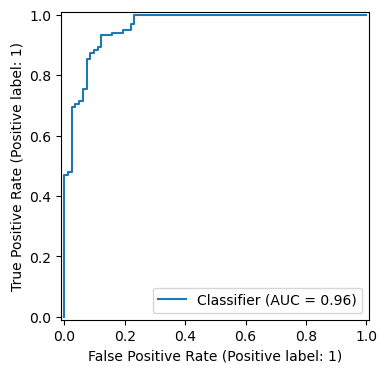

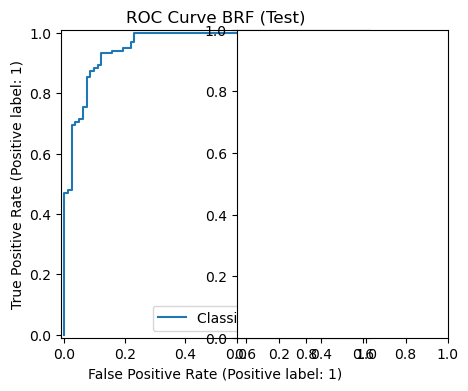

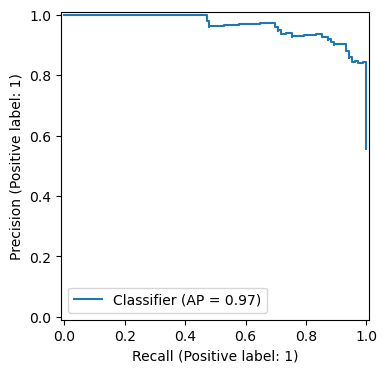

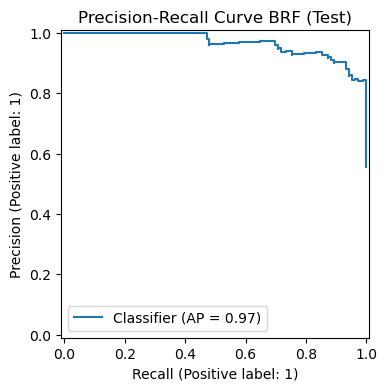

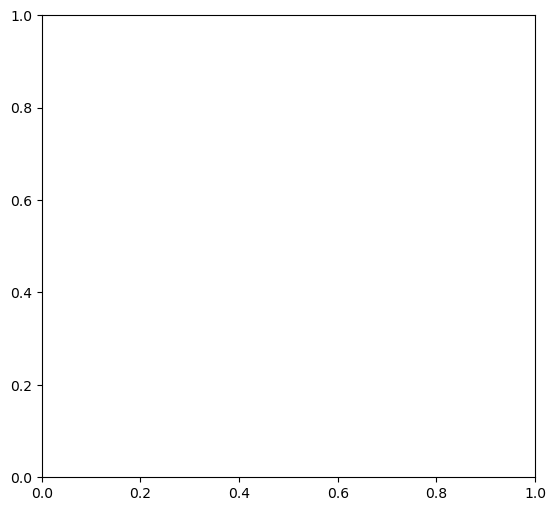

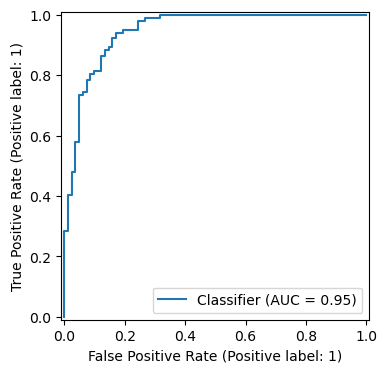

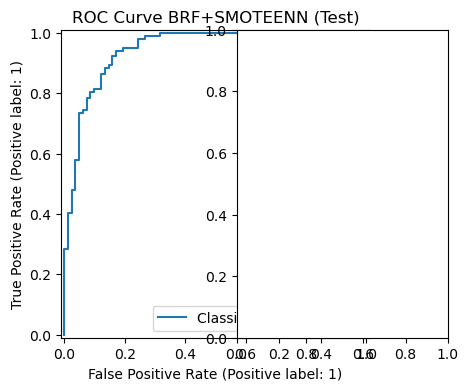

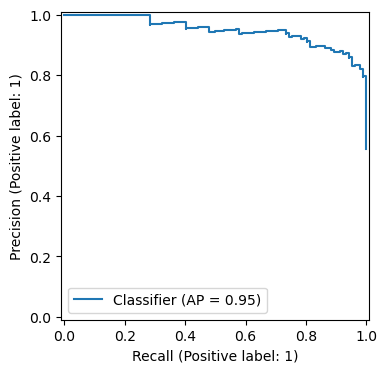

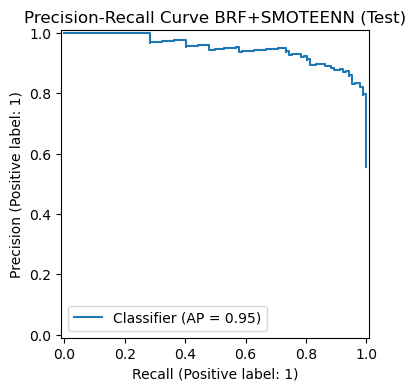

In [21]:
# ===== Block 12: AOA++ Optimization + Final Modeling + Evaluation (max_iter=20, pop_size=32) =====

def aoa_optimize_rf_plusplus(X, y, num_cols, cat_cols, max_iter=20, pop_size=32, seed=42):
    rng = np.random.RandomState(seed)
    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7)),
            "max_features": rng.choice(['sqrt', 'log2', None]),
            "bootstrap": bool(rng.randint(0,2)),
            "class_weight": rng.choice([None, 'balanced'])
        }
    def build_rf(p):
        return RandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            bootstrap=p["bootstrap"],
            class_weight=p["class_weight"],
            n_jobs=-1,
            random_state=seed
        )
    def build_brf(p):
        # class_weight و bootstrap در BRF پشتیبانی نمی‌شود
        return BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            random_state=seed,
            n_jobs=-1
        )
    def fitness(p, use_brf=False, use_sampler=False):
        if use_brf:
            estimator = build_brf(p)
            sampler = SMOTEENN(random_state=seed) if use_sampler else None
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=sampler)
        else:
            estimator = build_rf(p)
            pipe = build_pipeline(estimator, num_cols, cat_cols, sampler=SMOTEENN(random_state=seed))
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        f1 = f1_score(y, oof_pred)
        recall = recall_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        precision = precision_score(y, oof_pred)
        score = 0.4 * auc + 0.4 * recall + 0.1 * f1 + 0.1 * acc
        return score, {"auc": auc, "acc": acc, "f1": f1, "recall": recall, "precision": precision}

    # RF+SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_rf, best_score_rf, best_metrics_rf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            if rng.rand() < 0.3:
                c["bootstrap"] = not c["bootstrap"]
            if rng.rand() < 0.3:
                c["class_weight"] = rng.choice([None, "balanced"])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=False)
            if sc > best_score_rf:
                best_rf, best_score_rf, best_metrics_rf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (RF+SMOTEENN) | Score={best_score_rf:.4f} | AUC={best_metrics_rf['auc']:.4f} | F1={best_metrics_rf['f1']:.4f} | ACC={best_metrics_rf['acc']:.4f} | Recall={best_metrics_rf['recall']:.4f}")

    # BRF بدون SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf, best_score_brf, best_metrics_brf = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=False)
            if sc > best_score_brf:
                best_brf, best_score_brf, best_metrics_brf = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF) | Score={best_score_brf:.4f} | AUC={best_metrics_brf['auc']:.4f} | F1={best_metrics_brf['f1']:.4f} | ACC={best_metrics_brf['acc']:.4f} | Recall={best_metrics_brf['recall']:.4f}")

    # BRF+SMOTEENN
    population = [sample_candidate() for _ in range(pop_size)]
    best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = None, -np.inf, None
    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600))
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12))
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(["sqrt", "log2", None])
            new_pop.append(c)
        for cand in new_pop:
            sc, mets = fitness(cand, use_brf=True, use_sampler=True)
            if sc > best_score_brf_smoteen:
                best_brf_smoteen, best_score_brf_smoteen, best_metrics_brf_smoteen = cand, sc, mets
        population = new_pop
        print(f"Iter {it+1}/{max_iter} (BRF+SMOTEENN) | Score={best_score_brf_smoteen:.4f} | AUC={best_metrics_brf_smoteen['auc']:.4f} | F1={best_metrics_brf_smoteen['f1']:.4f} | ACC={best_metrics_brf_smoteen['acc']:.4f} | Recall={best_metrics_brf_smoteen['recall']:.4f}")

    return (best_rf, best_metrics_rf), (best_brf, best_metrics_brf), (best_brf_smoteen, best_metrics_brf_smoteen)

# اجرای بهینه‌سازی پارامترها به روش پیشرفته‌تر (AOA++)
(best_params_rf, best_mets_rf), (best_params_brf, best_mets_brf), (best_params_brf_smoteen, best_mets_brf_smoteen) = \
    aoa_optimize_rf_plusplus(X, y, num_cols, cat_cols, max_iter=20, pop_size=32)

print("\nBest RF params (AOA++):", best_params_rf)
print("Best (AOA++) metrics (CV 10x1):", best_mets_rf)

print("\nBest BRF params (AOA++):", best_params_brf)
print("Best (AOA++) metrics (CV 10x1):", best_mets_brf)

print("\nBest BRF+SMOTEENN params (AOA++):", best_params_brf_smoteen)
print("Best (AOA++ with SMOTEENN) metrics (CV 10x1):", best_mets_brf_smoteen)

# ساخت مدل‌ها با پارامتر بهتر و pipeline (بدون هیچ تغییر دیگری)
rf_final = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
pipe_final = build_pipeline(rf_final, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

brf_final = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf = build_pipeline(brf_final, num_cols, cat_cols, sampler=None)

brf_final_smoteen = BalancedRandomForestClassifier(**{k: v for k, v in best_params_brf_smoteen.items() if k not in ['class_weight', 'bootstrap']}, random_state=42, n_jobs=-1)
pipe_brf_smoteen = build_pipeline(brf_final_smoteen, num_cols, cat_cols, sampler=SMOTEENN(random_state=42))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipe_final.fit(X_train, y_train)
pipe_brf.fit(X_train, y_train)
pipe_brf_smoteen.fit(X_train, y_train)

def calc_metrics(pipe, X, y):
    proba = cross_val_predict(pipe, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
                             method="predict_proba", n_jobs=-1)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }

metrics_train_rf = calc_metrics(pipe_final, X_train, y_train)
metrics_train_brf = calc_metrics(pipe_brf, X_train, y_train)
metrics_train_brf_smoteen = calc_metrics(pipe_brf_smoteen, X_train, y_train)

def calc_metrics_test(pipe, X, y):
    proba = pipe.predict_proba(X)[:, 1]
    preds = (proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y, preds),
        "roc_auc": roc_auc_score(y, proba),
        "recall": recall_score(y, preds),
        "precision": precision_score(y, preds),
        "f1": f1_score(y, preds)
    }, proba

metrics_test_rf, proba_test_rf = calc_metrics_test(pipe_final, X_test, y_test)
metrics_test_brf, proba_test_brf = calc_metrics_test(pipe_brf, X_test, y_test)
metrics_test_brf_smoteen, proba_test_brf_smoteen = calc_metrics_test(pipe_brf_smoteen, X_test, y_test)

print("\nFinal RF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal RF+SMOTEENN (Test):")
for k, v in metrics_test_rf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Train/Oof):")
for k, v in metrics_train_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF (Test):")
for k, v in metrics_test_brf.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Train/Oof):")
for k, v in metrics_train_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

print("\nFinal BRF+SMOTEENN (Test):")
for k, v in metrics_test_brf_smoteen.items():
    print(f"{k.capitalize()}: {v:.3f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("ROC Curve RF (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_rf).plot()
plt.title("Precision-Recall Curve RF (Test)")
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("ROC Curve BRF (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf).plot()
plt.title("Precision-Recall Curve BRF (Test)")
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
RocCurveDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("ROC Curve BRF+SMOTEENN (Test)")
plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_predictions(y_test, proba_test_brf_smoteen).plot()
plt.title("Precision-Recall Curve BRF+SMOTEENN (Test)")
plt.show()


# ==============================================================================
# PART 3: FINAL EVALUATION, BASELINES & XAI
# ==============================================================================

In [4]:
# ===== block 13:AOA/AOA++ optimizer for calibrated BRF (used in the main proposed pipeline)

def build_pipeline(model, num_cols, cat_cols, sampler=None):
    num_pipe = SkPipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ])
    cat_pipe = SkPipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])
    pre = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])
    steps = [("pre", pre)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", model))
    return ImbPipeline(steps)

# ===== 1) Threshold search helper =====
def find_best_threshold(y_true, proba, metric="f1"):
    thresholds = np.linspace(0.05, 0.95, 37)
    best_t, best_val = 0.5, -np.inf
    for t in thresholds:
        preds = (proba >= t).astype(int)
        if metric == "f1":
            val = f1_score(y_true, preds)
        elif metric == "balanced_acc":
            from sklearn.metrics import balanced_accuracy_score
            val = balanced_accuracy_score(y_true, preds)
        else:
            val = f1_score(y_true, preds)
        if val > best_val:
            best_val, best_t = val, t
    return best_t, best_val

# ===== 2) Feature selector (compatible with sklearn clone) =====
class FeatureNameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessor=None, selected_feature_names=None):
        self.preprocessor = preprocessor
        self.selected_feature_names = selected_feature_names if selected_feature_names is not None else []
        self._idxs_ = None

    def fit(self, X, y=None):
        # fit internal preprocessor to expose get_feature_names_out
        self.preprocessor.fit(X, y)
        all_feats = self.preprocessor.get_feature_names_out()
        name_to_idx = {n: i for i, n in enumerate(all_feats)}
        self._idxs_ = np.array(
            [name_to_idx[n] for n in self.selected_feature_names if n in name_to_idx],
            dtype=int
        )
        return self

    def transform(self, X):
        Xt = self.preprocessor.transform(X)
        if self._idxs_ is None or len(self._idxs_) == 0:
            return Xt
        return Xt[:, self._idxs_]

# ===== 3) Permutation Importance → Top-K features (no sampler) =====
def compute_perm_importance_topk(X, y, num_cols, cat_cols, K=15, seed=42):
    """
    محاسبه‌ی Permutation Importance روی یک BRF بدون نمونه‌برداری
    توجه: برای جلوگیری از نشت، در بلوک‌های اصلی روی X_train, y_train صدا بزنید.
    """
    temp_model = BalancedRandomForestClassifier(
        n_estimators=300,
        random_state=seed,
        n_jobs=-1
    )
    temp_pipe = build_pipeline(temp_model, num_cols, cat_cols, sampler=None)

    # fit to expose feature names
    temp_pipe.fit(X, y)
    pre = temp_pipe.named_steps["pre"]
    feat_names = pre.get_feature_names_out()

    result = permutation_importance(
        temp_pipe, X, y,
        scoring="roc_auc",
        n_repeats=20,
        random_state=seed,
        n_jobs=-1
    )

    features_used = feat_names[:len(result.importances_mean)]
    imp_df = pd.DataFrame({
        "feature": features_used,
        "mean": result.importances_mean,
        "std": result.importances_std
    }).sort_values("mean", ascending=False).reset_index(drop=True)

    # Optional: plot top-K bar
    plt.figure(figsize=(7, 5))
    sns.barplot(data=imp_df.head(K), x="mean", y="feature", orient="h")
    plt.title(f"Top-{K} Features (Permutation Importance)")
    plt.tight_layout()
    plt.show()

    top_features = imp_df.head(K)["feature"].tolist()
    return top_features, imp_df

# ===== 4) AOA++ helper for BRF + calibration (no sampler) =====
def aoa_optimize_brf_calib(
    X, y, num_cols, cat_cols, selected_feature_names,
    max_iter=10, pop_size=16, seed=42, return_history=True
):
    """
    بهینه‌سازی پارامترهای BRF + Calibration با AOA++ روی داده‌ی ورودی.
    برای جلوگیری از نشت، اگر در سناریوی train/test هستید،
    این تابع را روی X_train, y_train صدا بزنید، نه کل X, y.
    """
    rng = np.random.RandomState(seed)

    # base pre to be reused by FeatureNameSelector
    num_pipe = SkPipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ])
    cat_pipe = SkPipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])
    base_pre = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])

    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7)),
            "max_features": rng.choice(['sqrt', 'log2', None])
        }

    def build_brf_calibrated(p):
        base = BalancedRandomForestClassifier(
            n_estimators=p["n_estimators"],
            max_depth=p["max_depth"],
            min_samples_split=p["min_samples_split"],
            min_samples_leaf=p["min_samples_leaf"],
            max_features=p["max_features"],
            random_state=seed,
            n_jobs=-1
        )
        return CalibratedClassifierCV(base, method="isotonic", cv=5)

    def build_fs_calib_pipeline(p):
        feat_sel = FeatureNameSelector(
            preprocessor=base_pre,
            selected_feature_names=selected_feature_names
        )
        model = build_brf_calibrated(p)
        return ImbPipeline([
            ("feat_pre", feat_sel),
            ("model", model)
        ])

    def fitness(p):
        pipe = build_fs_calib_pipeline(p)
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        oof_proba = cross_val_predict(
            pipe, X, y,
            cv=cv,
            method="predict_proba",
            n_jobs=-1
        )[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y, oof_proba)
        rec = recall_score(y, oof_pred)
        f1 = f1_score(y, oof_pred)
        acc = accuracy_score(y, oof_pred)
        sc = 0.4*auc + 0.4*rec + 0.1*f1 + 0.1*acc
        return sc, {"auc": auc, "recall": rec, "f1": f1, "acc": acc}

    population = [sample_candidate() for _ in range(pop_size)]
    best_p, best_score, best_mets = None, -np.inf, None
    history = []

    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            if rng.rand() < 0.6:
                c["n_estimators"] = int(
                    np.clip(c["n_estimators"] + rng.normal(0, 80), 150, 600)
                )
            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])
            if rng.rand() < 0.5:
                c["min_samples_split"] = int(
                    np.clip(c["min_samples_split"] + rng.randint(-2, 3), 2, 12)
                )
            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(
                    np.clip(c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6)
                )
            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(['sqrt', 'log2', None])
            new_pop.append(c)

        for cand in new_pop:
            sc, mets = fitness(cand)
            if return_history:
                history.append({
                    "iter": it + 1,
                    **cand,
                    **mets,
                    "score": sc
                })
            if sc > best_score:
                best_p, best_score, best_mets = cand, sc, mets

        population = new_pop
        print(
            f"Iter {it+1}/{max_iter} (BRF-Calib) | "
            f"Score={best_score:.4f} | "
            f"AUC={best_mets['auc']:.4f} | "
            f"F1={best_mets['f1']:.4f} | "
            f"ACC={best_mets['acc']:.4f} | "
            f"Recall={best_mets['recall']:.4f}"
        )

    hist_df = pd.DataFrame(history) if return_history else None
    return best_p, best_mets,

>>> Splitting Data (Train/Test) to ensure leak-free evaluation...
Train shape: (736, 14), Test shape: (184, 14)

>>> Computing Top-15 Features on X_train (Block 15 Logic)...


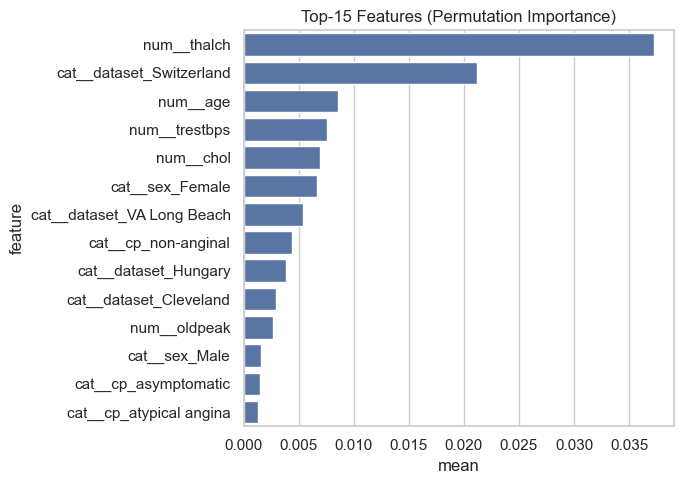

Selected Features: ['num__thalch', 'cat__dataset_Switzerland', 'num__age', 'num__trestbps', 'num__chol', 'cat__sex_Female', 'cat__dataset_VA Long Beach', 'cat__cp_non-anginal', 'cat__dataset_Hungary', 'cat__dataset_Cleveland', 'num__oldpeak', 'cat__sex_Male', 'cat__cp_asymptomatic', 'cat__cp_atypical angina']

>>> Starting Baseline Evaluation Loop...

--- Evaluating LR (Base) ---
Threshold: 0.350
Test Scores: AUC=0.917, F1=0.851, Recall=0.951

--- Evaluating SVM (Base) ---
Threshold: 0.475
Test Scores: AUC=0.911, F1=0.858, Recall=0.922

--- Evaluating XGB (Base) ---
Threshold: 0.450
Test Scores: AUC=0.895, F1=0.842, Recall=0.941

--- Evaluating RF (Default) ---
Threshold: 0.450
Test Scores: AUC=0.917, F1=0.858, Recall=0.951


################# BASELINE LEADERBOARD (Test Set) #################


AUC        F1    Recall  Precision       Acc  Threshold
SVM (Base)    0.910509  0.858447  0.921569   0.803419  0.831522      0.475
RF (Default)  0.916906  0.858407  0.950980   0.782258  0.826087      0.450
LR (Base)     0.917264  0.850877  0.950980   0.769841  0.815217      0.350
XGB (Base)    0.895086  0.842105  0.941176   0.761905  0.804348      0.450

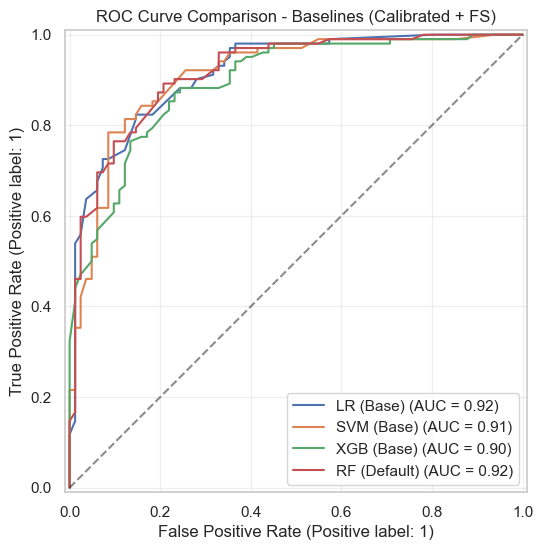

In [8]:
# ===== Block 14: Standard Baselines (LR, SVM, XGB, RF)  =====
# Prerequisites:
# 1. The "Methods Block" must be executed first (defining FeatureNameSelector, compute_perm_importance_topk, etc.).
# 2. Variables X, y, num_cols, cat_cols must exist.

# ------------------------------------------------------------------------------
# 1. Leak-Safe Data Split
# ------------------------------------------------------------------------------
print(">>> Splitting Data (Train/Test) to ensure leak-free evaluation...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ------------------------------------------------------------------------------
# 2. Global Feature Selection (Same as Block 15)
# ------------------------------------------------------------------------------
# We use the helper function from your Methods Block
print("\n>>> Computing Top-15 Features on X_train (Block 15 Logic)...")
global_top_features, _ = compute_perm_importance_topk(
    X_train, y_train, num_cols, cat_cols, K=15, seed=42
)
print(f"Selected Features: {global_top_features}")

# ------------------------------------------------------------------------------
# 3. Pipeline Construction Helper (Local)
# ------------------------------------------------------------------------------
def make_baseline_pipeline(base_estimator, selected_feats):
    """
    Creates a pipeline matching Block 15 architecture:
    Preprocessing -> Feature Selection -> Calibration -> Model
    """
    # Standard Preprocessing
    num_pipe = SkPipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ])
    cat_pipe = SkPipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])

    # Feature Selector (from Methods Block)
    feat_sel = FeatureNameSelector(
        preprocessor=preprocessor,
        selected_feature_names=selected_feats
    )

    # Calibrated Classifier (Isotonic) - Critical for Block 15 parity
    # Note: We use CV=3 here for baselines to save time, Block 15 uses CV=5
    calibrated_model = CalibratedClassifierCV(base_estimator, method='isotonic', cv=3)

    # Final Pipeline
    return ImbPipeline([
        ("feat_pre", feat_sel),
        ("model", calibrated_model)
    ])

# ------------------------------------------------------------------------------
# 4. Define Baseline Models
# ------------------------------------------------------------------------------
# Calculate scale_pos_weight for XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

baselines = {
    "LR (Base)": LogisticRegression(class_weight='balanced', max_iter=3000, solver='liblinear', random_state=42),
    "SVM (Base)": SVC(class_weight='balanced', kernel='rbf', probability=True, random_state=42),
    "XGB (Base)": XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss', n_estimators=200, random_state=42, n_jobs=-1),
    "RF (Default)": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42, n_jobs=-1)
}

# ------------------------------------------------------------------------------
# 5. Execution Loop (OOF -> Threshold -> Test)
# ------------------------------------------------------------------------------
baseline_results = {}
test_probas = {}

print("\n>>> Starting Baseline Evaluation Loop...")

for name, model in baselines.items():
    print(f"\n--- Evaluating {name} ---")
    
    # A. Build Pipeline
    pipe = make_baseline_pipeline(model, global_top_features)
    
    # B. OOF Predictions on Train (for Threshold Optimization)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        oof_proba = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    except Exception as e:
        print(f"Error in CV for {name}: {e}")
        continue

    # C. Find Best Threshold
    best_t, best_f1 = find_best_threshold(y_train, oof_proba, metric="f1")
    
    # D. Final Fit on Full Train
    pipe.fit(X_train, y_train)
    
    # E. Predict on Test
    proba_test = pipe.predict_proba(X_test)[:, 1]
    preds_test = (proba_test >= best_t).astype(int)
    test_probas[name] = proba_test

    # F. Calculate Metrics
    metrics = {
        "AUC": roc_auc_score(y_test, proba_test),
        "F1": f1_score(y_test, preds_test),
        "Recall": recall_score(y_test, preds_test),
        "Precision": precision_score(y_test, preds_test),
        "Acc": accuracy_score(y_test, preds_test),
        "Threshold": best_t
    }
    baseline_results[name] = metrics
    
    print(f"Threshold: {best_t:.3f}")
    print(f"Test Scores: AUC={metrics['AUC']:.3f}, F1={metrics['F1']:.3f}, Recall={metrics['Recall']:.3f}")

# ------------------------------------------------------------------------------
# 6. Final Visualization & Comparison
# ------------------------------------------------------------------------------
# Create DataFrame
df_res = pd.DataFrame(baseline_results).T.sort_values("F1", ascending=False)

print("\n\n################# BASELINE LEADERBOARD (Test Set) #################")
display(df_res)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
ax = plt.gca()
for name, proba in test_probas.items():
    RocCurveDisplay.from_predictions(y_test, proba, name=name, ax=ax)

plt.title("ROC Curve Comparison - Baselines (Calibrated + FS)")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

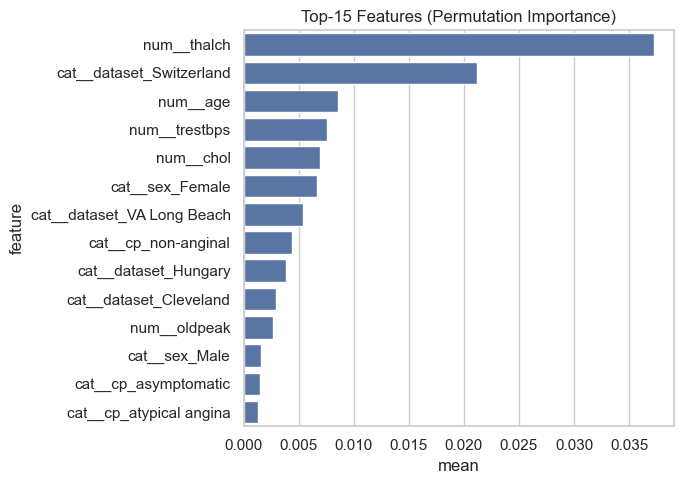

Selected Top-15 features (train only): ['num__thalch', 'cat__dataset_Switzerland', 'num__age', 'num__trestbps', 'num__chol', 'cat__sex_Female', 'cat__dataset_VA Long Beach', 'cat__cp_non-anginal', 'cat__dataset_Hungary', 'cat__dataset_Cleveland', 'num__oldpeak', 'cat__sex_Male', 'cat__cp_asymptomatic', 'cat__cp_atypical angina']
Iter 1/15 (BRF-Calib) | Score=0.8613 | AUC=0.8681 | F1=0.8302 | ACC=0.8016 | Recall=0.8771
Iter 2/15 (BRF-Calib) | Score=0.8613 | AUC=0.8681 | F1=0.8302 | ACC=0.8016 | Recall=0.8771
Iter 3/15 (BRF-Calib) | Score=0.8626 | AUC=0.8670 | F1=0.8335 | ACC=0.8057 | Recall=0.8796
Iter 4/15 (BRF-Calib) | Score=0.8626 | AUC=0.8670 | F1=0.8335 | ACC=0.8057 | Recall=0.8796
Iter 5/15 (BRF-Calib) | Score=0.8637 | AUC=0.8685 | F1=0.8320 | ACC=0.8030 | Recall=0.8821
Iter 6/15 (BRF-Calib) | Score=0.8637 | AUC=0.8685 | F1=0.8320 | ACC=0.8030 | Recall=0.8821
Iter 7/15 (BRF-Calib) | Score=0.8644 | AUC=0.8681 | F1=0.8314 | ACC=0.8016 | Recall=0.8845
Iter 8/15 (BRF-Calib) | Score=0.

iter  best_score
10    11    0.864353
11    12    0.864353
12    13    0.864353
13    14    0.864353
14    15    0.864353

Iter 1/15 (RF+SMOTEENN-Calib) | Score=0.8276 | AUC=0.8543 | F1=0.8088 | ACC=0.7867 | Recall=0.8157
Iter 2/15 (RF+SMOTEENN-Calib) | Score=0.8276 | AUC=0.8543 | F1=0.8088 | ACC=0.7867 | Recall=0.8157
Iter 3/15 (RF+SMOTEENN-Calib) | Score=0.8276 | AUC=0.8543 | F1=0.8088 | ACC=0.7867 | Recall=0.8157
Iter 4/15 (RF+SMOTEENN-Calib) | Score=0.8279 | AUC=0.8558 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 5/15 (RF+SMOTEENN-Calib) | Score=0.8279 | AUC=0.8558 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 6/15 (RF+SMOTEENN-Calib) | Score=0.8279 | AUC=0.8558 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 7/15 (RF+SMOTEENN-Calib) | Score=0.8279 | AUC=0.8558 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 8/15 (RF+SMOTEENN-Calib) | Score=0.8279 | AUC=0.8558 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 9/15 (RF+SMOTEENN-Calib) | Score=0.8279 | AUC=0.8558 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 10/15 (RF+SMOTEENN-Calib) | Score=0.8279 | AUC=0.8558 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 11/1

iter  best_score
10    11    0.827930
11    12    0.828654
12    13    0.828654
13    14    0.828654
14    15    0.828654

Iter 1/15 (BRF+SMOTEENN-Calib) | Score=0.8275 | AUC=0.8579 | F1=0.8063 | ACC=0.7840 | Recall=0.8133
Iter 2/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 3/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 4/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 5/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 6/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 7/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 8/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 9/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157
Iter 10/15 (BRF+SMOTEENN-Calib) | Score=0.8281 | AUC=0.8562 | F1=0.8078 | ACC=0.7853 | Recall=0.8157

iter  best_score
10    11    0.828092
11    12    0.828095
12    13    0.828227
13    14    0.828227
14    15    0.828370


=== BRF Calibrated with PI-TopK ===
Train (OOF) @0.50: {'accuracy': 0.8016, 'roc_auc': np.float64(0.8681), 'recall': 0.8845, 'precision': 0.7843, 'f1': 0.8314}
Train (OOF) @opt : {'accuracy': 0.8016, 'roc_auc': np.float64(0.8681), 'recall': 0.9189, 'precision': 0.768, 'f1': 0.8367, 'threshold': np.float64(0.375)}
Test @0.50: {'accuracy': 0.8152, 'roc_auc': np.float64(0.9208), 'recall': 0.9216, 'precision': 0.7833, 'f1': 0.8468}
Test @opt : {'accuracy': 0.8261, 'roc_auc': np.float64(0.9208), 'recall': 0.9706, 'precision': 0.7734, 'f1': 0.8609, 'threshold': np.float64(0.375)}


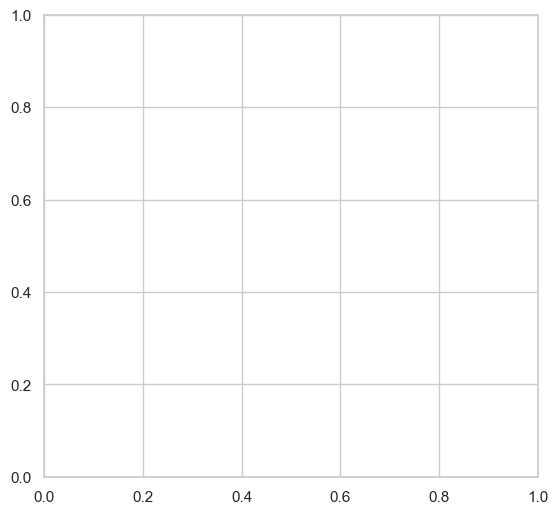

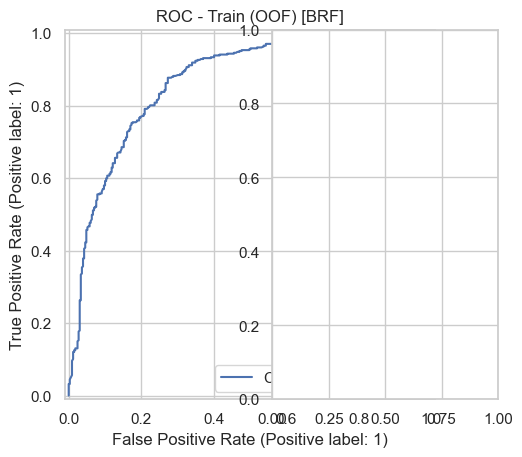

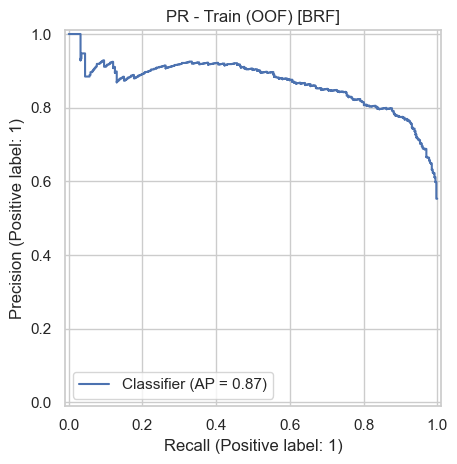

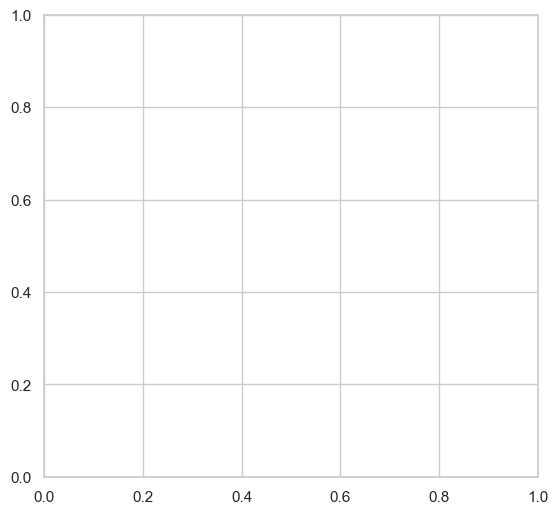

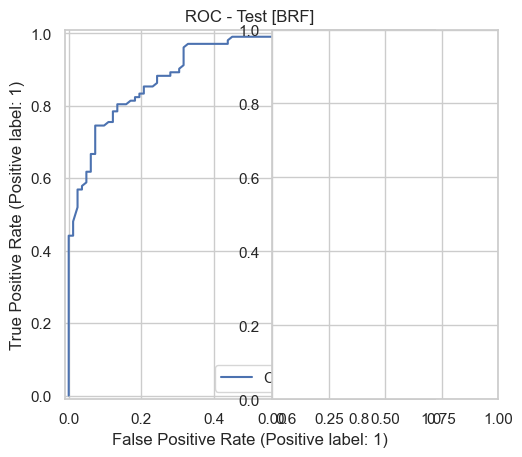

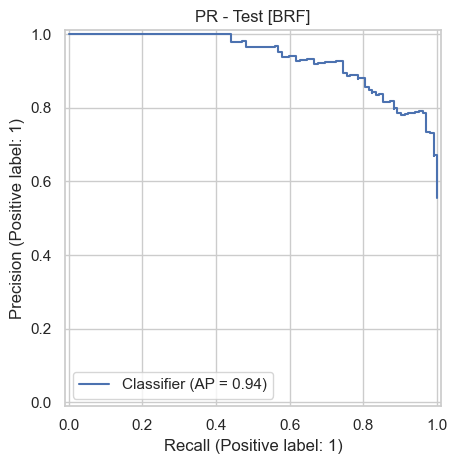

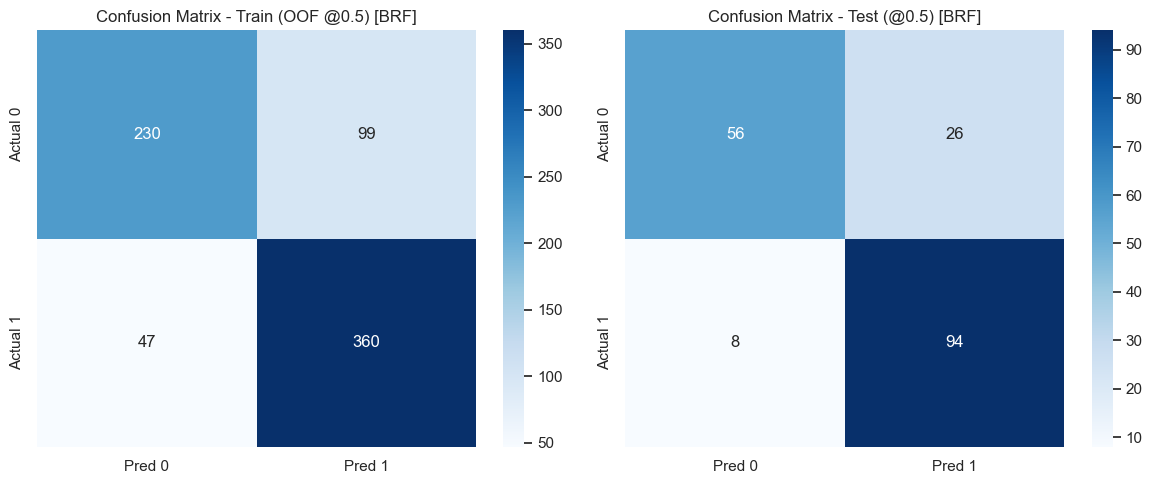

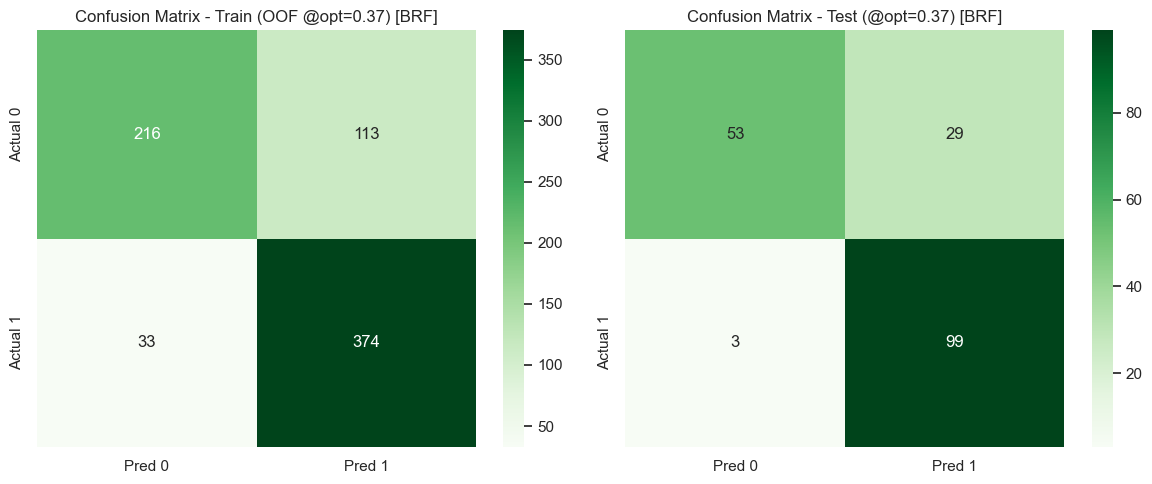


=== RF+SMOTEENN Calibrated with PI-TopK ===
Train (OOF) @0.50: {'accuracy': 0.7867, 'roc_auc': np.float64(0.857), 'recall': 0.8157, 'precision': 0.8019, 'f1': 0.8088}
Train (OOF) @opt : {'accuracy': 0.7867, 'roc_auc': np.float64(0.857), 'recall': 0.9066, 'precision': 0.7561, 'f1': 0.8246, 'threshold': np.float64(0.1)}
Test @0.50: {'accuracy': 0.8424, 'roc_auc': np.float64(0.9051), 'recall': 0.8725, 'precision': 0.8476, 'f1': 0.8599}
Test @opt : {'accuracy': 0.8261, 'roc_auc': np.float64(0.9051), 'recall': 0.9314, 'precision': 0.7917, 'f1': 0.8559, 'threshold': np.float64(0.1)}


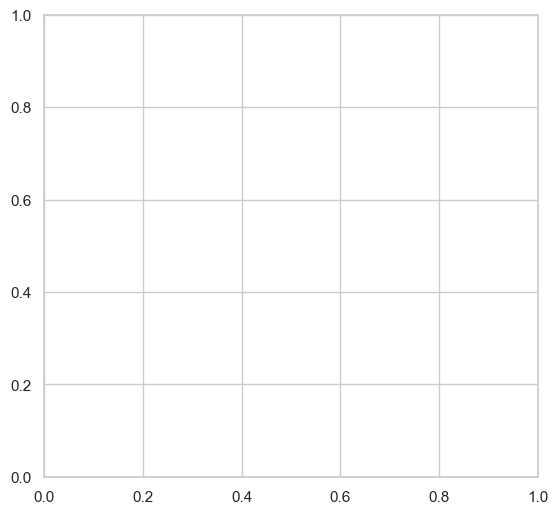

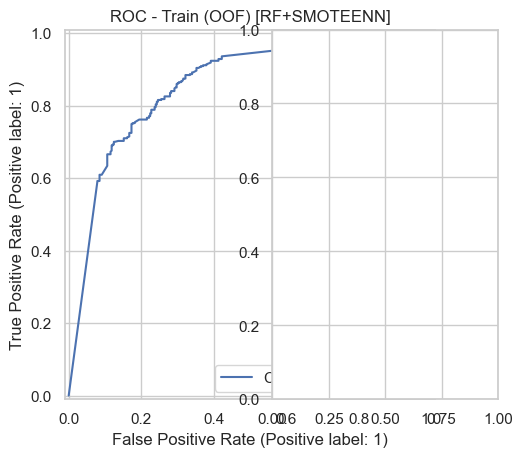

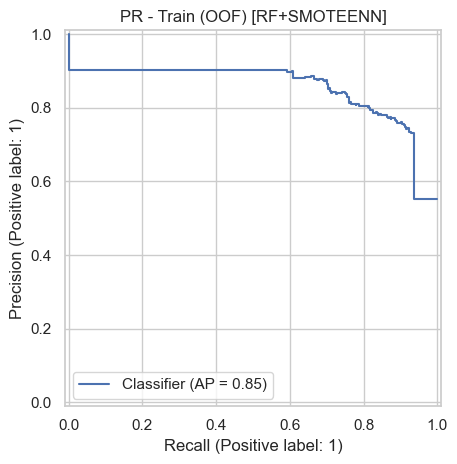

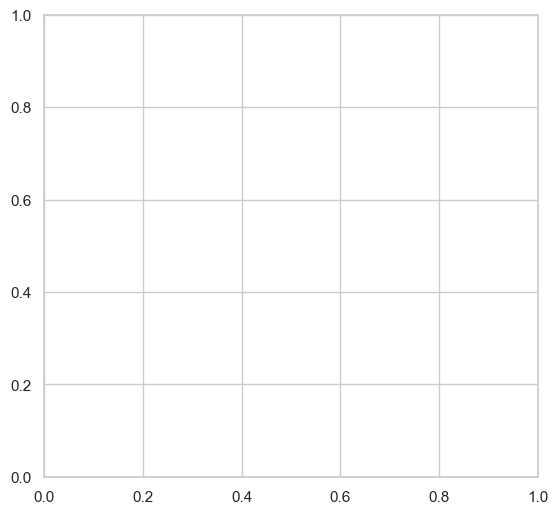

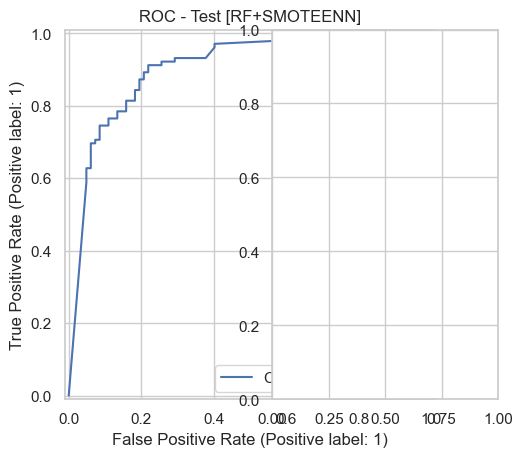

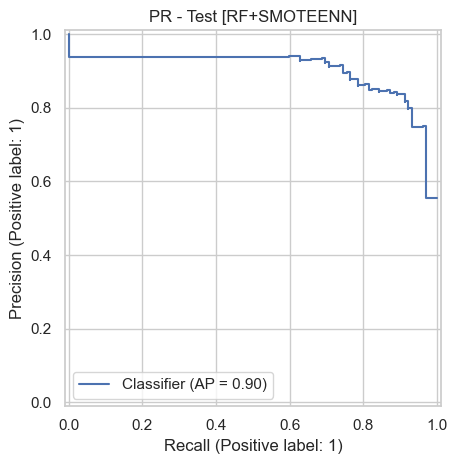

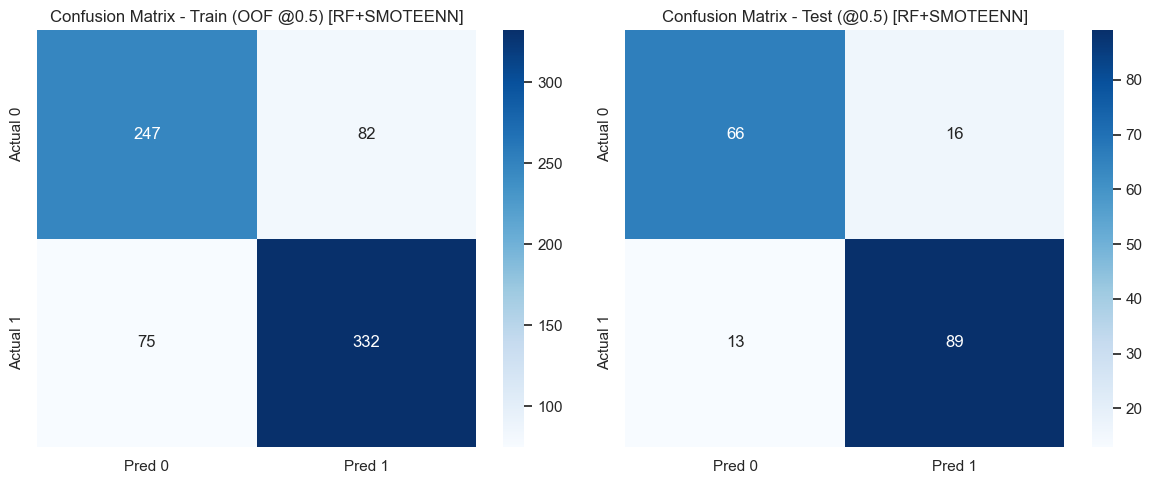

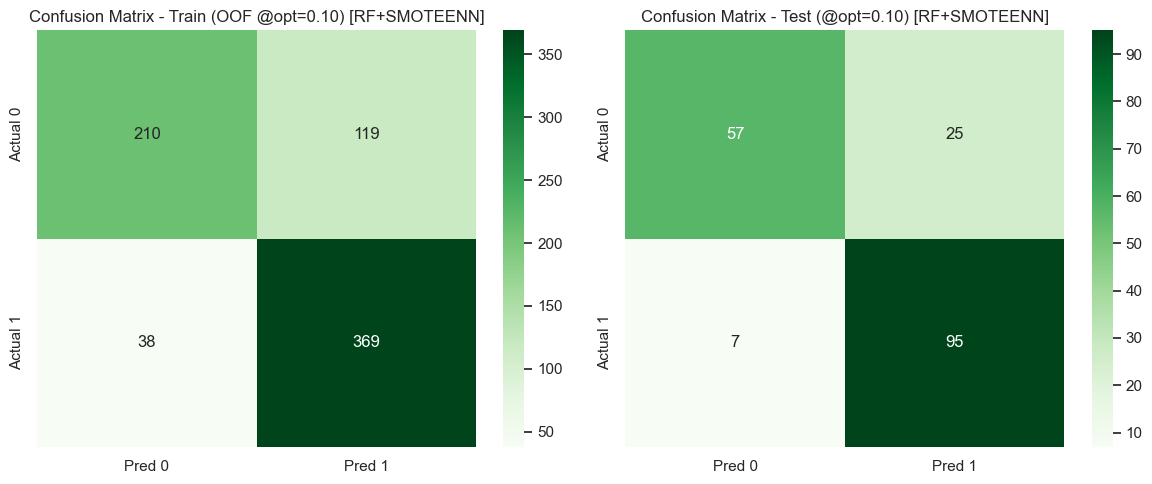


=== BRF+SMOTEENN Calibrated with PI-TopK ===
Train (OOF) @0.50: {'accuracy': 0.7853, 'roc_auc': np.float64(0.8569), 'recall': 0.8157, 'precision': 0.8, 'f1': 0.8078}
Train (OOF) @opt : {'accuracy': 0.7894, 'roc_auc': np.float64(0.8569), 'recall': 0.8943, 'precision': 0.7647, 'f1': 0.8245, 'threshold': np.float64(0.125)}
Test @0.50: {'accuracy': 0.8424, 'roc_auc': np.float64(0.9102), 'recall': 0.8627, 'precision': 0.8544, 'f1': 0.8585}
Test @opt : {'accuracy': 0.8207, 'roc_auc': np.float64(0.9102), 'recall': 0.9314, 'precision': 0.7851, 'f1': 0.852, 'threshold': np.float64(0.125)}


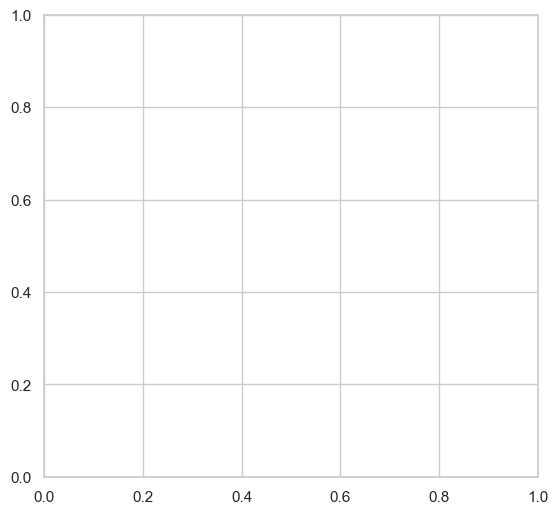

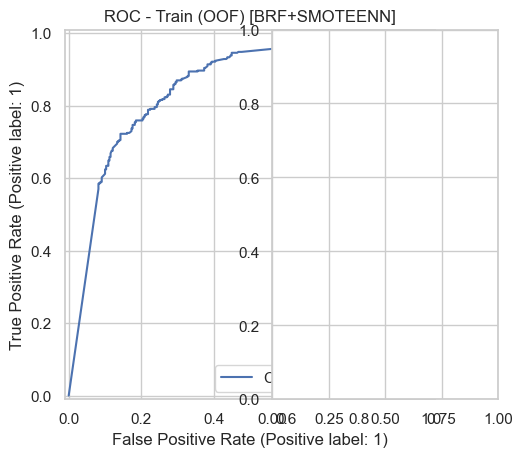

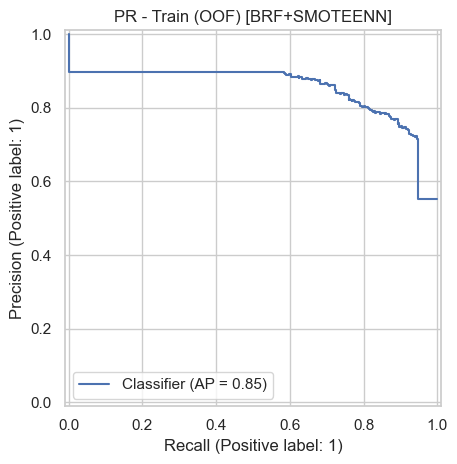

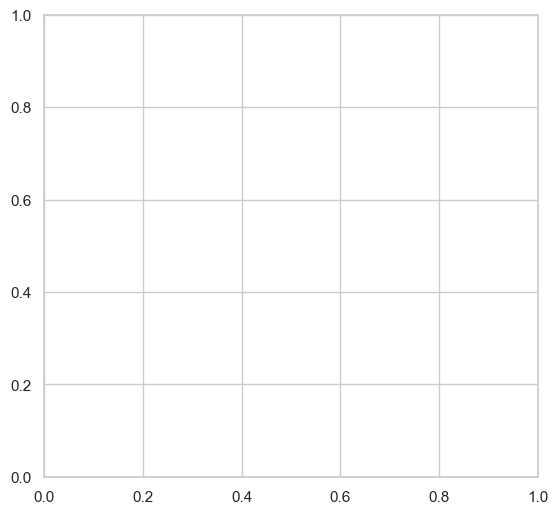

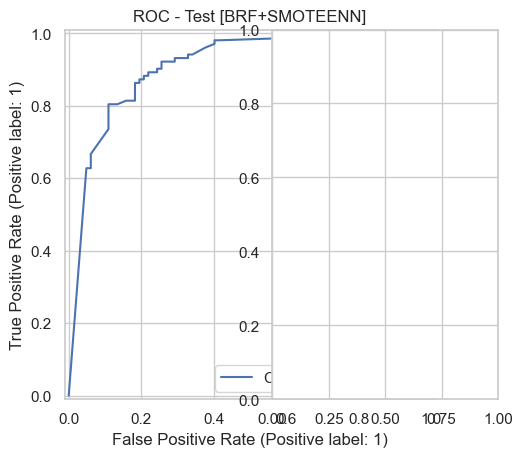

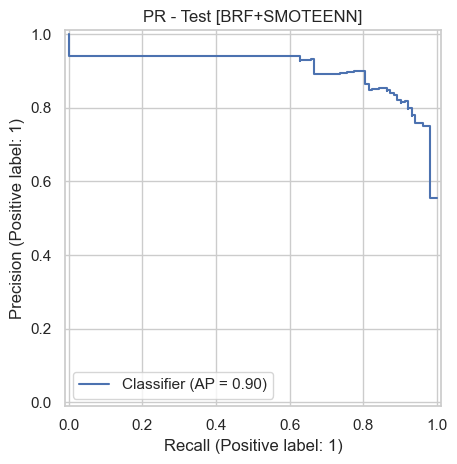

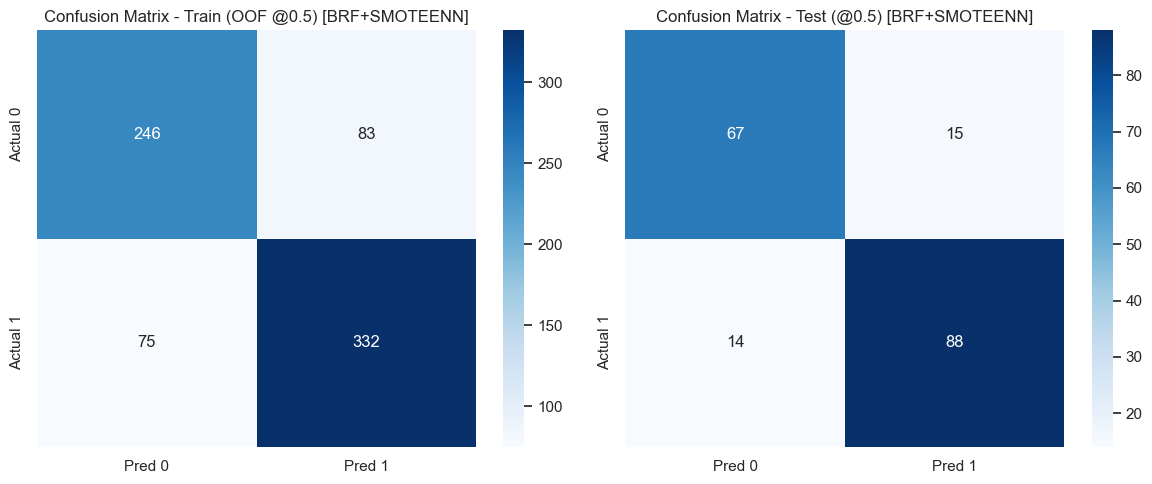

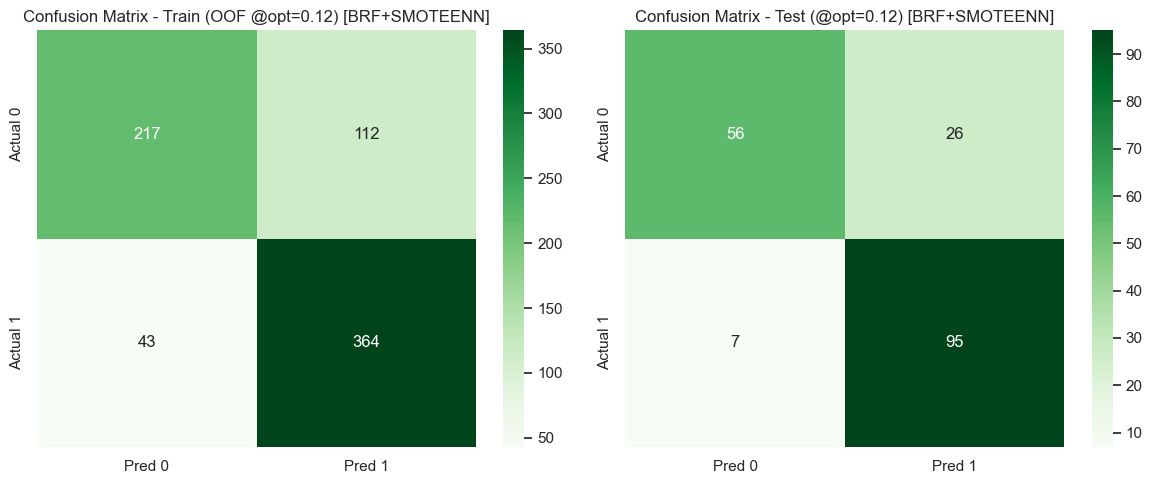

In [5]:
# ===== block 15: Full Pipelines (BRF, RF+SMOTEENN, BRF+SMOTEENN):  PI-based FS + AOA + Calibration + Evaluation (LEAK-SAFE) =====

# ===== 0) Leak-safe split: همین split در تمام این بلوک استفاده می‌شود =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== Feature selector compatible with your naming flow =====
class FeatureNameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessor=None, selected_feature_names=None):
        self.preprocessor = preprocessor
        self.selected_feature_names = selected_feature_names if selected_feature_names is not None else []
        self._idxs_ = None

    def fit(self, X, y=None):
        self.preprocessor.fit(X, y)
        all_feats = self.preprocessor.get_feature_names_out()
        name_to_idx = {n: i for i, n in enumerate(all_feats)}
        self._idxs_ = np.array(
            [name_to_idx[n] for n in self.selected_feature_names if n in name_to_idx],
            dtype=int
        )
        return self

    def transform(self, X):
        Xt = self.preprocessor.transform(X)
        if self._idxs_ is None or len(self._idxs_) == 0:
            return Xt
        return Xt[:, self._idxs_]

# ===== Full Pipelines (BRF, RF+SMOTEENN, BRF+SMOTEENN): PI-based FS + AOA + Calibration + Evaluation =====
# فرض: compute_perm_importance_topk از قبل تعریف شده و از build_pipeline استفاده می‌کند

from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN

# 1) Permutation Importance → Top-K (فقط روی داده‌ی TRAIN، برای جلوگیری از نشت)
K = 15
top_features, imp_df = compute_perm_importance_topk(
    X_train, y_train, num_cols, cat_cols, K=K, seed=42
)
print(f"Selected Top-{K} features (train only):", top_features)

# 2) سازنده‌های مشترک
num_pipe = SkPipeline([("imp", SimpleImputer(strategy="median")),
                       ("scaler", RobustScaler())])
cat_pipe = SkPipeline([("imp", SimpleImputer(strategy="most_frequent")),
                       ("ohe", OneHotEncoder(handle_unknown="ignore"))])
base_pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

def make_fs_calibrated_pipeline(base_estimator, selected_feature_names, sampler=None):
    feat_sel = FeatureNameSelector(
        preprocessor=base_pre,
        selected_feature_names=selected_feature_names
    )
    model_cal = CalibratedClassifierCV(base_estimator, method="isotonic", cv=5)
    steps = [("feat_pre", feat_sel)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", model_cal))
    return ImbPipeline(steps)

# 3) AOA ساده (max_iter=15, pop_size=24) برای هر مدل — فقط روی X_train, y_train
def aoa_optimize(build_estimator_fn, selected_feature_names, use_smoteen=False,
                 max_iter=15, pop_size=24, seed=42, label="GEN",
                 X_train=None, y_train=None):
    rng = np.random.RandomState(seed)
    sampler = SMOTEENN(random_state=seed) if use_smoteen else None

    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7)),
            "max_features": rng.choice(['sqrt', 'log2', None])
        }

    def fitness(p):
        est = build_estimator_fn(p)
        pipe = make_fs_calibrated_pipeline(
            est, selected_feature_names, sampler=sampler
        )
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        # فقط TRAIN وارد کراس‌ولیدیشن می‌شود
        oof_proba = cross_val_predict(
            pipe, X_train, y_train,
            cv=cv, method="predict_proba", n_jobs=-1
        )[:, 1]
        oof_pred = (oof_proba >= 0.5).astype(int)
        auc = roc_auc_score(y_train, oof_proba)
        rec = recall_score(y_train, oof_pred)
        f1 = f1_score(y_train, oof_pred)
        acc = accuracy_score(y_train, oof_pred)
        sc = 0.4 * auc + 0.4 * rec + 0.1 * f1 + 0.1 * acc
        return sc, {"auc": auc, "recall": rec, "f1": f1, "acc": acc}

    population = [sample_candidate() for _ in range(pop_size)]
    best_p, best_score, best_mets = None, -np.inf, None
    history = []

    for it in range(max_iter):
        new_pop = []
        for cand in population:
            c = cand.copy()
            # حرکت ساده به سمت بهترین راه‌حل
            if best_p is not None:
                c["n_estimators"] = int(
                    np.clip(
                        c["n_estimators"]
                        + (best_p["n_estimators"] - c["n_estimators"]) * 0.2,
                        150, 600
                    )
                )
                c["min_samples_split"] = int(
                    np.clip(
                        c["min_samples_split"]
                        + (best_p["min_samples_split"] - c["min_samples_split"]) * 0.2,
                        2, 12
                    )
                )
                c["min_samples_leaf"] = int(
                    np.clip(
                        c["min_samples_leaf"]
                        + (best_p["min_samples_leaf"] - c["min_samples_leaf"]) * 0.2,
                        1, 6
                    )
                )
            new_pop.append(c)

        for cand in new_pop:
            sc, mets = fitness(cand)
            history.append({"iter": it + 1, **cand, **mets, "score": sc})
            if sc > best_score:
                best_p, best_score, best_mets = cand, sc, mets

        population = new_pop
        print(
            f"Iter {it+1}/{max_iter} ({label}-Calib) | "
            f"Score={best_score:.4f} | "
            f"AUC={best_mets['auc']:.4f} | "
            f"F1={best_mets['f1']:.4f} | "
            f"ACC={best_mets['acc']:.4f} | "
            f"Recall={best_mets['recall']:.4f}"
        )

    hist_df = pd.DataFrame(history)
    return best_p, best_mets, hist_df

# 3.1) سازنده‌های estimator
def build_brf(p):
    return BalancedRandomForestClassifier(
        n_estimators=p["n_estimators"],
        max_depth=p["max_depth"],
        min_samples_split=p["min_samples_split"],
        min_samples_leaf=p["min_samples_leaf"],
        max_features=p["max_features"],
        random_state=42,
        n_jobs=-1
    )

def build_rf(p):
    return RandomForestClassifier(
        n_estimators=p["n_estimators"],
        max_depth=p["max_depth"],
        min_samples_split=p["min_samples_split"],
        min_samples_leaf=p["min_samples_leaf"],
        max_features=p["max_features"],
        random_state=42,
        n_jobs=-1
    )

# 4) اجرای AOA برای هر سه مدل (فقط روی TRAIN)
best_params_brf, best_mets_brf, hist_brf = aoa_optimize(
    build_brf, top_features, use_smoteen=False,
    max_iter=15, pop_size=24, seed=42, label="BRF",
    X_train=X_train, y_train=y_train
)
print("\nBest params (BRF):", best_params_brf)
print("Best CV metrics (BRF):", best_mets_brf)
display(
    hist_brf.groupby("iter")["score"].max()
    .reset_index().rename(columns={"score": "best_score"}).tail()
)

best_params_rf_sm, best_mets_rf_sm, hist_rf_sm = aoa_optimize(
    build_rf, top_features, use_smoteen=True,
    max_iter=15, pop_size=24, seed=42, label="RF+SMOTEENN",
    X_train=X_train, y_train=y_train
)
print("\nBest params (RF+SMOTEENN):", best_params_rf_sm)
print("Best CV metrics (RF+SMOTEENN):", best_mets_rf_sm)
display(
    hist_rf_sm.groupby("iter")["score"].max()
    .reset_index().rename(columns={"score": "best_score"}).tail()
)

best_params_brf_sm, best_mets_brf_sm, hist_brf_sm = aoa_optimize(
    build_brf, top_features, use_smoteen=True,
    max_iter=15, pop_size=24, seed=42, label="BRF+SMOTEENN",
    X_train=X_train, y_train=y_train
)
print("\nBest params (BRF+SMOTEENN):", best_params_brf_sm)
print("Best CV metrics (BRF+SMOTEENN):", best_mets_brf_sm)
display(
    hist_brf_sm.groupby("iter")["score"].max()
    .reset_index().rename(columns={"score": "best_score"}).tail()
)

# 5) ساخت پایپلاین‌های نهایی (FS + Calibration [+ SMOTEENN]) با بهترین پارامترها
pipe_brf_fs_calib = make_fs_calibrated_pipeline(
    build_brf(best_params_brf), top_features, sampler=None
)
pipe_rf_sm_fs_calib = make_fs_calibrated_pipeline(
    build_rf(best_params_rf_sm), top_features,
    sampler=SMOTEENN(random_state=42)
)
pipe_brf_sm_fs_calib = make_fs_calibrated_pipeline(
    build_brf(best_params_brf_sm), top_features,
    sampler=SMOTEENN(random_state=42)
)

# 6) CV object برای OOF روی TRAIN
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 7) Helperهای مشترک ارزیابی
def oof_block(pipe, X_tr, y_tr):
    proba_tr = cross_val_predict(
        pipe, X_tr, y_tr, cv=cv, method="predict_proba", n_jobs=-1
    )[:, 1]
    pred_tr_05 = (proba_tr >= 0.5).astype(int)
    t_opt, _ = find_best_threshold(y_tr, proba_tr, metric="f1")
    pred_tr_opt = (proba_tr >= t_opt).astype(int)

    mets_tr_05 = {
        "accuracy": accuracy_score(y_tr, pred_tr_05),
        "roc_auc": roc_auc_score(y_tr, proba_tr),
        "recall": recall_score(y_tr, pred_tr_05),
        "precision": precision_score(y_tr, pred_tr_05),
        "f1": f1_score(y_tr, pred_tr_05),
    }
    mets_tr_opt = {
        "accuracy": accuracy_score(y_tr, pred_tr_opt),
        "roc_auc": roc_auc_score(y_tr, proba_tr),
        "recall": recall_score(y_tr, pred_tr_opt),
        "precision": precision_score(y_tr, pred_tr_opt),
        "f1": f1_score(y_tr, pred_tr_opt),
        "threshold": t_opt,
    }
    return proba_tr, mets_tr_05, mets_tr_opt, t_opt

def test_block(pipe, X_te, y_te, t_opt):
    proba_te = pipe.predict_proba(X_te)[:, 1]
    pred_te_05 = (proba_te >= 0.5).astype(int)
    pred_te_opt = (proba_te >= t_opt).astype(int)

    mets_te_05 = {
        "accuracy": accuracy_score(y_te, pred_te_05),
        "roc_auc": roc_auc_score(y_te, proba_te),
        "recall": recall_score(y_te, pred_te_05),
        "precision": precision_score(y_te, pred_te_05),
        "f1": f1_score(y_te, pred_te_05),
    }
    mets_te_opt = {
        "accuracy": accuracy_score(y_te, pred_te_opt),
        "roc_auc": roc_auc_score(y_te, proba_te),
        "recall": recall_score(y_te, pred_te_opt),
        "precision": precision_score(y_te, pred_te_opt),
        "f1": f1_score(y_te, pred_te_opt),
        "threshold": t_opt,
    }
    return proba_te, mets_te_05, mets_te_opt

def full_eval(pipe, name):
    # OOF روی TRAIN
    proba_tr, tr05, tropt, t_opt = oof_block(pipe, X_train, y_train)

    # Fit نهایی روی TRAIN و ارزیابی روی TEST
    pipe.fit(X_train, y_train)
    proba_te, te05, teopt = test_block(pipe, X_test, y_test, t_opt)

    print(f"\n=== {name} Calibrated with PI-TopK ===")
    print("Train (OOF) @0.50:", {k: round(v, 4) for k, v in tr05.items()})
    print("Train (OOF) @opt :", {k: round(v, 4) for k, v in tropt.items()})
    print("Test @0.50:", {k: round(v, 4) for k, v in te05.items()})
    print("Test @opt :", {k: round(v, 4) for k, v in teopt.items()})

    # ROC & PR
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(y_train, proba_tr)
    plt.title(f"ROC - Train (OOF) [{name}]")
    plt.subplot(1, 2, 2)
    PrecisionRecallDisplay.from_predictions(y_train, proba_tr)
    plt.title(f"PR - Train (OOF) [{name}]")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(y_test, proba_te)
    plt.title(f"ROC - Test [{name}]")
    plt.subplot(1, 2, 2)
    PrecisionRecallDisplay.from_predictions(y_test, proba_te)
    plt.title(f"PR - Test [{name}]")
    plt.tight_layout()
    plt.show()

    # Confusion Matrices @0.5
    pred_tr_05 = (proba_tr >= 0.5).astype(int)
    pred_te_05 = (proba_te >= 0.5).astype(int)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(
        confusion_matrix(y_train, pred_tr_05),
        annot=True, fmt="d", cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["Actual 0", "Actual 1"],
    )
    plt.title(f"Confusion Matrix - Train (OOF @0.5) [{name}]")
    plt.subplot(1, 2, 2)
    sns.heatmap(
        confusion_matrix(y_test, pred_te_05),
        annot=True, fmt="d", cmap="Blues",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["Actual 0", "Actual 1"],
    )
    plt.title(f"Confusion Matrix - Test (@0.5) [{name}]")
    plt.tight_layout()
    plt.show()

    # Confusion Matrices @opt
    pred_tr_opt = (proba_tr >= tropt["threshold"]).astype(int)
    pred_te_opt = (proba_te >= tropt["threshold"]).astype(int)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(
        confusion_matrix(y_train, pred_tr_opt),
        annot=True, fmt="d", cmap="Greens",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["Actual 0", "Actual 1"],
    )
    plt.title(
        f"Confusion Matrix - Train (OOF @opt={tropt['threshold']:.2f}) [{name}]"
    )
    plt.subplot(1, 2, 2)
    sns.heatmap(
        confusion_matrix(y_test, pred_te_opt),
        annot=True, fmt="d", cmap="Greens",
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["Actual 0", "Actual 1"],
    )
    plt.title(
        f"Confusion Matrix - Test (@opt={tropt['threshold']:.2f}) [{name}]"
    )
    plt.tight_layout()
    plt.show()

    return dict(train_05=tr05, train_opt=tropt, test_05=te05, test_opt=teopt)

# 8) ارزیابی کامل برای هر سه مدل
res_brf    = full_eval(pipe_brf_fs_calib,    "BRF")
res_rf_sm  = full_eval(pipe_rf_sm_fs_calib,  "RF+SMOTEENN")
res_brf_sm = full_eval(pipe_brf_sm_fs_calib, "BRF+SMOTEENN")


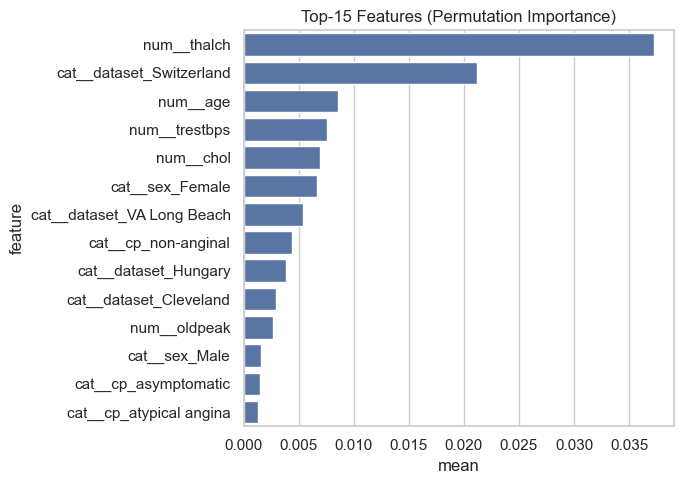

Selected Top-15 features: ['num__thalch', 'cat__dataset_Switzerland', 'num__age', 'num__trestbps', 'num__chol', 'cat__sex_Female', 'cat__dataset_VA Long Beach', 'cat__cp_non-anginal', 'cat__dataset_Hungary', 'cat__dataset_Cleveland', 'num__oldpeak', 'cat__sex_Male', 'cat__cp_asymptomatic', 'cat__cp_atypical angina']
Iter 1/15 | Score=0.8590 | AUC=0.8682 | F1=0.8285 | ACC=0.8003 | Recall=0.8722
Iter 2/15 | Score=0.8622 | AUC=0.8678 | F1=0.8306 | ACC=0.8016 | Recall=0.8796
Iter 3/15 | Score=0.8654 | AUC=0.8722 | F1=0.8329 | ACC=0.8043 | Recall=0.8821
Iter 4/15 | Score=0.8654 | AUC=0.8722 | F1=0.8329 | ACC=0.8043 | Recall=0.8821
Iter 5/15 | Score=0.8654 | AUC=0.8722 | F1=0.8329 | ACC=0.8043 | Recall=0.8821
Iter 6/15 | Score=0.8654 | AUC=0.8722 | F1=0.8329 | ACC=0.8043 | Recall=0.8821
Iter 7/15 | Score=0.8654 | AUC=0.8722 | F1=0.8329 | ACC=0.8043 | Recall=0.8821
Iter 8/15 | Score=0.8654 | AUC=0.8722 | F1=0.8329 | ACC=0.8043 | Recall=0.8821
Iter 9/15 | Score=0.8654 | AUC=0.8722 | F1=0.8329 

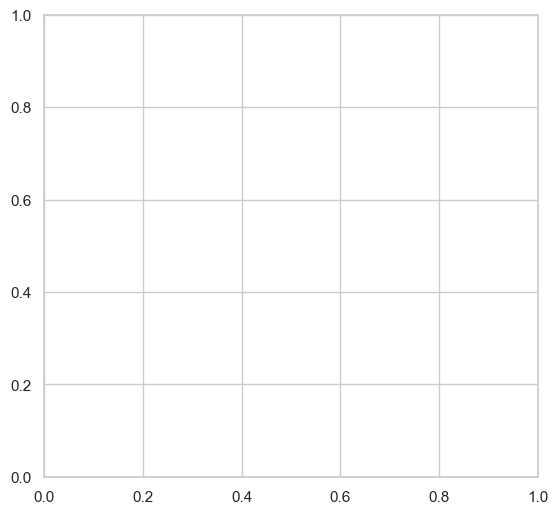

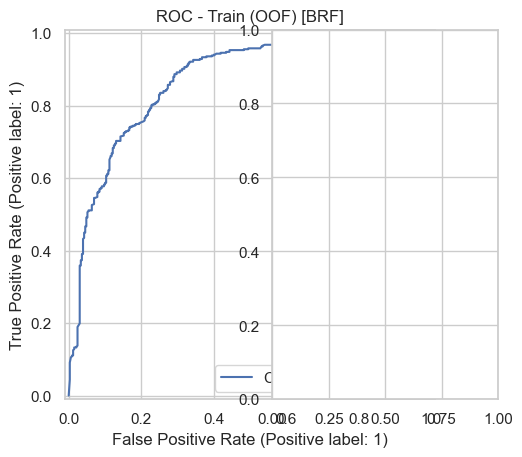

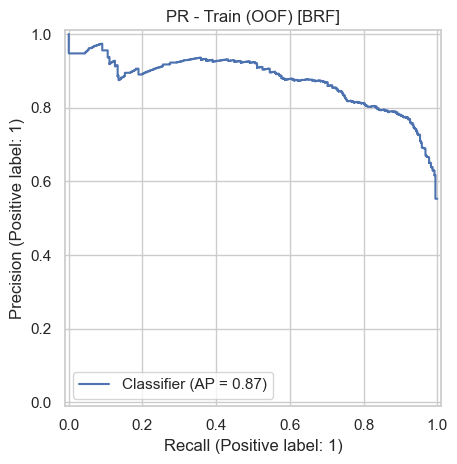

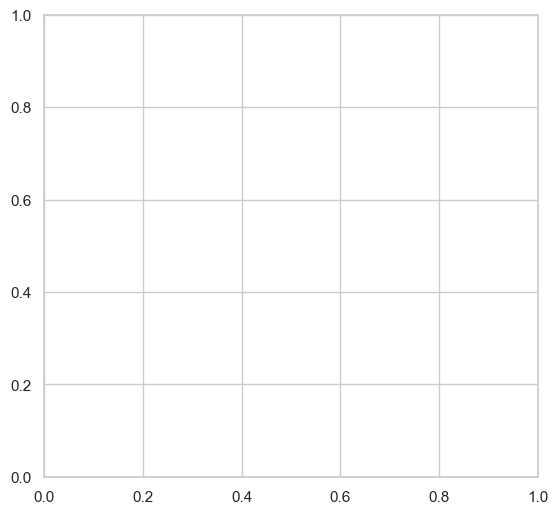

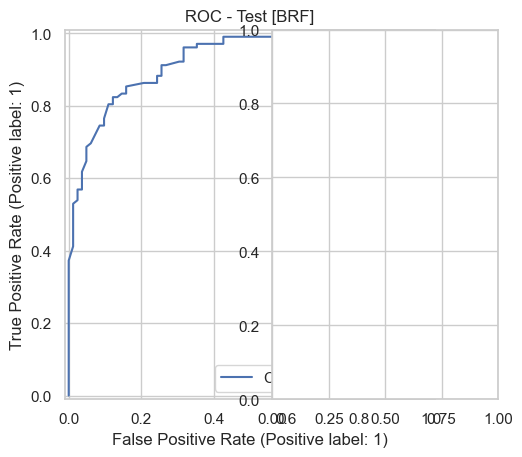

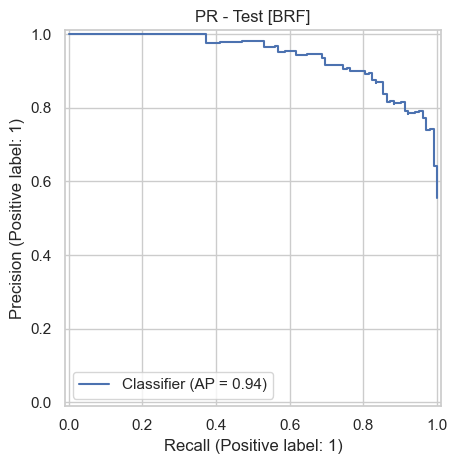

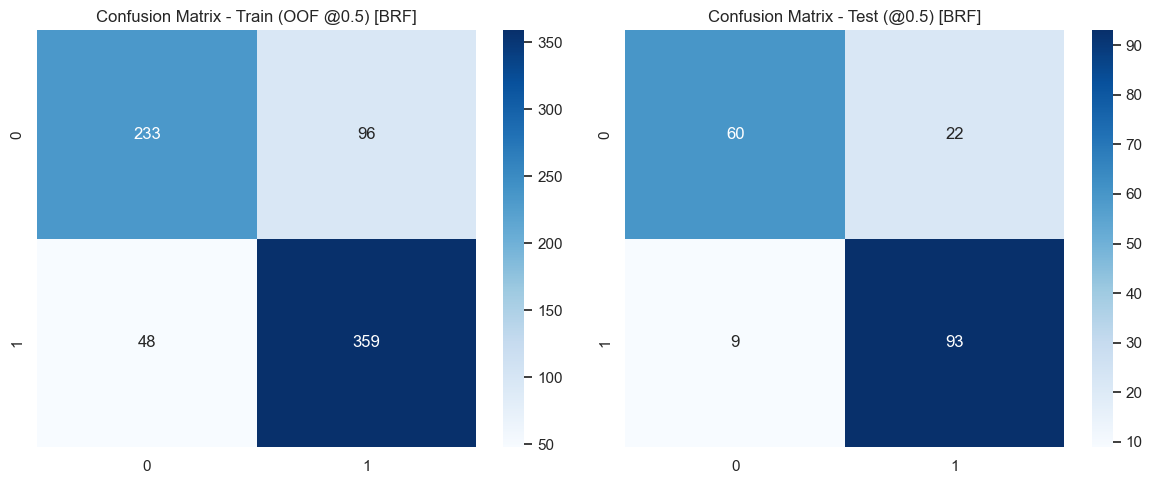

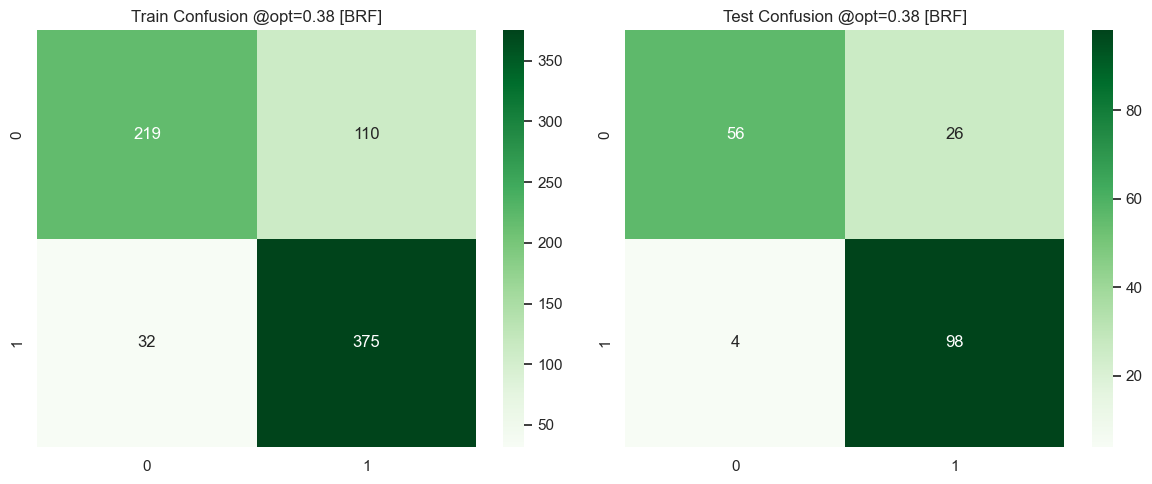


=== RF+SMOTEENN Calibrated with PI-TopK ===
Train (OOF) @0.50: {'accuracy': 0.7853, 'roc_auc': np.float64(0.8559), 'recall': 0.8206, 'precision': 0.7971, 'f1': 0.8087}
Train (OOF) @opt : {'accuracy': 0.7948, 'roc_auc': np.float64(0.8559), 'recall': 0.8993, 'precision': 0.7689, 'f1': 0.829, 'threshold': np.float64(0.1307)}
Test        @0.50: {'accuracy': 0.8424, 'roc_auc': np.float64(0.903), 'recall': 0.8529, 'precision': 0.8614, 'f1': 0.8571}
Test        @opt : {'accuracy': 0.8098, 'roc_auc': np.float64(0.903), 'recall': 0.9314, 'precision': 0.7724, 'f1': 0.8444, 'threshold': np.float64(0.1307)}


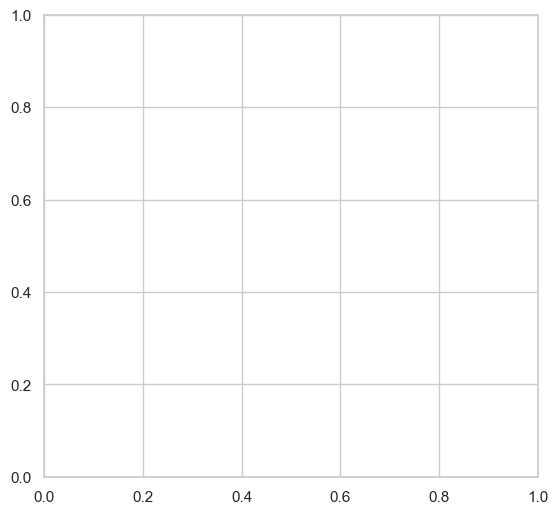

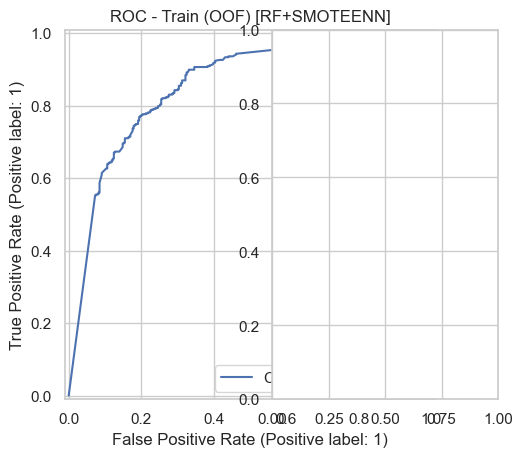

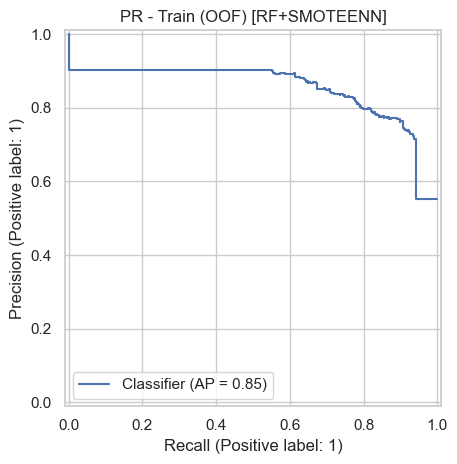

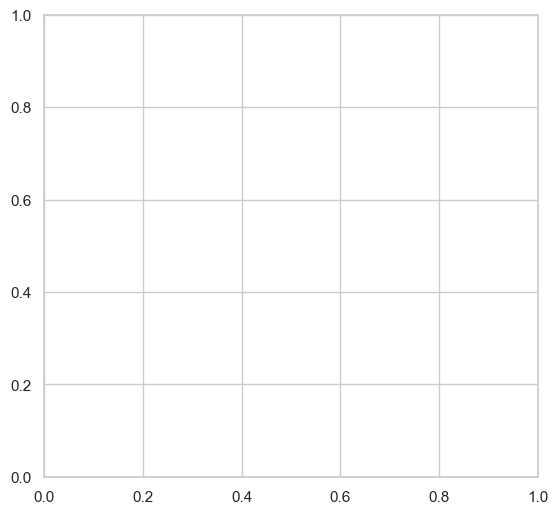

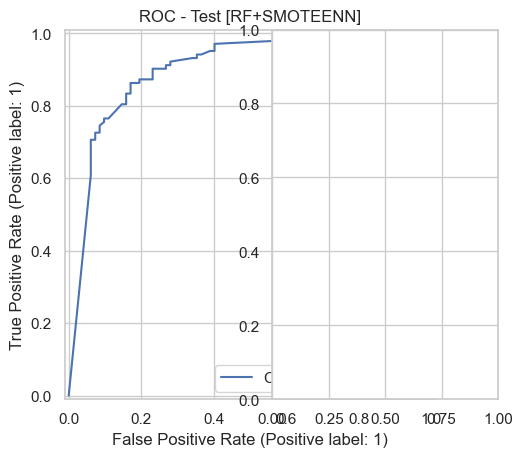

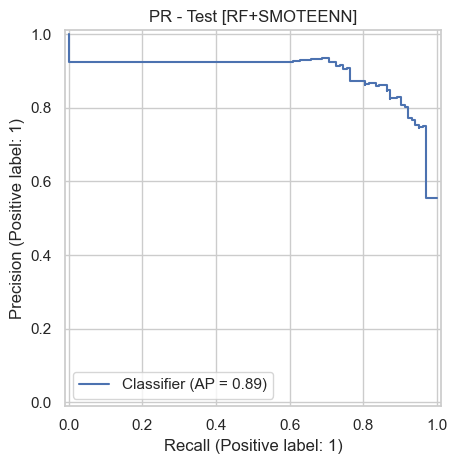

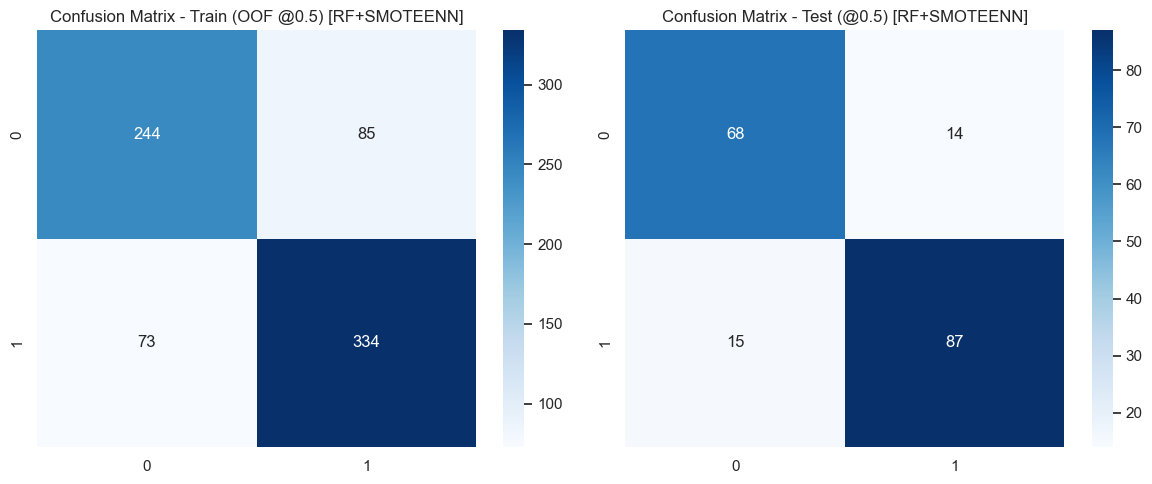

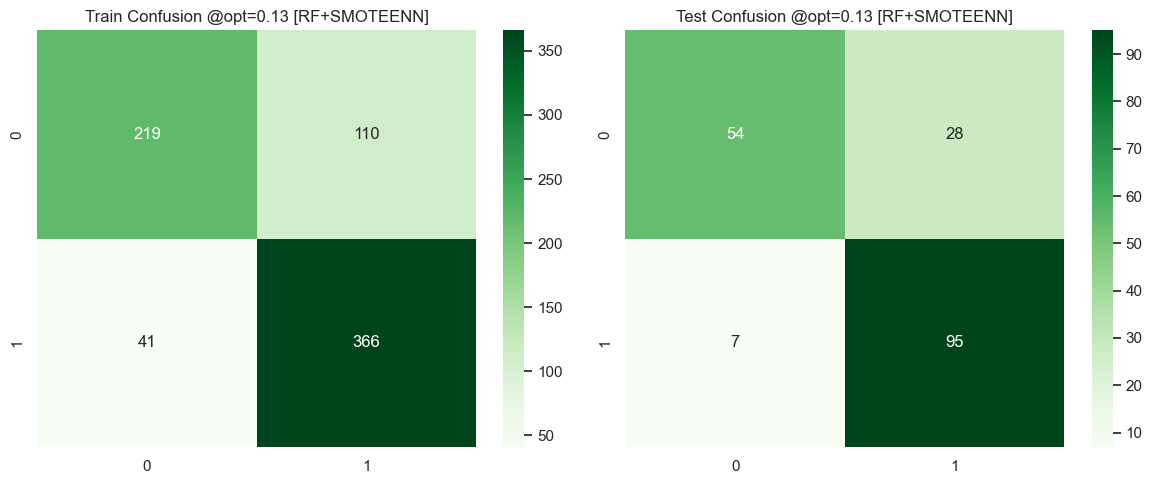


=== BRF+SMOTEENN Calibrated with PI-TopK ===
Train (OOF) @0.50: {'accuracy': 0.7867, 'roc_auc': np.float64(0.8547), 'recall': 0.8206, 'precision': 0.799, 'f1': 0.8097}
Train (OOF) @opt : {'accuracy': 0.7853, 'roc_auc': np.float64(0.8547), 'recall': 0.914, 'precision': 0.7515, 'f1': 0.8248, 'threshold': np.float64(0.0553)}
Test        @0.50: {'accuracy': 0.8424, 'roc_auc': np.float64(0.8965), 'recall': 0.8824, 'precision': 0.8411, 'f1': 0.8612}
Test        @opt : {'accuracy': 0.8098, 'roc_auc': np.float64(0.8965), 'recall': 0.9314, 'precision': 0.7724, 'f1': 0.8444, 'threshold': np.float64(0.0553)}


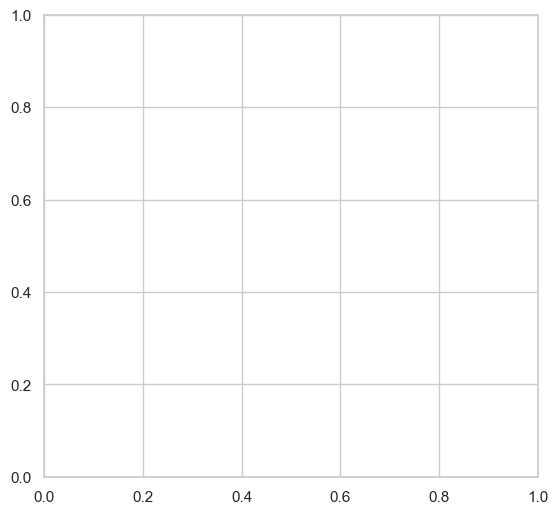

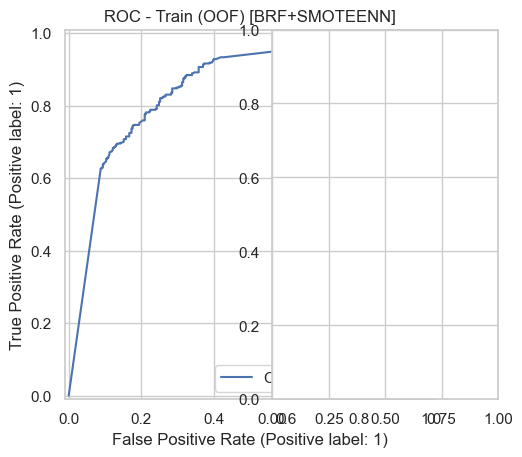

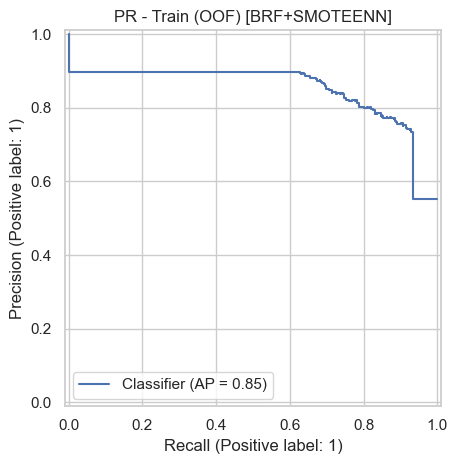

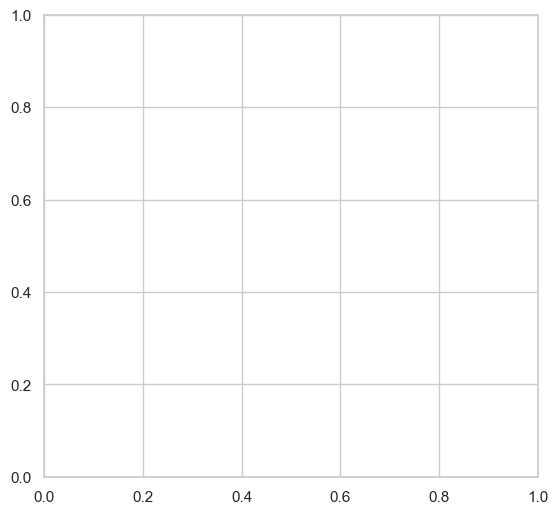

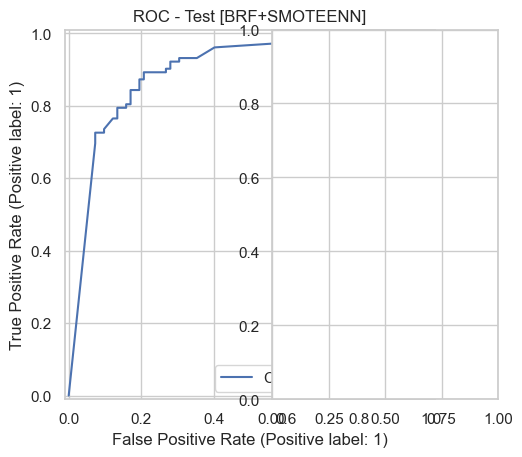

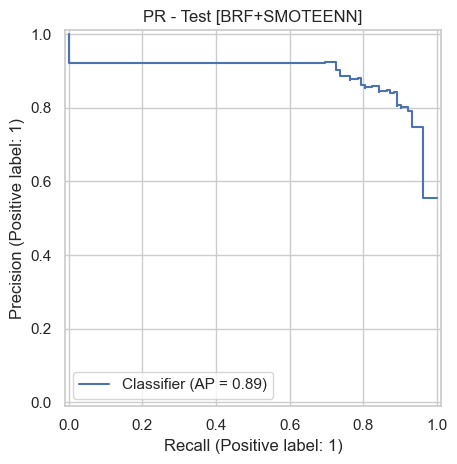

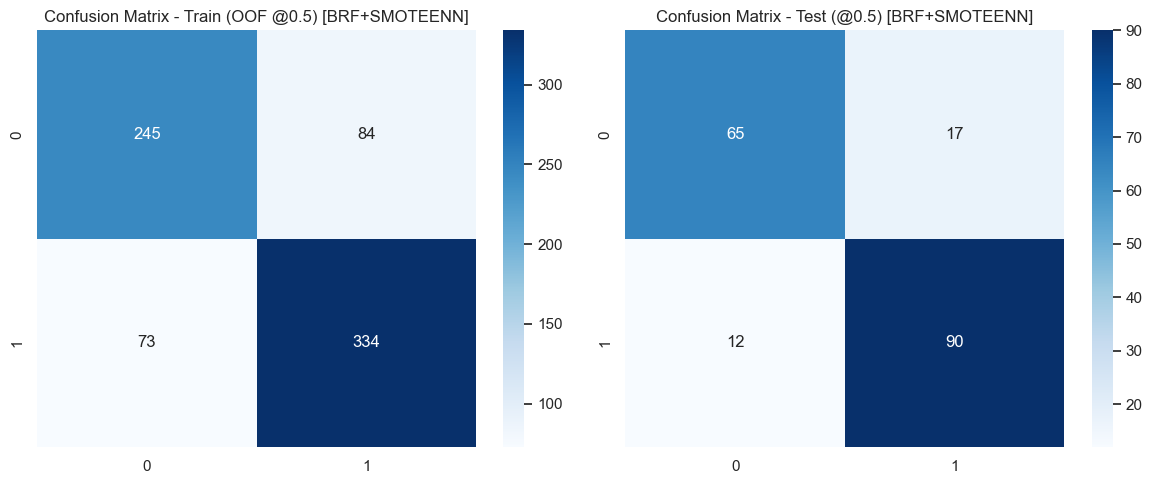

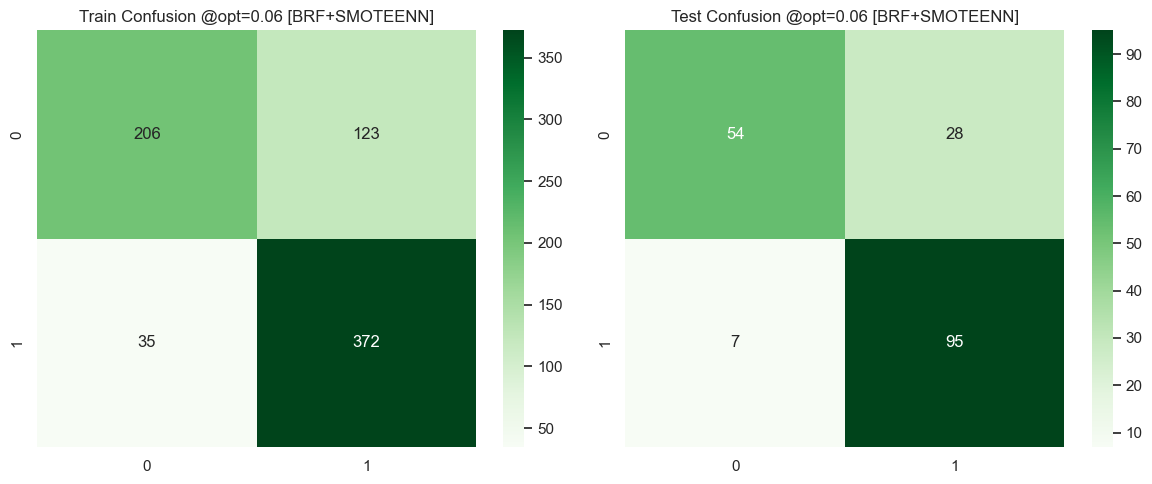

In [5]:
# ===== block 16: Full Pipelines — PI-based FS + AOA++ + Calibration + Evaluation (LEAK-SAFE) =====

import os, random
def set_all_seeds(seed=42):
    import numpy as np
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_all_seeds(42)

from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN

# -----------------------------------------------------------------------------------------
# 0) LEAK-SAFE TRAIN/TEST SPLIT
# -----------------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------------------------------------------------------------------
# 1) Permutation Importance → Top-K
# -----------------------------------------------------------------------------------------
K = 15
top_features, imp_df = compute_perm_importance_topk(
    X_train, y_train, num_cols, cat_cols, K=K, seed=42
)
print(f"Selected Top-{K} features:", top_features)

# -----------------------------------------------------------------------------------------
# 2) Preprocessing pipeline
# -----------------------------------------------------------------------------------------
num_pipe = SkPipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])
cat_pipe = SkPipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
base_pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

def make_fs_calibrated_pipeline(base_estimator, selected_feature_names, sampler=None):
    feat_sel = FeatureNameSelector(
        preprocessor=base_pre,
        selected_feature_names=selected_feature_names
    )
    model_cal = CalibratedClassifierCV(base_estimator, method="isotonic", cv=5)

    steps = [("feat_pre", feat_sel)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", model_cal))
    return ImbPipeline(steps)

# -----------------------------------------------------------------------------------------
# 3) AOA++ (deterministic)
# -----------------------------------------------------------------------------------------
def aoa_optimize_generic(build_estimator_fn, selected_feature_names, use_smoteen=False,
                         max_iter=15, pop_size=24, seed=42, label="GEN"):
    
    rng = np.random.RandomState(seed)
    sampler = SMOTEENN(random_state=seed) if use_smoteen else None

    def sample_candidate():
        return {
            "n_estimators": int(rng.randint(150, 601)),
            "max_depth": rng.choice([None, 3, 5, 7, 10]),
            "min_samples_split": int(rng.randint(2, 13)),
            "min_samples_leaf": int(rng.randint(1, 7)),
            "max_features": rng.choice(['sqrt', 'log2', None])
        }

    def fitness(p):
        est = build_estimator_fn(p)
        pipe = make_fs_calibrated_pipeline(est, selected_feature_names, sampler=sampler)

        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

        oof_proba = cross_val_predict(
            pipe, X_train, y_train,
            cv=cv, method="predict_proba", n_jobs=-1
        )[:, 1]

        oof_pred = (oof_proba >= 0.5).astype(int)

        auc = roc_auc_score(y_train, oof_proba)
        rec = recall_score(y_train, oof_pred)
        f1  = f1_score(y_train, oof_pred)
        acc = accuracy_score(y_train, oof_pred)

        score = 0.4*auc + 0.4*rec + 0.1*f1 + 0.1*acc
        return score, {"auc": auc, "recall": rec, "f1": f1, "acc": acc}

    population = [sample_candidate() for _ in range(pop_size)]
    best_p, best_score, best_mets = None, -999, None
    history = []

    for it in range(max_iter):

        new_pop = []
        for cand in population:
            c = cand.copy()

            if rng.rand() < 0.6:
                c["n_estimators"] = int(np.clip(
                    c["n_estimators"] + rng.normal(0, 80), 150, 600))

            if rng.rand() < 0.4:
                c["max_depth"] = rng.choice([None, 3, 5, 7, 10])

            if rng.rand() < 0.5:
                c["min_samples_split"] = int(np.clip(
                    c["min_samples_split"] + rng.randint(-2, 3), 2, 12))

            if rng.rand() < 0.5:
                c["min_samples_leaf"] = int(np.clip(
                    c["min_samples_leaf"] + rng.randint(-1, 2), 1, 6))

            if rng.rand() < 0.4:
                c["max_features"] = rng.choice(['sqrt', 'log2', None])

            new_pop.append(c)

        for cand in new_pop:
            sc, mets = fitness(cand)
            history.append({"iter": it+1, **cand, **mets, "score": sc})
            if sc > best_score:
                best_p, best_score, best_mets = cand, sc, mets

        population = new_pop

        print(
            f"Iter {it+1}/{max_iter} | "
            f"Score={best_score:.4f} | "
            f"AUC={best_mets['auc']:.4f} | "
            f"F1={best_mets['f1']:.4f} | "
            f"ACC={best_mets['acc']:.4f} | "
            f"Recall={best_mets['recall']:.4f}"
        )

    return best_p, best_mets, pd.DataFrame(history)

# -----------------------------------------------------------------------------------------
# 3.1) Estimators (n_jobs=-1)
# -----------------------------------------------------------------------------------------
def build_brf(p):
    return BalancedRandomForestClassifier(
        n_estimators=p["n_estimators"],
        max_depth=p["max_depth"],
        min_samples_split=p["min_samples_split"],
        min_samples_leaf=p["min_samples_leaf"],
        max_features=p["max_features"],
        random_state=42,
        n_jobs=-1
    )

def build_rf(p):
    return RandomForestClassifier(
        n_estimators=p["n_estimators"],
        max_depth=p["max_depth"],
        min_samples_split=p["min_samples_split"],
        min_samples_leaf=p["min_samples_leaf"],
        max_features=p["max_features"],
        random_state=42,
        n_jobs=-1
    )

# -----------------------------------------------------------------------------------------
# 4) Run AOA++
# -----------------------------------------------------------------------------------------
best_params_brf,    best_mets_brf,    hist_brf    = aoa_optimize_generic(build_brf, top_features, use_smoteen=False, seed=42, label="BRF")
best_params_rf_sm,  best_mets_rf_sm,  hist_rf_sm  = aoa_optimize_generic(build_rf, top_features, use_smoteen=True,  seed=42, label="RF+SMOTEENN")
best_params_brf_sm, best_mets_brf_sm, hist_brf_sm = aoa_optimize_generic(build_brf, top_features, use_smoteen=True,  seed=42, label="BRF+SMOTEENN")

# -----------------------------------------------------------------------------------------
# 5) FINAL PIPELINES
# -----------------------------------------------------------------------------------------
pipe_brf_fs_calib    = make_fs_calibrated_pipeline(build_brf(best_params_brf),       top_features)
pipe_rf_sm_fs_calib  = make_fs_calibrated_pipeline(build_rf(best_params_rf_sm),      top_features, sampler=SMOTEENN(random_state=42))
pipe_brf_sm_fs_calib = make_fs_calibrated_pipeline(build_brf(best_params_brf_sm),    top_features, sampler=SMOTEENN(random_state=42))

# -----------------------------------------------------------------------------------------
# 6) CV object for OOF
# -----------------------------------------------------------------------------------------
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# -----------------------------------------------------------------------------------------
# 7) THRESHOLD OPTIMIZATION FUNCTION (missing one!)
# -----------------------------------------------------------------------------------------
def find_best_threshold(y_true, y_proba, metric="f1"):
    thresholds = np.linspace(0,1,200)
    best_thr = 0.5
    best_score = -1

    for thr in thresholds:
        preds = (y_proba >= thr).astype(int)

        if metric=="f1":
            score = f1_score(y_true, preds)
        elif metric=="recall":
            score = recall_score(y_true, preds)
        elif metric=="precision":
            score = precision_score(y_true, preds)
        else:
            score = f1_score(y_true, preds)

        if score > best_score:
            best_score = score
            best_thr = thr

    return best_thr, best_score

# -----------------------------------------------------------------------------------------
# 8) EVALUATION BLOCKS (oof_block, test_block, full_eval)
# -----------------------------------------------------------------------------------------
def oof_block(pipe, X_tr, y_tr):
    proba_tr = cross_val_predict(
        pipe, X_tr, y_tr, cv=cv, method="predict_proba", n_jobs=-1
    )[:,1]

    pred_tr_05 = (proba_tr >= 0.5).astype(int)

    t_opt, _ = find_best_threshold(y_tr, proba_tr, metric="f1")
    pred_tr_opt = (proba_tr >= t_opt).astype(int)

    mets_tr_05 = {
        "accuracy": accuracy_score(y_tr, pred_tr_05),
        "roc_auc": roc_auc_score(y_tr, proba_tr),
        "recall": recall_score(y_tr, pred_tr_05),
        "precision": precision_score(y_tr, pred_tr_05),
        "f1": f1_score(y_tr, pred_tr_05),
    }
    mets_tr_opt = {
        "accuracy": accuracy_score(y_tr, pred_tr_opt),
        "roc_auc": roc_auc_score(y_tr, proba_tr),
        "recall": recall_score(y_tr, pred_tr_opt),
        "precision": precision_score(y_tr, pred_tr_opt),
        "f1": f1_score(y_tr, pred_tr_opt),
        "threshold": t_opt,
    }
    return proba_tr, mets_tr_05, mets_tr_opt, t_opt


def test_block(pipe, X_te, y_te, t_opt):
    proba_te = pipe.predict_proba(X_te)[:,1]

    pred_te_05 = (proba_te >= 0.5).astype(int)
    pred_te_opt = (proba_te >= t_opt).astype(int)

    mets_te_05 = {
        "accuracy": accuracy_score(y_te, pred_te_05),
        "roc_auc": roc_auc_score(y_te, proba_te),
        "recall": recall_score(y_te, pred_te_05),
        "precision": precision_score(y_te, pred_te_05),
        "f1": f1_score(y_te, pred_te_05),
    }
    mets_te_opt = {
        "accuracy": accuracy_score(y_te, pred_te_opt),
        "roc_auc": roc_auc_score(y_te, proba_te),
        "recall": recall_score(y_te, pred_te_opt),
        "precision": precision_score(y_te, pred_te_opt),
        "f1": f1_score(y_te, pred_te_opt),
        "threshold": t_opt,
    }
    return proba_te, mets_te_05, mets_te_opt


def full_eval(pipe, name):
    proba_tr, tr05, tropt, t_opt = oof_block(pipe, X_train, y_train)

    pipe.fit(X_train, y_train)
    proba_te, te05, teopt = test_block(pipe, X_test, y_test, t_opt)

    print(f"\n=== {name} Calibrated with PI-TopK ===")
    print("Train (OOF) @0.50:", {k: round(v,4) for k,v in tr05.items()})
    print("Train (OOF) @opt :", {k: round(v,4) for k,v in tropt.items()})
    print("Test        @0.50:", {k: round(v,4) for k,v in te05.items()})
    print("Test        @opt :", {k: round(v,4) for k,v in teopt.items()})

    # ROC & PR plots
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1); RocCurveDisplay.from_predictions(y_train, proba_tr); plt.title(f"ROC - Train (OOF) [{name}]")
    plt.subplot(1,2,2); PrecisionRecallDisplay.from_predictions(y_train, proba_tr); plt.title(f"PR - Train (OOF) [{name}]")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1); RocCurveDisplay.from_predictions(y_test,  proba_te); plt.title(f"ROC - Test [{name}]")
    plt.subplot(1,2,2); PrecisionRecallDisplay.from_predictions(y_test,  proba_te); plt.title(f"PR - Test [{name}]")
    plt.tight_layout(); plt.show()

    # ⬇ Confusion @0.50
    pred_tr_05 = (proba_tr >= 0.5).astype(int)
    pred_te_05 = (proba_te >= 0.5).astype(int)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1);
    sns.heatmap(confusion_matrix(y_train, pred_tr_05), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Train (OOF @0.5) [{name}]")
    plt.subplot(1,2,2);
    sns.heatmap(confusion_matrix(y_test,  pred_te_05), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - Test (@0.5) [{name}]")
    plt.tight_layout(); plt.show()

    # ⬇ Confusion @OPT
    pred_tr_opt = (proba_tr >= tropt["threshold"]).astype(int)
    pred_te_opt = (proba_te >= tropt["threshold"]).astype(int)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1);
    sns.heatmap(confusion_matrix(y_train, pred_tr_opt), annot=True, fmt="d", cmap="Greens")
    plt.title(f"Train Confusion @opt={tropt['threshold']:.2f} [{name}]")
    plt.subplot(1,2,2);
    sns.heatmap(confusion_matrix(y_test,  pred_te_opt), annot=True, fmt="d", cmap="Greens")
    plt.title(f"Test Confusion @opt={tropt['threshold']:.2f} [{name}]")
    plt.tight_layout(); plt.show()

    return dict(train_05=tr05, train_opt=tropt, test_05=te05, test_opt=teopt)

# -----------------------------------------------------------------------------------------
# 9) FINAL RESULTS
# -----------------------------------------------------------------------------------------
res_brf    = full_eval(pipe_brf_fs_calib,    "BRF")
res_rf_sm  = full_eval(pipe_rf_sm_fs_calib,  "RF+SMOTEENN")
res_brf_sm = full_eval(pipe_brf_sm_fs_calib, "BRF+SMOTEENN")



SHAP ANALYSIS FOR BEST MODEL: BRF (PI-Top15 + Calibrated + No SMOTEENN)
Computing SHAP values using TreeExplainer (tree_path_dependent + raw)...
Raw SHAP values shape: (184, 14, 2)
Selected SHAP values (class 1) shape: (184, 14)
ΔProbability SHAP values shape: (184, 14)


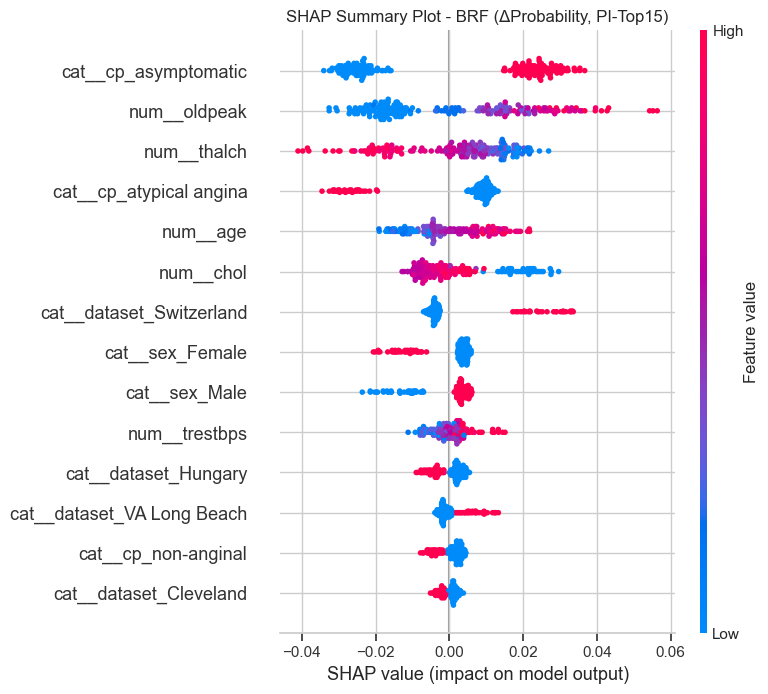

<Figure size 800x600 with 0 Axes>

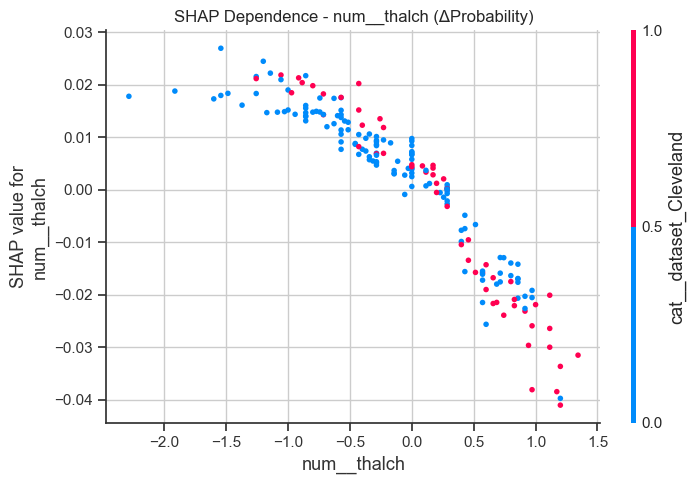


Top feature by Permutation Importance: num__thalch
Generating interactive force plot...


Interactive force plot saved: shap_force_brf_sample.html

SHAP ANALYSIS COMPLETED SUCCESSFULLY!
• Model: Balanced Random Forest
• Features: Top 15 via Permutation Importance
• Output: ΔProbability (clinically interpretable)
• Files saved: shap_summary_brf.png, shap_dependence_*.png, shap_force_brf_sample.html


In [8]:
# ===== Block 17: SHAP (Summary + Dependence) - FINAL, ERROR-FREE, PUBLICATION-READY =====

import scipy.sparse as sp

print("\n" + "="*70)
print("SHAP ANALYSIS FOR BEST MODEL: BRF (PI-Top15 + Calibrated + No SMOTEENN)")
print("="*70)

# 1) استخراج مدل پایه
final_brf_model = pipe_brf_fs_calib.named_steps['model']
base_brf = final_brf_model.calibrated_classifiers_[0].estimator

# 2) پیش‌پردازش داده‌های تست
X_test_processed = pipe_brf_fs_calib.named_steps['feat_pre'].transform(X_test)
X_test_dense = X_test_processed.toarray() if sp.issparse(X_test_processed) else np.asarray(X_test_processed)
feature_names_selected = top_features

# 3) SHAP Explainer: tree_path_dependent + raw
print("Computing SHAP values using TreeExplainer (tree_path_dependent + raw)...")
explainer = shap.TreeExplainer(
    model=base_brf,
    feature_perturbation="tree_path_dependent",
    model_output="raw"
)

# محاسبه SHAP values (logits)
shap_values_raw = explainer.shap_values(X_test_dense, check_additivity=False)

# بررسی شکل خروجی
print(f"Raw SHAP values shape: {np.array(shap_values_raw).shape}")

# برای مدل دودویی: shap_values_raw = [class0, class1] → هر کدام (n_samples, n_features)
# یا (n_samples, n_features, 2) → باید به (n_samples, n_features) تبدیل شود
if isinstance(shap_values_raw, list):
    sv_class1 = shap_values_raw[1]  # کلاس مثبت
    expected_value = explainer.expected_value[1]
else:
    sv_class1 = shap_values_raw[:, :, 1]  # اگر سه‌بعدی باشد
    expected_value = explainer.expected_value[1]

print(f"Selected SHAP values (class 1) shape: {sv_class1.shape}")

# تبدیل به ΔProbability
prob_base = 1 / (1 + np.exp(-expected_value))
shap_values_prob = prob_base * (1 - prob_base) * sv_class1  # تقریب خطی (معمول در SHAP)

print(f"ΔProbability SHAP values shape: {shap_values_prob.shape}")

# 4) Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_prob, X_test_dense,
    feature_names=feature_names_selected,
    max_display=15,
    plot_type="dot",
    show=False
)
plt.title("SHAP Summary Plot - BRF (ΔProbability, PI-Top15)")
plt.tight_layout()
plt.savefig("shap_summary_brf.png", dpi=300, bbox_inches='tight')
plt.show()

# 5) Dependence Plot
top_feature_name = imp_df.iloc[0]['feature']
try:
    top_idx = feature_names_selected.index(top_feature_name)
except ValueError:
    top_idx = 0
    top_feature_name = feature_names_selected[0]

plt.figure(figsize=(8, 6))
shap.dependence_plot(
    top_idx, shap_values_prob, X_test_dense,
    feature_names=feature_names_selected,
    interaction_index="auto",
    show=False
)
plt.title(f"SHAP Dependence - {top_feature_name} (ΔProbability)")
plt.tight_layout()
plt.savefig(f"shap_dependence_{top_feature_name}.png", dpi=300, bbox_inches='tight')
plt.show()

# 6) Force Plot (تعاملی)
print(f"\nTop feature by Permutation Importance: {top_feature_name}")
print("Generating interactive force plot...")
shap.initjs()
force_display = shap.force_plot(
    expected_value, sv_class1[0], X_test_dense[0],
    feature_names=feature_names_selected,
    matplotlib=False
)
shap.save_html("shap_force_brf_sample.html", force_display)
print("Interactive force plot saved: shap_force_brf_sample.html")

print("\n" + "="*70)
print("SHAP ANALYSIS COMPLETED SUCCESSFULLY!")
print("• Model: Balanced Random Forest")
print("• Features: Top 15 via Permutation Importance")
print("• Output: ΔProbability (clinically interpretable)")
print("• Files saved: shap_summary_brf.png, shap_dependence_*.png, shap_force_brf_sample.html")
print("="*70)